## 1. Import Required Packages

In [22]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import functional as T

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from tqdm.auto import tqdm

In [2]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='mps')

## 2. Dataset Preparation and Visualization

In [3]:
default_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=None
)

Files already downloaded and verified


### Definition of Fix-Scale Transform and Multi-Scale Transform

In [4]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

def fix_scale_transform(s, random_crop=True):
  return transforms.Compose([
    transforms.Resize(s),
    transforms.RandomCrop(32) if random_crop else transforms.Lambda(lambda x: x),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

def multi_scale_transform(s_min, s_max):
  area = 32**2
  min_area = s_min**2
  max_area = s_max**2
  
  return transforms.Compose([
    transforms.RandomResizedCrop(
      size=32,
      scale=(area / max_area, area / min_area),
      ratio=(1.0, 1.0)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

In [5]:
def denormalize(img: torch.Tensor):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

### Fix-Scale Transform Visualization

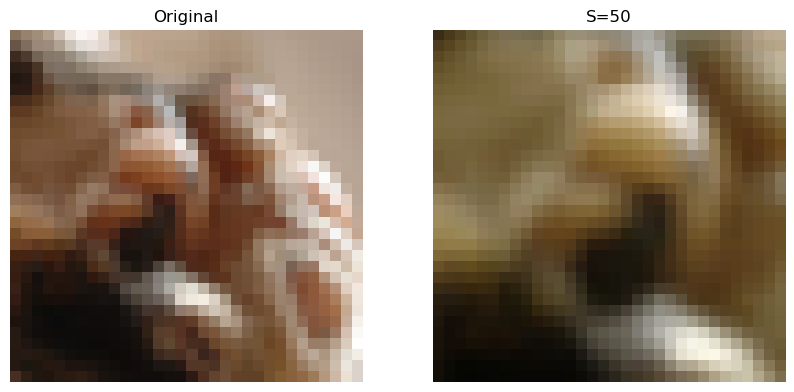

In [6]:
s = 50

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_fst_50 = fix_scale_transform(s)(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("S=50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

### Multi-Scale Transform Visualization

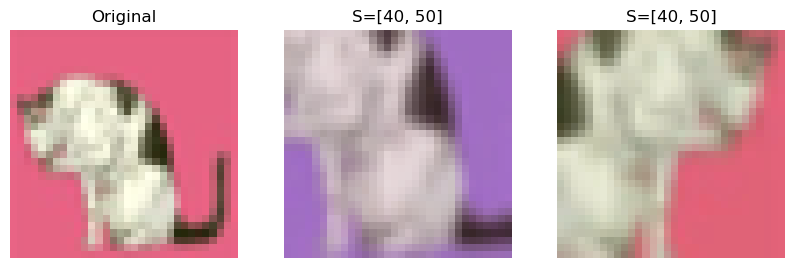

In [7]:
s_min, s_max = 40, 50

mst_40_50 = multi_scale_transform(s_min, s_max)

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_mst_40_50_1 = mst_40_50(img)
img_mst_40_50_2 = mst_40_50(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_1).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_2).permute(1, 2, 0))
plt.axis(False)

plt.show()

### Definition of PairedFlipDataset and MultiTransformDataset

In [8]:
class PairedFlipDataset(Dataset):
  """
  Wraps a base dataset that already includes transforms, and returns
  both the original image and its horizontally flipped version, along with the label.

  Assumes:
      - The base dataset returns (transformed_image, label) pairs.
      - The image is already preprocessed (e.g., resized, normalized).

  Returns:
      (original_image, flipped_image, label)
  """
  
  def __init__(self, base_dataset):
    self.base_dataset = base_dataset
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    img_flipped = T.hflip(img)
    
    return img, img_flipped, label

class MultiTransformDataset(Dataset):
  """
  Applies multiple transforms to the same input image from the base dataset,
  and returns all transformed versions along with the label.

  Assumes:
      - The base dataset returns (PIL image, label) pairs, with no transform applied.
      - A list of transform functions (e.g., torchvision.transforms.Compose) is provided.

  Args:
      base_dataset: A dataset yielding untransformed (PIL image, label) pairs.
      *trans: One or more transform functions to apply to the input image.

  Returns:
      (*transformed_images, label)
  """
  
  def __init__(self, base_dataset, trans):
    self.base_dataset = base_dataset
    self.trans = trans
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    *imgs, label = self.base_dataset[idx]
    
    imgs = [tran(img) for img in imgs for tran in self.trans]
    
    return *imgs, label

### PairedFlipDataset Visualization

Files already downloaded and verified


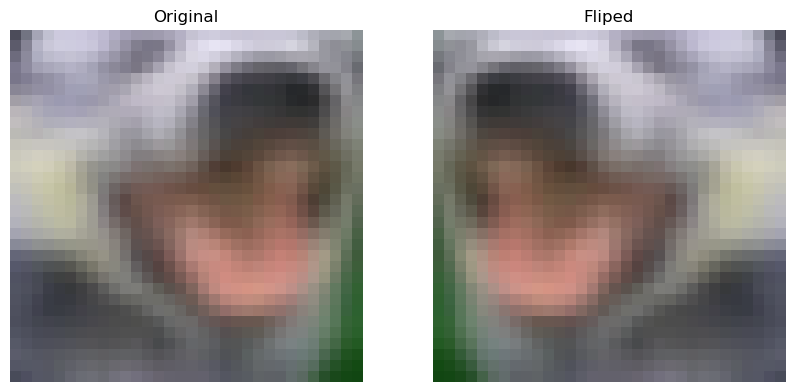

In [9]:
fst_50 = fix_scale_transform(50)

fst_50_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst_50
)

fst_50_paired_flip_test_dataset = PairedFlipDataset(fst_50_test_dataset)

img, img_flipped, label = fst_50_paired_flip_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(denormalize(img).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("Fliped")
plt.imshow(denormalize(img_flipped).permute(1, 2, 0))
plt.axis(False)

plt.show()

### MultiTransformDataset Visualization

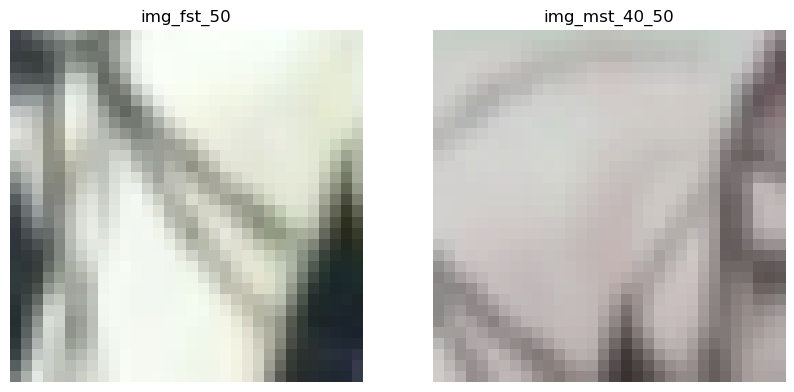

In [10]:
fst_50 = fix_scale_transform(50)
mst_40_50 = multi_scale_transform(40, 50)

multi_trans_test_dataset = MultiTransformDataset(default_test_dataset, [fst_50, mst_40_50])

img_fst_50, img_mst_40_50, label = multi_trans_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("img_fst_50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("img_mst_40_50")
plt.imshow(denormalize(img_mst_40_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

## 3. Training and Evaluation Functions

In [23]:
class Trainer:
  def __init__(self, train_name, model_class, train_transform, test_transforms):
    self.train_name = train_name
    self.model_class = model_class
    self.train_transform = train_transform
    self.test_transforms = test_transforms
    
    self.epoch = 0
    self.logs = [[], [], [], []]
    
    self.train_dataset = datasets.CIFAR10(
      root="data",
      download=True,
      train=True,
      transform=self.train_transform
    )

    self.test_dataset = MultiTransformDataset(
      PairedFlipDataset(datasets.CIFAR10(
      root="data",
      download=True,
      train=False
      )),
      self.test_transforms
    )
    
    self.batch_size = 32

    self.train_dataloader = DataLoader(
      dataset=self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      pin_memory=True
    )

    self.test_dataloader = DataLoader(
      dataset=self.test_dataset,
      batch_size=self.batch_size,
      shuffle=False,
      pin_memory=True
    )

    self.model = self.model_class().to(device)

    self.criterion = nn.CrossEntropyLoss()

    self.optimizer = torch.optim.SGD(
      params=self.model.parameters(),
      momentum=0.9,
      lr=0.01
    )
    
    self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		  self.optimizer,
      "max",
      factor=0.1,
      patience=3
		)

    self.accuracy = Accuracy(
      task="multiclass",
      num_classes=len(self.train_dataset.classes)
    ).to(device)
    
  def train(self, epoch=1):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for cur_epoch in range(self.epoch + 1, self.epoch + epoch + 1):
      train_loss, train_acc = self._train_epoch()
      val_loss, val_acc = self._validate_epoch()

      self.scheduler.step(val_acc)

      train_losses.append(train_loss)
      train_accs.append(train_acc)
      val_losses.append(val_loss)
      val_accs.append(val_acc)

      self.epoch = cur_epoch

      print(f"Epoch: {cur_epoch: 4d} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .5f} | Val loss: {val_loss: .5f} | Val acc: {val_acc: .5f}")

    self._concat_logs(train_losses, train_accs, val_losses, val_accs)
    self._plot_train_log()
  
  def evaluate(self):
    self.model.eval()

    val_acc = 0

    with torch.no_grad():
      for *Xs, y in tqdm(self.test_dataloader, desc="Evaluate", leave=False):
        *Xs, y = self._to_device(*Xs, y)

        probs = 0

        for X in Xs:
          logits = self.model(X)
          probs += torch.softmax(logits, dim=1)  

        probs = probs / len(self.test_transforms)
        preds = probs.argmax(dim=1)

        val_acc += self.accuracy(preds, y).cpu().item()

    val_acc /= len(self.test_dataloader)

    return val_acc
  
  def checkout(self):
    torch.save(
      {
        "state_dict": self.model.state_dict(),
        "optimizer": self.optimizer.state_dict(),
        "epoch": self.epoch,
        "logs": self.logs
      },
      os.path.join("model", f"{self.train_name}_ep_{self.epoch}.pth")
    )
  
  def _train_epoch(self):
    self.model.train()

    train_loss, train_acc = 0, 0

    for X, y in tqdm(self.train_dataloader, desc="Training", leave=False):
      X, y = self._to_device(X, y)

      logits = self.model(X)

      loss = self.criterion(logits, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      with torch.no_grad():
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        train_loss += loss.cpu().item()
        train_acc += self.accuracy(preds, y).cpu().item()

    train_loss /= len(self.train_dataloader)
    train_acc /= len(self.train_dataloader)

    return train_loss, train_acc
  
  def _validate_epoch(self):
    self.model.eval()

    val_loss, val_acc = 0, 0

    with torch.no_grad():
      for X, *_, y in tqdm(self.test_dataloader, desc="Validate", leave=False):
        X, y = self._to_device(X, y)

        logits = self.model(X)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        loss = self.criterion(logits, y)

        val_loss += loss.cpu().item()
        val_acc += self.accuracy(preds, y).cpu().item()

    val_loss /= len(self.test_dataloader)
    val_acc /= len(self.test_dataloader)

    return val_loss, val_acc
  
  def _plot_train_log(self):
    train_losses, train_accs, val_losses, val_accs = self.logs
    
    epochs = np.arange(1, self.epoch + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", linewidth=2, marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2, marker='s')
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", linewidth=2, marker='o')
    plt.plot(epochs, val_accs, label="Validation Accuracy", linewidth=2, marker='s')
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()
  
  def _concat_logs(self, *logs):
    self.logs = [[*log1, *log2] for log1, log2 in zip(self.logs, logs)]
  
  def _to_device(self, *args, device=device):
    return [arg.to(device, non_blocking=True) for arg in args]

## 4. Model Architecture

In [12]:
class VGGBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_convs, kernel_sizes=3):
    super().__init__()
    
    assert isinstance(kernel_sizes, int) or len(kernel_sizes) == n_convs
    
    if isinstance(kernel_sizes, int):
      kernel_sizes = [kernel_sizes for _ in range(n_convs)]
        
    paddings = [(kernel_size - 1) // 2 for kernel_size in kernel_sizes]
    
    layers = []

    for kernel_size, padding in zip(kernel_sizes, paddings):
      assert 2 * padding - kernel_size + 1 == 0

      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))

      in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

### TinyVGG A

In [13]:
class TinyVGG_A(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=1),
      VGGBlock(8, 16, n_convs=1),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG B

In [14]:
class TinyVGG_B(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG C

In [15]:
class TinyVGG_C(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(32, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(64, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG D

In [16]:
class TinyVGG_D(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3),
      VGGBlock(32, 64, n_convs=3),
      VGGBlock(64, 64, n_convs=3),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

### TinyVGG E

In [17]:
class TinyVGG_E(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=4),
      VGGBlock(32, 64, n_convs=4),
      VGGBlock(64, 64, n_convs=4),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

## 5. Training

### First 10 epochs of train

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.88139 | Train acc:  0.28037 | Val loss:  1.69707 | Val acc:  0.36412


Epoch:    2 | Train loss:  1.64150 | Train acc:  0.39167 | Val loss:  1.43005 | Val acc:  0.48173


Epoch:    3 | Train loss:  1.49455 | Train acc:  0.46789 | Val loss:  1.38124 | Val acc:  0.50829


Epoch:    4 | Train loss:  1.39860 | Train acc:  0.52001 | Val loss:  1.22182 | Val acc:  0.57778


Epoch:    5 | Train loss:  1.31557 | Train acc:  0.55854 | Val loss:  1.12563 | Val acc:  0.61412


Epoch:    6 | Train loss:  1.24773 | Train acc:  0.58425 | Val loss:  1.11122 | Val acc:  0.62410


Epoch:    7 | Train loss:  1.19926 | Train acc:  0.60501 | Val loss:  1.09961 | Val acc:  0.63219


Epoch:    8 | Train loss:  1.16670 | Train acc:  0.61358 | Val loss:  1.02276 | Val acc:  0.65176


Epoch:    9 | Train loss:  1.12421 | Train acc:  0.63136 | Val loss:  0.98910 | Val acc:  0.66514


Epoch:   10 | Train loss:  1.09827 | Train acc:  0.63908 | Val loss:  1.01744 | Val acc:  0.66164


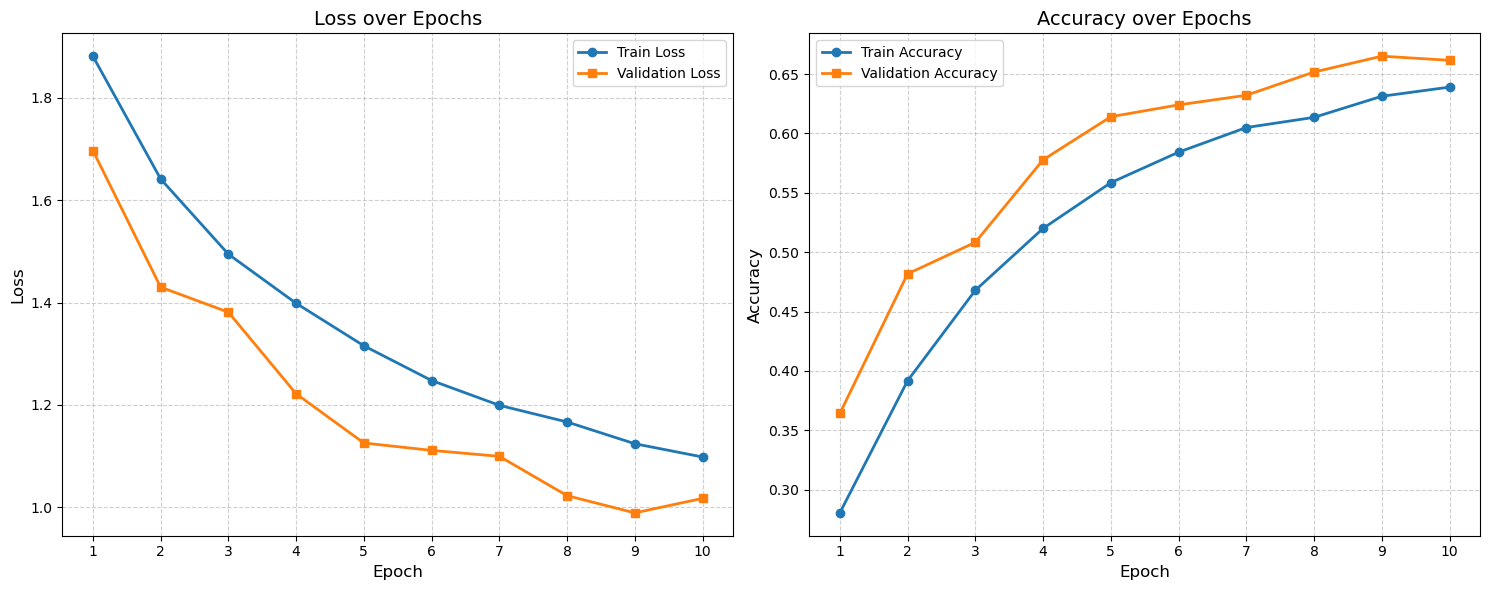

a_f_36_f_36 Acc:  0.68550


In [28]:
a_f_36_f_36 = Trainer(
  train_name="a_f_36_f_36",
  model_class=TinyVGG_A,
  train_transform=fix_scale_transform(s=36),
  test_transforms=[fix_scale_transform(s=36)]
)

a_f_36_f_36.train(epoch=10)

print(f"a_f_36_f_36 Acc: {a_f_36_f_36.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.86374 | Train acc:  0.28971 | Val loss:  1.63992 | Val acc:  0.37869


Epoch:    2 | Train loss:  1.59205 | Train acc:  0.41641 | Val loss:  1.53011 | Val acc:  0.45617


Epoch:    3 | Train loss:  1.42314 | Train acc:  0.50834 | Val loss:  1.21763 | Val acc:  0.58027


Epoch:    4 | Train loss:  1.30697 | Train acc:  0.56024 | Val loss:  1.30915 | Val acc:  0.56380


Epoch:    5 | Train loss:  1.21324 | Train acc:  0.59687 | Val loss:  1.05926 | Val acc:  0.63818


Epoch:    6 | Train loss:  1.14992 | Train acc:  0.62332 | Val loss:  1.06284 | Val acc:  0.64107


Epoch:    7 | Train loss:  1.09370 | Train acc:  0.64403 | Val loss:  0.96335 | Val acc:  0.67692


Epoch:    8 | Train loss:  1.06296 | Train acc:  0.65363 | Val loss:  0.95294 | Val acc:  0.67941


Epoch:    9 | Train loss:  1.03187 | Train acc:  0.66731 | Val loss:  0.94823 | Val acc:  0.69299


Epoch:   10 | Train loss:  0.99822 | Train acc:  0.67696 | Val loss:  0.92968 | Val acc:  0.68570


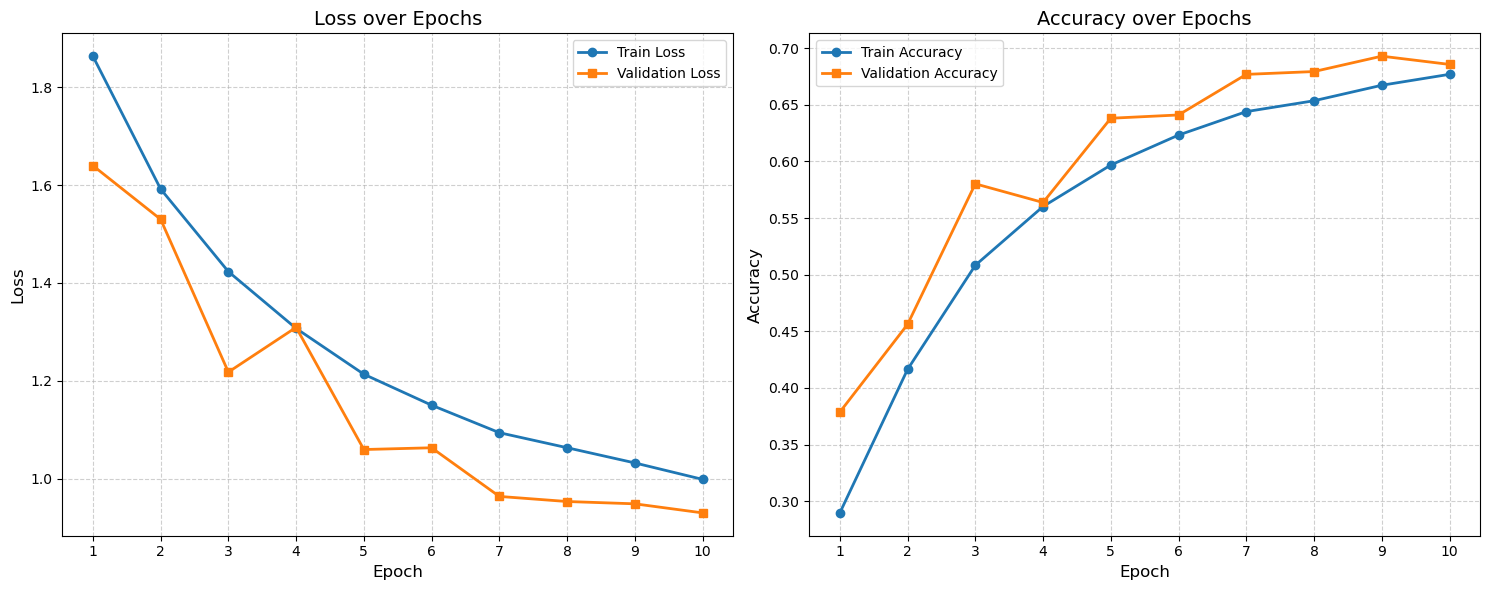

b_f_36_f_36 Acc:  0.70667


In [29]:
b_f_36_f_36 = Trainer(
  train_name="b_f_36_f_36",
  model_class=TinyVGG_B,
  train_transform=fix_scale_transform(s=36),
  test_transforms=[fix_scale_transform(s=36)]
)

b_f_36_f_36.train(epoch=10)

print(f"b_f_36_f_36 Acc: {b_f_36_f_36.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.97061 | Train acc:  0.23732 | Val loss:  1.62282 | Val acc:  0.36072


Epoch:    2 | Train loss:  1.67716 | Train acc:  0.35962 | Val loss:  1.72495 | Val acc:  0.35533


Epoch:    3 | Train loss:  1.54145 | Train acc:  0.43722 | Val loss:  1.34594 | Val acc:  0.50869


Epoch:    4 | Train loss:  1.41764 | Train acc:  0.50310 | Val loss:  1.47497 | Val acc:  0.50310


Epoch:    5 | Train loss:  1.34085 | Train acc:  0.54195 | Val loss:  1.18969 | Val acc:  0.58476


Epoch:    6 | Train loss:  1.26368 | Train acc:  0.57020 | Val loss:  1.13701 | Val acc:  0.61272


Epoch:    7 | Train loss:  1.22019 | Train acc:  0.58991 | Val loss:  1.06616 | Val acc:  0.63758


Epoch:    8 | Train loss:  1.16920 | Train acc:  0.60835 | Val loss:  1.06031 | Val acc:  0.64028


Epoch:    9 | Train loss:  1.11572 | Train acc:  0.63156 | Val loss:  1.02439 | Val acc:  0.64637


Epoch:   10 | Train loss:  1.08996 | Train acc:  0.64145 | Val loss:  0.99333 | Val acc:  0.66254


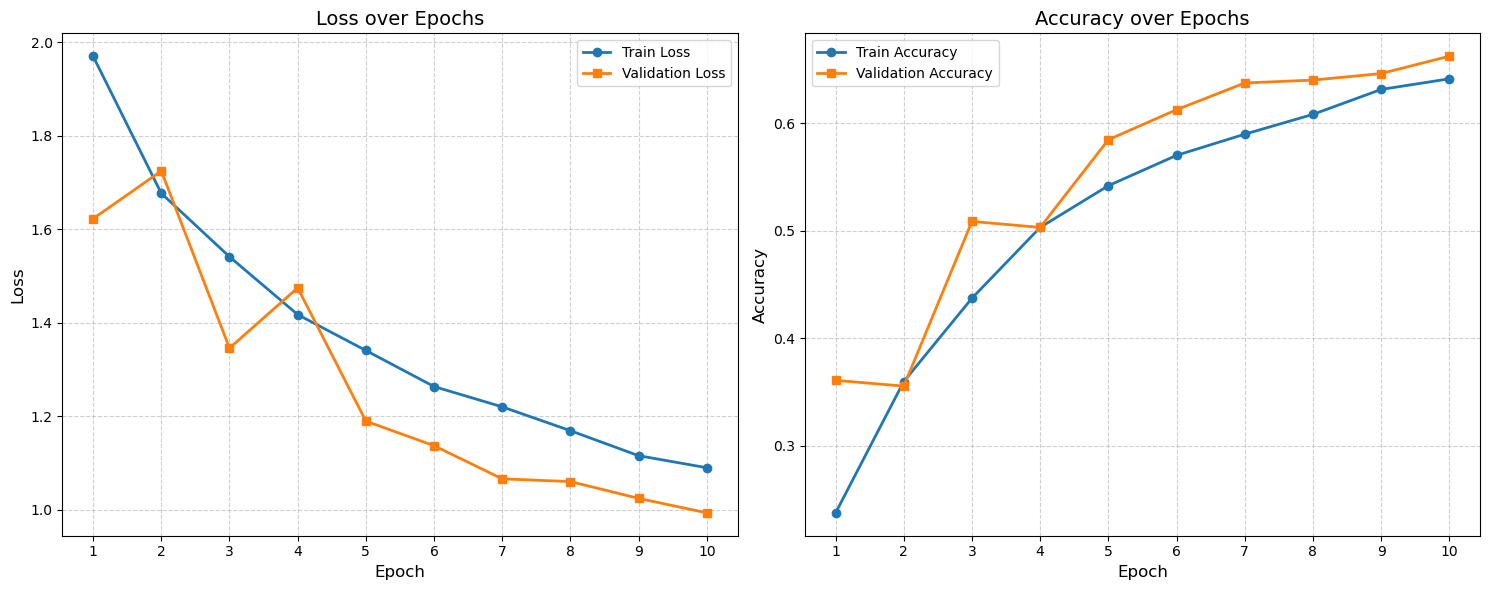

c_f_36_f_36 Acc:  0.68231


In [30]:
c_f_36_f_36 = Trainer(
  train_name="c_f_36_f_36",
  model_class=TinyVGG_C,
  train_transform=fix_scale_transform(s=36),
  test_transforms=[fix_scale_transform(s=36)]
)

c_f_36_f_36.train(epoch=10)

print(f"c_f_36_f_36 Acc: {c_f_36_f_36.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  2.00239 | Train acc:  0.22053 | Val loss:  1.73571 | Val acc:  0.33117


Epoch:    2 | Train loss:  1.76427 | Train acc:  0.32929 | Val loss:  1.56127 | Val acc:  0.41174


Epoch:    3 | Train loss:  1.62634 | Train acc:  0.39445 | Val loss:  1.44282 | Val acc:  0.46346


Epoch:    4 | Train loss:  1.52179 | Train acc:  0.44908 | Val loss:  1.37227 | Val acc:  0.50799


Epoch:    5 | Train loss:  1.43840 | Train acc:  0.50234 | Val loss:  1.26955 | Val acc:  0.55491


Epoch:    6 | Train loss:  1.36377 | Train acc:  0.53781 | Val loss:  1.28708 | Val acc:  0.56579


Epoch:    7 | Train loss:  1.31330 | Train acc:  0.55864 | Val loss:  1.14356 | Val acc:  0.60154


Epoch:    8 | Train loss:  1.27796 | Train acc:  0.57128 | Val loss:  1.09729 | Val acc:  0.62690


Epoch:    9 | Train loss:  1.23234 | Train acc:  0.58965 | Val loss:  1.14228 | Val acc:  0.60793


Epoch:   10 | Train loss:  1.20691 | Train acc:  0.59865 | Val loss:  1.08515 | Val acc:  0.62340


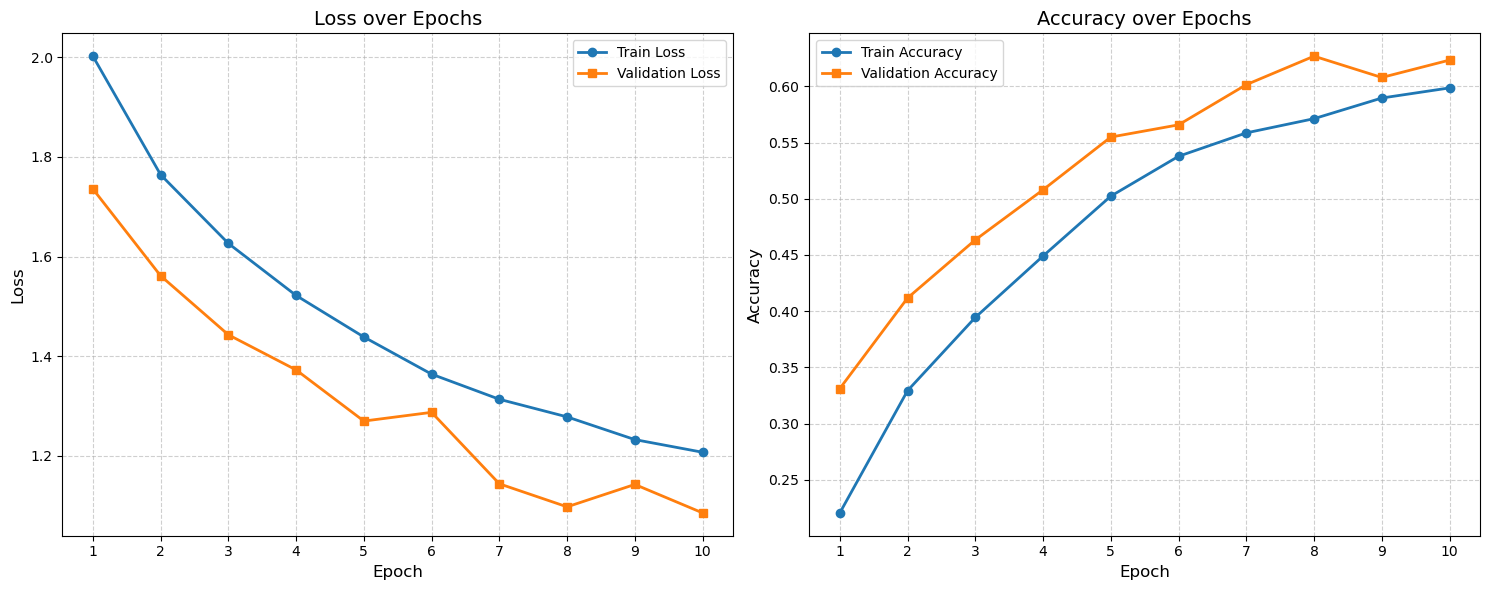

c_f_40_f_40 Acc:  0.65725


In [31]:
c_f_40_f_40 = Trainer(
  train_name="c_f_40_f_40",
  model_class=TinyVGG_C,
  train_transform=fix_scale_transform(s=40),
  test_transforms=[fix_scale_transform(s=40)]
)

c_f_40_f_40.train(epoch=10)

print(f"c_f_40_f_40 Acc: {c_f_40_f_40.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  2.00972 | Train acc:  0.20130 | Val loss:  1.85969 | Val acc:  0.24790


Epoch:    2 | Train loss:  1.80785 | Train acc:  0.30016 | Val loss:  1.61537 | Val acc:  0.39087


Epoch:    3 | Train loss:  1.64673 | Train acc:  0.37544 | Val loss:  1.47407 | Val acc:  0.42492


Epoch:    4 | Train loss:  1.55045 | Train acc:  0.43384 | Val loss:  1.37133 | Val acc:  0.50869


Epoch:    5 | Train loss:  1.46538 | Train acc:  0.48494 | Val loss:  1.44809 | Val acc:  0.51138


Epoch:    6 | Train loss:  1.39220 | Train acc:  0.51911 | Val loss:  1.36054 | Val acc:  0.51388


Epoch:    7 | Train loss:  1.33703 | Train acc:  0.54003 | Val loss:  1.19861 | Val acc:  0.58806


Epoch:    8 | Train loss:  1.29158 | Train acc:  0.56172 | Val loss:  1.11852 | Val acc:  0.61182


Epoch:    9 | Train loss:  1.24241 | Train acc:  0.58007 | Val loss:  1.13202 | Val acc:  0.59864


Epoch:   10 | Train loss:  1.20959 | Train acc:  0.59221 | Val loss:  1.05801 | Val acc:  0.63289


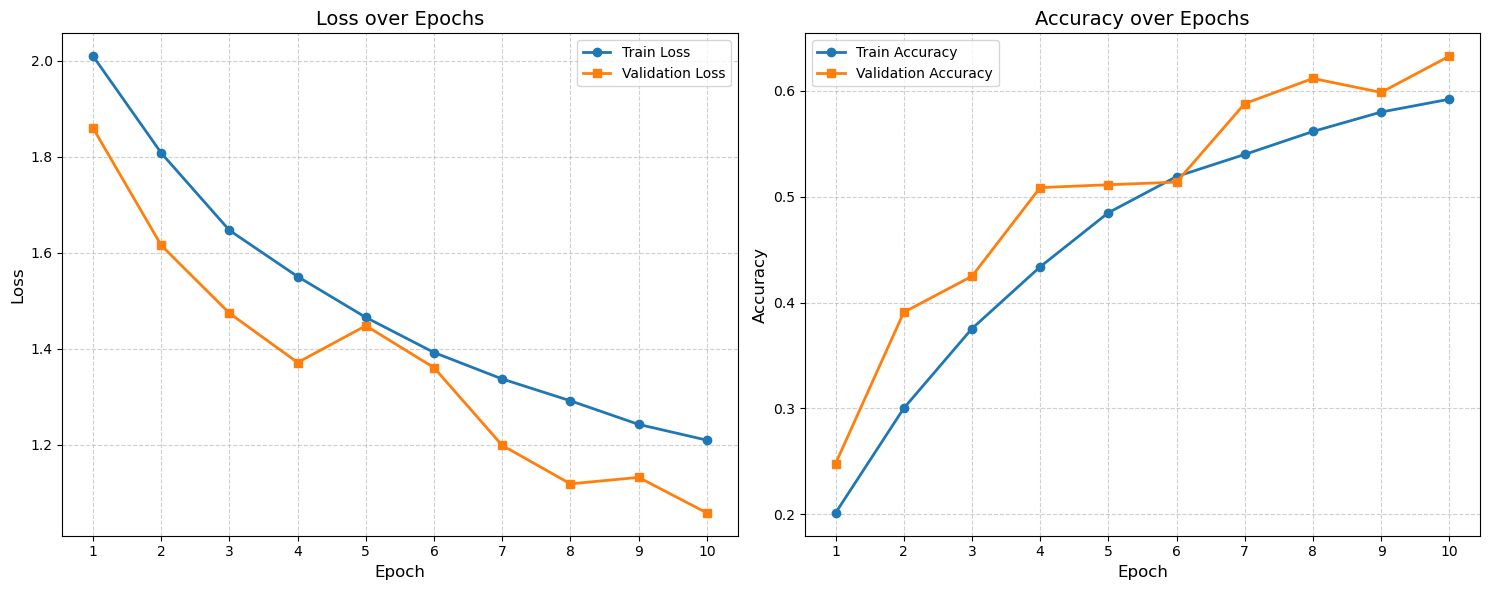

c_m_36_44_f_40 Acc:  0.65645


In [32]:
c_m_36_44_f_40 = Trainer(
  train_name="c_m_36_44_f_40",
  model_class=TinyVGG_C,
  train_transform=multi_scale_transform(s_min=36, s_max=44),
  test_transforms=[fix_scale_transform(s=40)]
)

c_m_36_44_f_40.train(epoch=10)

print(f"c_m_36_44_f_40 Acc: {c_m_36_44_f_40.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.94669 | Train acc:  0.23550 | Val loss:  1.68263 | Val acc:  0.32768


Epoch:    2 | Train loss:  1.71073 | Train acc:  0.33821 | Val loss:  1.52970 | Val acc:  0.40425


Epoch:    3 | Train loss:  1.57834 | Train acc:  0.40411 | Val loss:  1.38308 | Val acc:  0.48692


Epoch:    4 | Train loss:  1.46147 | Train acc:  0.47833 | Val loss:  1.24810 | Val acc:  0.56180


Epoch:    5 | Train loss:  1.35469 | Train acc:  0.53205 | Val loss:  1.15544 | Val acc:  0.60094


Epoch:    6 | Train loss:  1.27177 | Train acc:  0.56900 | Val loss:  1.11126 | Val acc:  0.61621


Epoch:    7 | Train loss:  1.20787 | Train acc:  0.59515 | Val loss:  1.10874 | Val acc:  0.62390


Epoch:    8 | Train loss:  1.15332 | Train acc:  0.61756 | Val loss:  0.98727 | Val acc:  0.66733


Epoch:    9 | Train loss:  1.09746 | Train acc:  0.63972 | Val loss:  0.98772 | Val acc:  0.66613


Epoch:   10 | Train loss:  1.06247 | Train acc:  0.65277 | Val loss:  0.91732 | Val acc:  0.69439


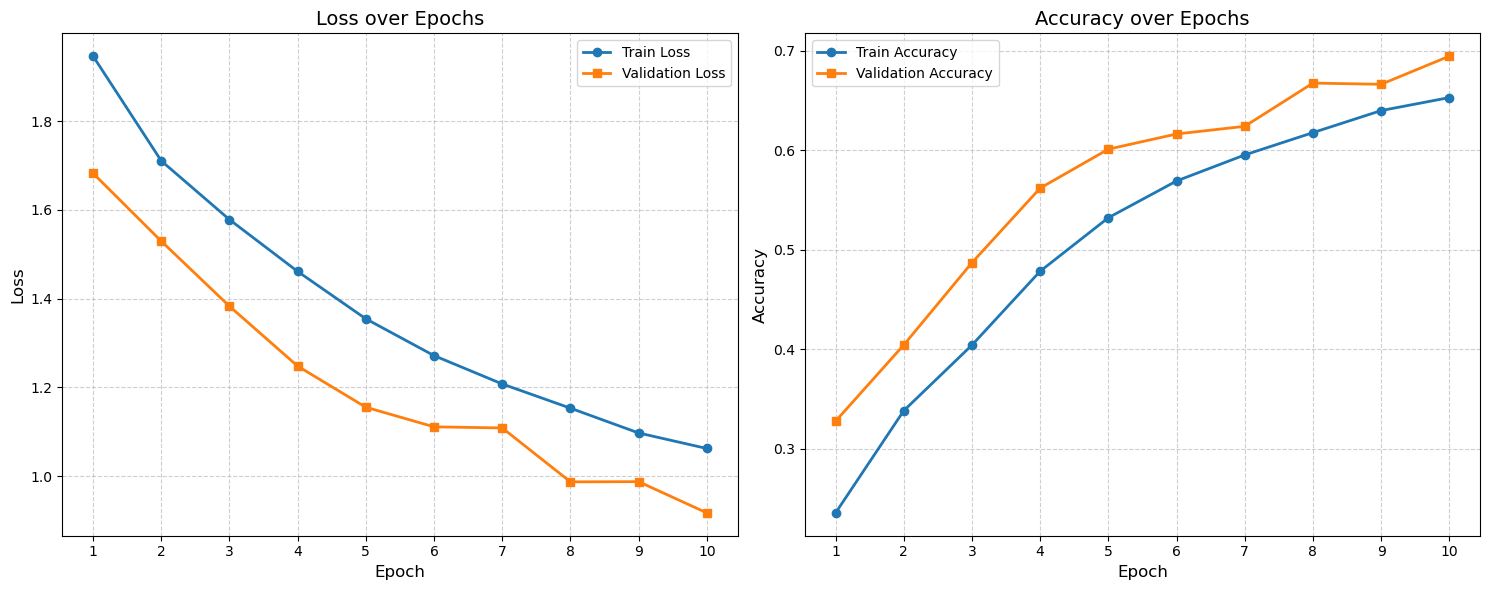

d_f_36_f_36 Acc:  0.71246


In [33]:
d_f_36_f_36 = Trainer(
  train_name="d_f_36_f_36",
  model_class=TinyVGG_D,
  train_transform=fix_scale_transform(s=36),
  test_transforms=[fix_scale_transform(s=36)]
)

d_f_36_f_36.train(epoch=10)

print(f"d_f_36_f_36 Acc: {d_f_36_f_36.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  2.01503 | Train acc:  0.19536 | Val loss:  1.81558 | Val acc:  0.27965


Epoch:    2 | Train loss:  1.84075 | Train acc:  0.26813 | Val loss:  1.65106 | Val acc:  0.35623


Epoch:    3 | Train loss:  1.70676 | Train acc:  0.34255 | Val loss:  1.50429 | Val acc:  0.37859


Epoch:    4 | Train loss:  1.59188 | Train acc:  0.39671 | Val loss:  1.44348 | Val acc:  0.45417


Epoch:    5 | Train loss:  1.51220 | Train acc:  0.43980 | Val loss:  1.35284 | Val acc:  0.49870


Epoch:    6 | Train loss:  1.43691 | Train acc:  0.48544 | Val loss:  1.28405 | Val acc:  0.53245


Epoch:    7 | Train loss:  1.36691 | Train acc:  0.52313 | Val loss:  1.19442 | Val acc:  0.57238


Epoch:    8 | Train loss:  1.30682 | Train acc:  0.55112 | Val loss:  1.27258 | Val acc:  0.56440


Epoch:    9 | Train loss:  1.25236 | Train acc:  0.57688 | Val loss:  1.07533 | Val acc:  0.62780


Epoch:   10 | Train loss:  1.20738 | Train acc:  0.59409 | Val loss:  1.14435 | Val acc:  0.60094


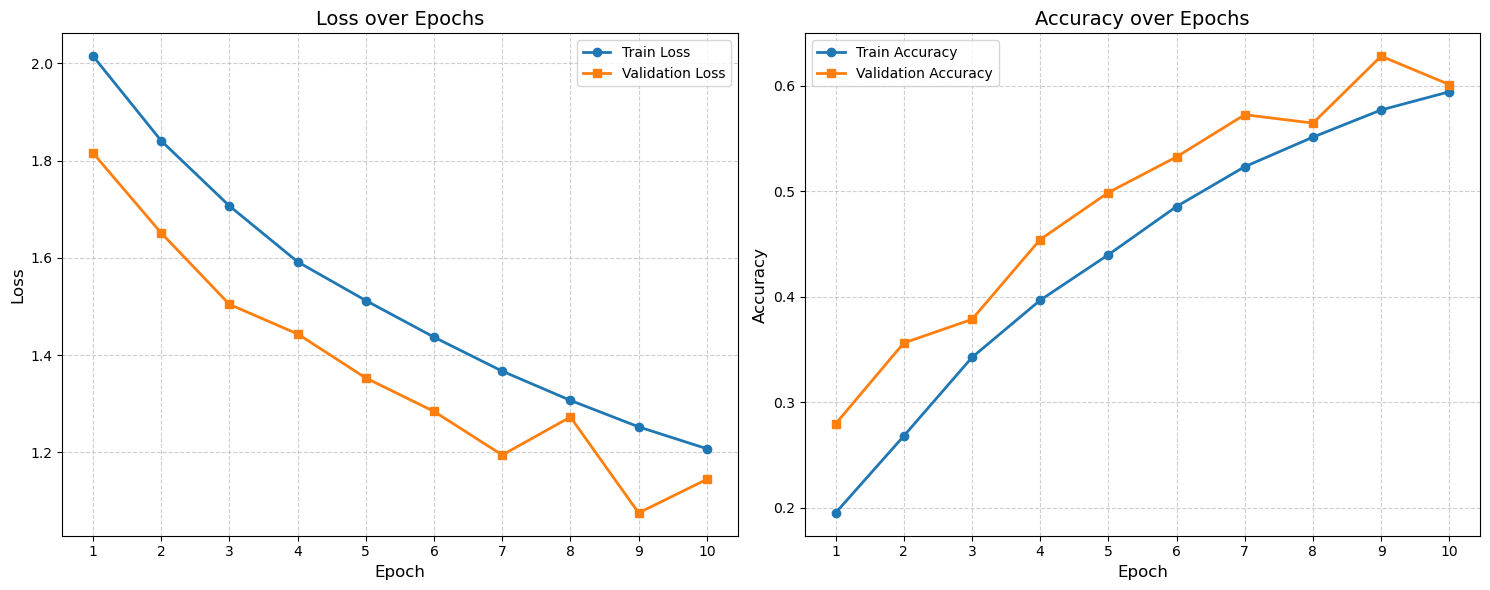

d_f_40_f_40 Acc:  0.62121


In [ ]:
d_f_40_f_40 = Trainer(
  train_name="d_f_40_f_40",
  model_class=TinyVGG_D,
  train_transform=fix_scale_transform(s=40),
  test_transforms=[fix_scale_transform(s=40)]
)

d_f_40_f_40.train(epoch=10)

print(f"d_f_40_f_40 Acc: {d_f_40_f_40.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.99367 | Train acc:  0.21675 | Val loss:  1.73496 | Val acc:  0.29263


Epoch:    2 | Train loss:  1.78338 | Train acc:  0.29862 | Val loss:  1.64310 | Val acc:  0.37829


Epoch:    3 | Train loss:  1.66231 | Train acc:  0.36874 | Val loss:  1.68527 | Val acc:  0.38039


Epoch:    4 | Train loss:  1.56711 | Train acc:  0.42704 | Val loss:  1.46262 | Val acc:  0.46885


Epoch:    5 | Train loss:  1.48792 | Train acc:  0.47637 | Val loss:  1.42185 | Val acc:  0.49421


Epoch:    6 | Train loss:  1.40442 | Train acc:  0.51975 | Val loss:  1.23205 | Val acc:  0.57218


Epoch:    7 | Train loss:  1.33406 | Train acc:  0.55134 | Val loss:  1.15325 | Val acc:  0.59984


Epoch:    8 | Train loss:  1.26655 | Train acc:  0.58065 | Val loss:  1.09384 | Val acc:  0.62091


Epoch:    9 | Train loss:  1.21904 | Train acc:  0.59787 | Val loss:  1.12653 | Val acc:  0.62630


Epoch:   10 | Train loss:  1.18508 | Train acc:  0.61146 | Val loss:  1.10837 | Val acc:  0.61941


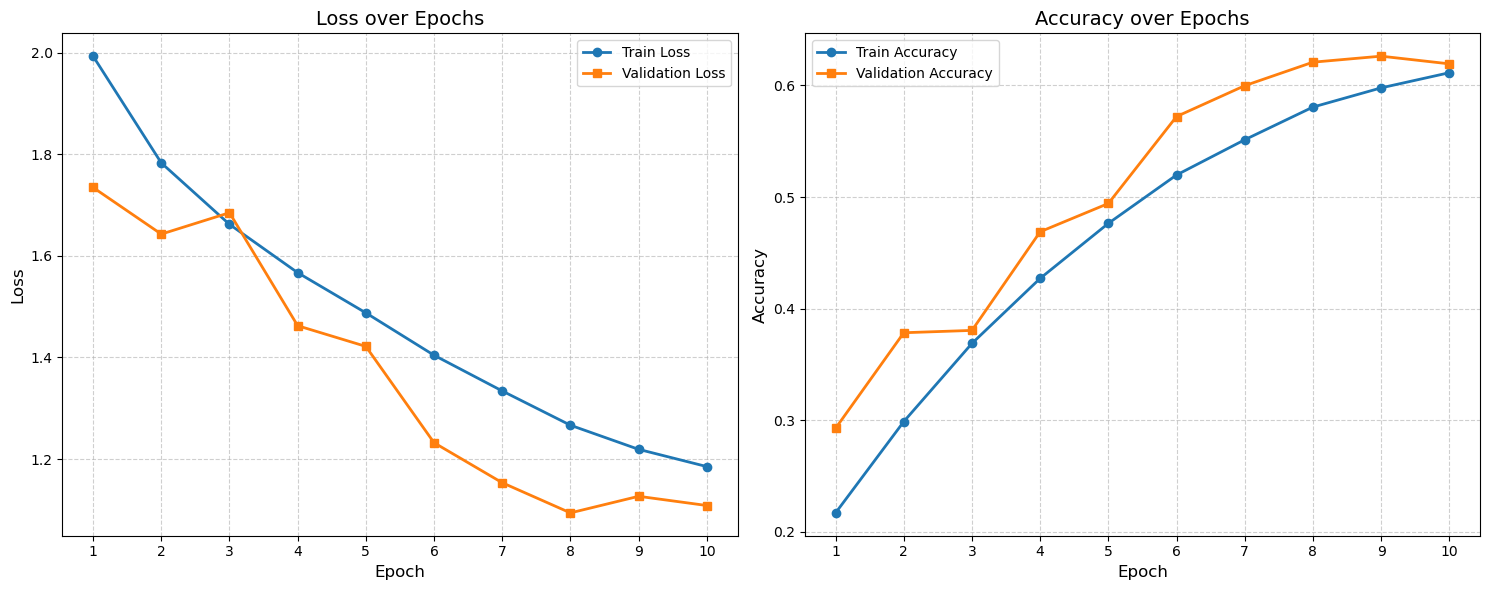

d_m_36_44_f_40 Acc:  0.64347


In [35]:
d_m_36_44_f_40 = Trainer(
  train_name="d_m_36_44_f_40",
  model_class=TinyVGG_D,
  train_transform=multi_scale_transform(s_min=36, s_max=44),
  test_transforms=[fix_scale_transform(s=40)]
)

d_m_36_44_f_40.train(epoch=10)

print(f"d_m_36_44_f_40 Acc: {d_m_36_44_f_40.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  2.04876 | Train acc:  0.17582 | Val loss:  1.88881 | Val acc:  0.20647


Epoch:    2 | Train loss:  1.91487 | Train acc:  0.21769 | Val loss:  1.85782 | Val acc:  0.25879


Epoch:    3 | Train loss:  1.82526 | Train acc:  0.27213 | Val loss:  1.66234 | Val acc:  0.36761


Epoch:    4 | Train loss:  1.65891 | Train acc:  0.36630 | Val loss:  1.61935 | Val acc:  0.38918


Epoch:    5 | Train loss:  1.54951 | Train acc:  0.41809 | Val loss:  1.47444 | Val acc:  0.43660


Epoch:    6 | Train loss:  1.46362 | Train acc:  0.46931 | Val loss:  1.29152 | Val acc:  0.53734


Epoch:    7 | Train loss:  1.37288 | Train acc:  0.52229 | Val loss:  1.20367 | Val acc:  0.57448


Epoch:    8 | Train loss:  1.29655 | Train acc:  0.55664 | Val loss:  1.13911 | Val acc:  0.60353


Epoch:    9 | Train loss:  1.25024 | Train acc:  0.57498 | Val loss:  1.29158 | Val acc:  0.58117


Epoch:   10 | Train loss:  1.20138 | Train acc:  0.59481 | Val loss:  1.07421 | Val acc:  0.61821


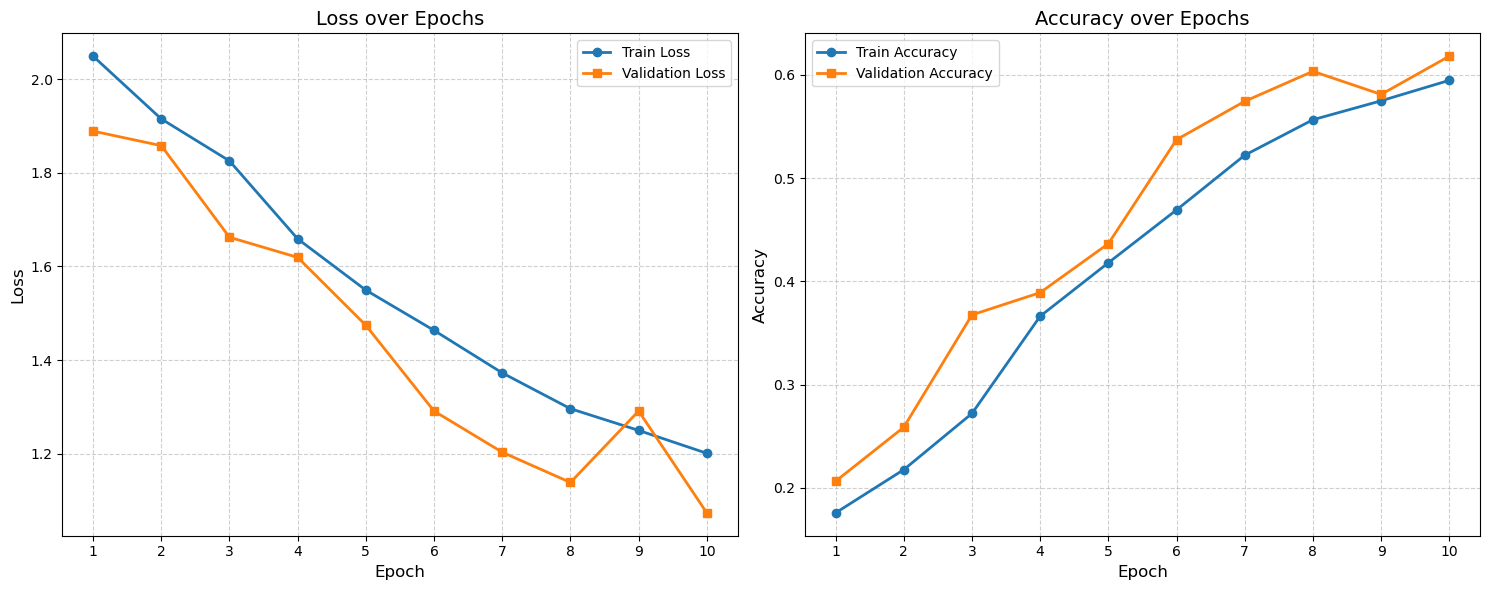

e_f_36_f_36 Acc:  0.64077


In [36]:
e_f_36_f_36 = Trainer(
  train_name="e_f_36_f_36",
  model_class=TinyVGG_E,
  train_transform=fix_scale_transform(s=36),
  test_transforms=[fix_scale_transform(s=36)]
)

e_f_36_f_36.train(epoch=10)

print(f"e_f_36_f_36 Acc: {e_f_36_f_36.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  2.02406 | Train acc:  0.18152 | Val loss:  1.89570 | Val acc:  0.19609


Epoch:    2 | Train loss:  1.93380 | Train acc:  0.20693 | Val loss:  1.84154 | Val acc:  0.25210


Epoch:    3 | Train loss:  1.85627 | Train acc:  0.25650 | Val loss:  1.76291 | Val acc:  0.27406


Epoch:    4 | Train loss:  1.75856 | Train acc:  0.31424 | Val loss:  1.59127 | Val acc:  0.37859


Epoch:    5 | Train loss:  1.66387 | Train acc:  0.35653 | Val loss:  1.50889 | Val acc:  0.41494


Epoch:    6 | Train loss:  1.59192 | Train acc:  0.39625 | Val loss:  1.50534 | Val acc:  0.43371


Epoch:    7 | Train loss:  1.53486 | Train acc:  0.43368 | Val loss:  1.45172 | Val acc:  0.44898


Epoch:    8 | Train loss:  1.47053 | Train acc:  0.46327 | Val loss:  1.41373 | Val acc:  0.48013


Epoch:    9 | Train loss:  1.43045 | Train acc:  0.48812 | Val loss:  1.27873 | Val acc:  0.52366


Epoch:   10 | Train loss:  1.38807 | Train acc:  0.51623 | Val loss:  1.24189 | Val acc:  0.56260


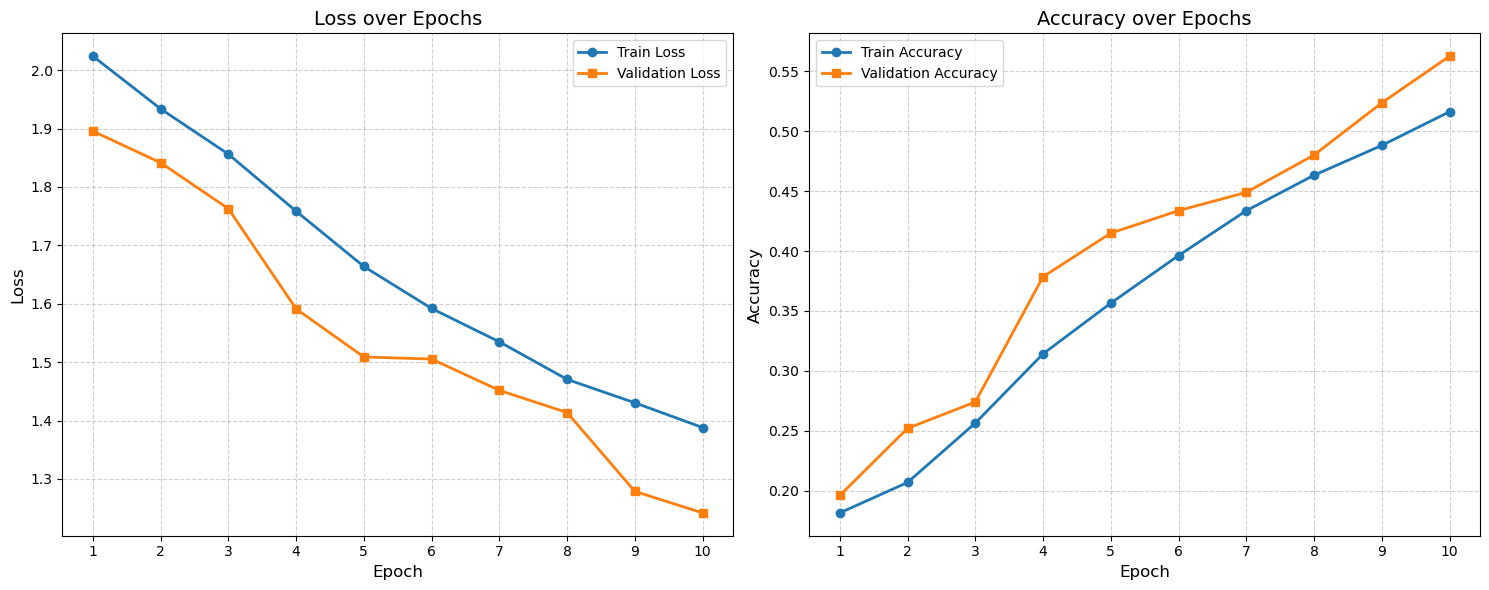

e_f_40_f_40 Acc:  0.58766


In [37]:
e_f_40_f_40 = Trainer(
  train_name="e_f_40_f_40",
  model_class=TinyVGG_E,
  train_transform=fix_scale_transform(s=40),
  test_transforms=[fix_scale_transform(s=40)]
)

e_f_40_f_40.train(epoch=10)

print(f"e_f_40_f_40 Acc: {e_f_40_f_40.evaluate(): .5f}")

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  2.04192 | Train acc:  0.18298 | Val loss:  1.92264 | Val acc:  0.21276


Epoch:    2 | Train loss:  1.93896 | Train acc:  0.21259 | Val loss:  1.88446 | Val acc:  0.23383


Epoch:    3 | Train loss:  1.89028 | Train acc:  0.24674 | Val loss:  1.87878 | Val acc:  0.25639


Epoch:    4 | Train loss:  1.77987 | Train acc:  0.30496 | Val loss:  1.66283 | Val acc:  0.36412


Epoch:    5 | Train loss:  1.67190 | Train acc:  0.35485 | Val loss:  1.52649 | Val acc:  0.41454


Epoch:    6 | Train loss:  1.60046 | Train acc:  0.39869 | Val loss:  1.62760 | Val acc:  0.40735


Epoch:    7 | Train loss:  1.54494 | Train acc:  0.43320 | Val loss:  1.38230 | Val acc:  0.49032


Epoch:    8 | Train loss:  1.48272 | Train acc:  0.46735 | Val loss:  1.44520 | Val acc:  0.48892


Epoch:    9 | Train loss:  1.41553 | Train acc:  0.50354 | Val loss:  1.24088 | Val acc:  0.56020


Epoch:   10 | Train loss:  1.36834 | Train acc:  0.52105 | Val loss:  1.31489 | Val acc:  0.55881


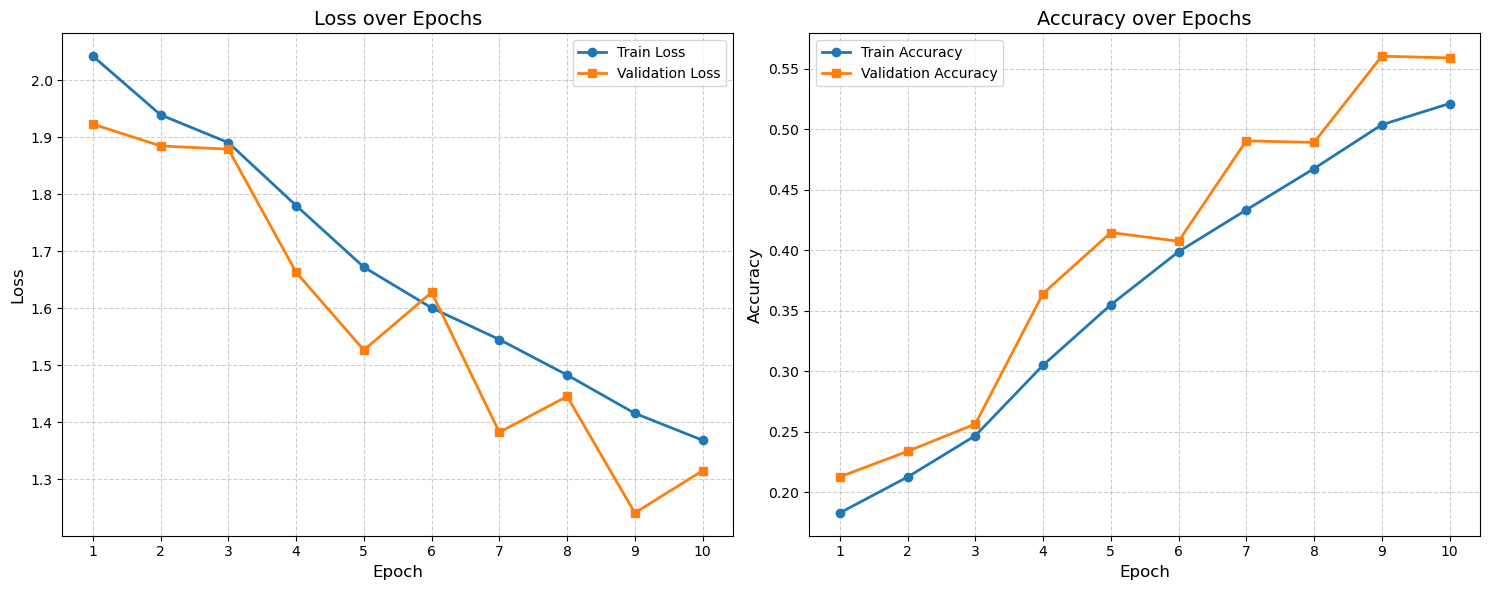

e_m_36_44_f_40 Acc:  0.57538


In [38]:
e_m_36_44_f_40 = Trainer(
  train_name="e_m_36_44_f_40",
  model_class=TinyVGG_E,
  train_transform=multi_scale_transform(s_min=36, s_max=44),
  test_transforms=[fix_scale_transform(s=40)]
)

e_m_36_44_f_40.train(epoch=10)

print(f"e_m_36_44_f_40 Acc: {e_m_36_44_f_40.evaluate(): .5f}")

### Additional 5 epochs of train (Total: 15)

Epoch:   11 | Train loss:  1.07856 | Train acc:  0.64905 | Val loss:  0.98824 | Val acc:  0.66514


Epoch:   12 | Train loss:  1.05911 | Train acc:  0.65731 | Val loss:  0.94015 | Val acc:  0.67911


Epoch:   13 | Train loss:  1.04037 | Train acc:  0.66439 | Val loss:  0.94655 | Val acc:  0.68520


Epoch:   14 | Train loss:  1.02244 | Train acc:  0.67155 | Val loss:  0.90006 | Val acc:  0.70248


Epoch:   15 | Train loss:  1.00029 | Train acc:  0.67788 | Val loss:  0.88309 | Val acc:  0.70517


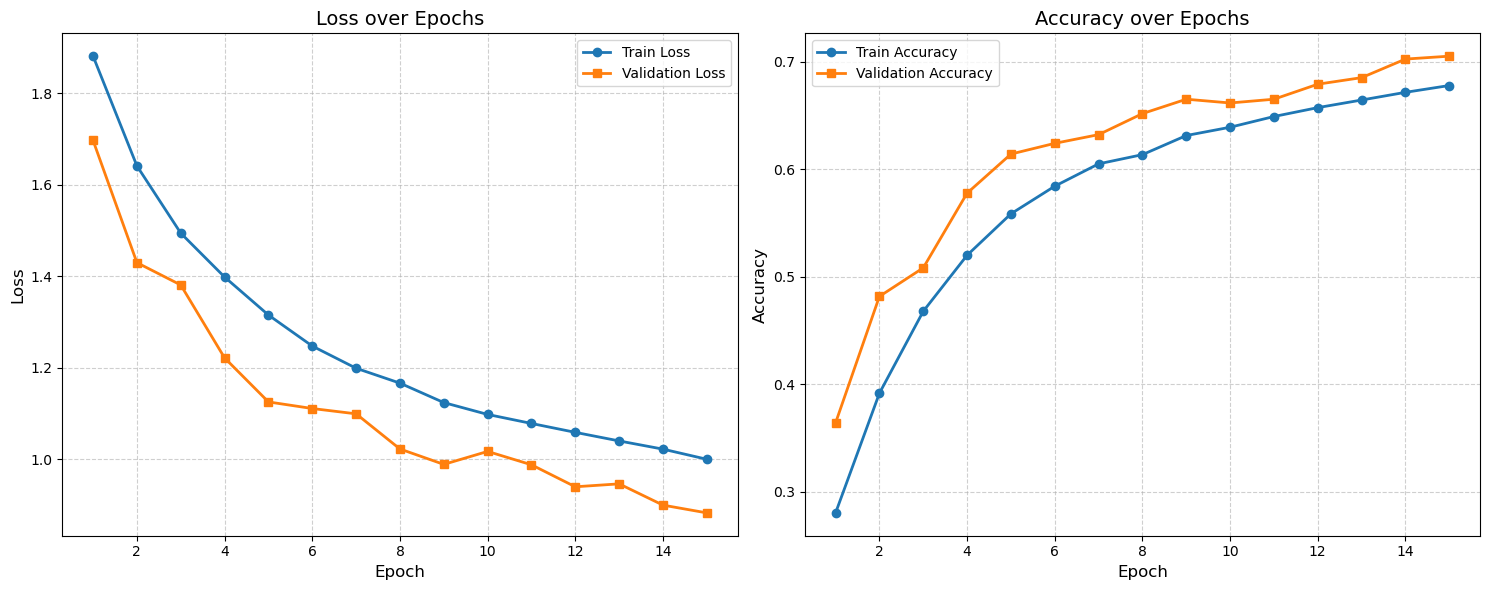

a_f_36_f_36 Acc:  0.72284


In [39]:
a_f_36_f_36.train(epoch=5)
print(f"a_f_36_f_36 Acc: {a_f_36_f_36.evaluate(): .5f}")

Epoch:   11 | Train loss:  0.97735 | Train acc:  0.68584 | Val loss:  0.85052 | Val acc:  0.71376


Epoch:   12 | Train loss:  0.95727 | Train acc:  0.69632 | Val loss:  0.86192 | Val acc:  0.71066


Epoch:   13 | Train loss:  0.93442 | Train acc:  0.70282 | Val loss:  0.83026 | Val acc:  0.72804


Epoch:   14 | Train loss:  0.91262 | Train acc:  0.70849 | Val loss:  0.84238 | Val acc:  0.72724


Epoch:   15 | Train loss:  0.89412 | Train acc:  0.71789 | Val loss:  0.80859 | Val acc:  0.72823


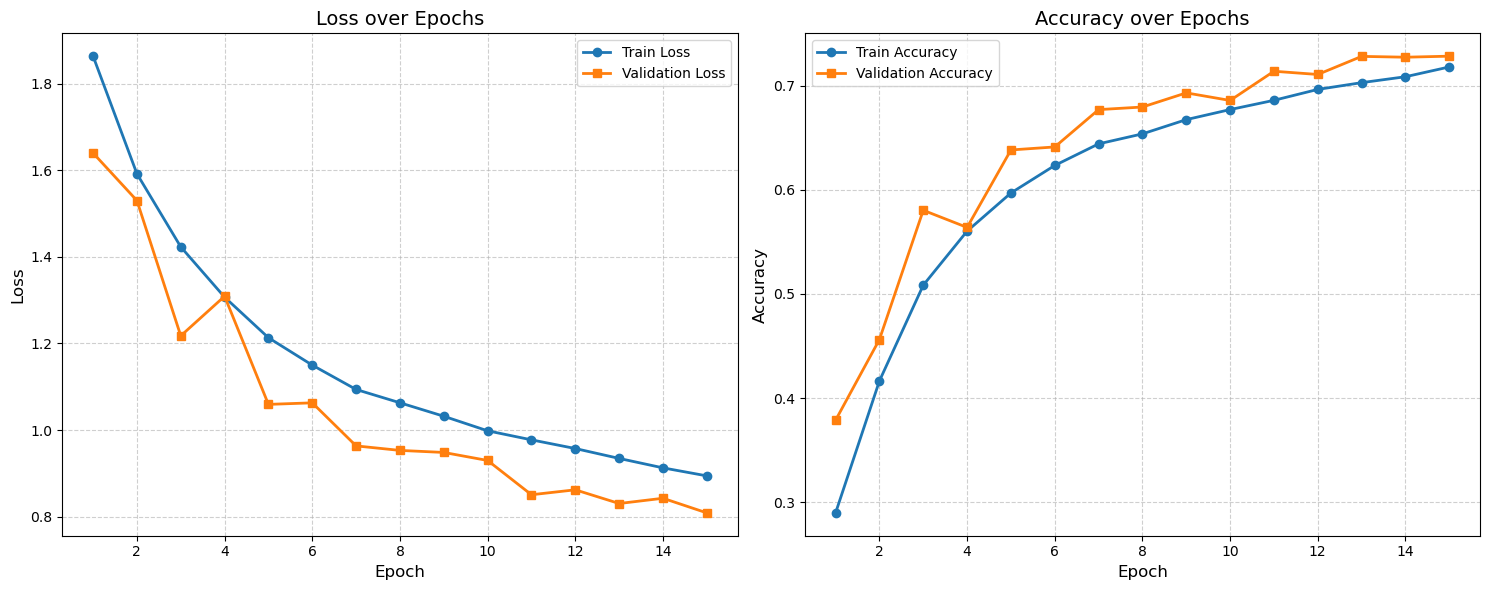

b_f_36_f_36 Acc:  0.75260


In [40]:
b_f_36_f_36.train(epoch=5)
print(f"b_f_36_f_36 Acc: {b_f_36_f_36.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.06757 | Train acc:  0.65211 | Val loss:  0.96896 | Val acc:  0.67332


Epoch:   12 | Train loss:  1.04375 | Train acc:  0.66159 | Val loss:  0.92457 | Val acc:  0.68540


Epoch:   13 | Train loss:  1.01722 | Train acc:  0.66799 | Val loss:  0.95703 | Val acc:  0.68151


Epoch:   14 | Train loss:  0.99441 | Train acc:  0.67788 | Val loss:  0.89760 | Val acc:  0.70038


Epoch:   15 | Train loss:  0.98762 | Train acc:  0.68046 | Val loss:  0.90345 | Val acc:  0.70747


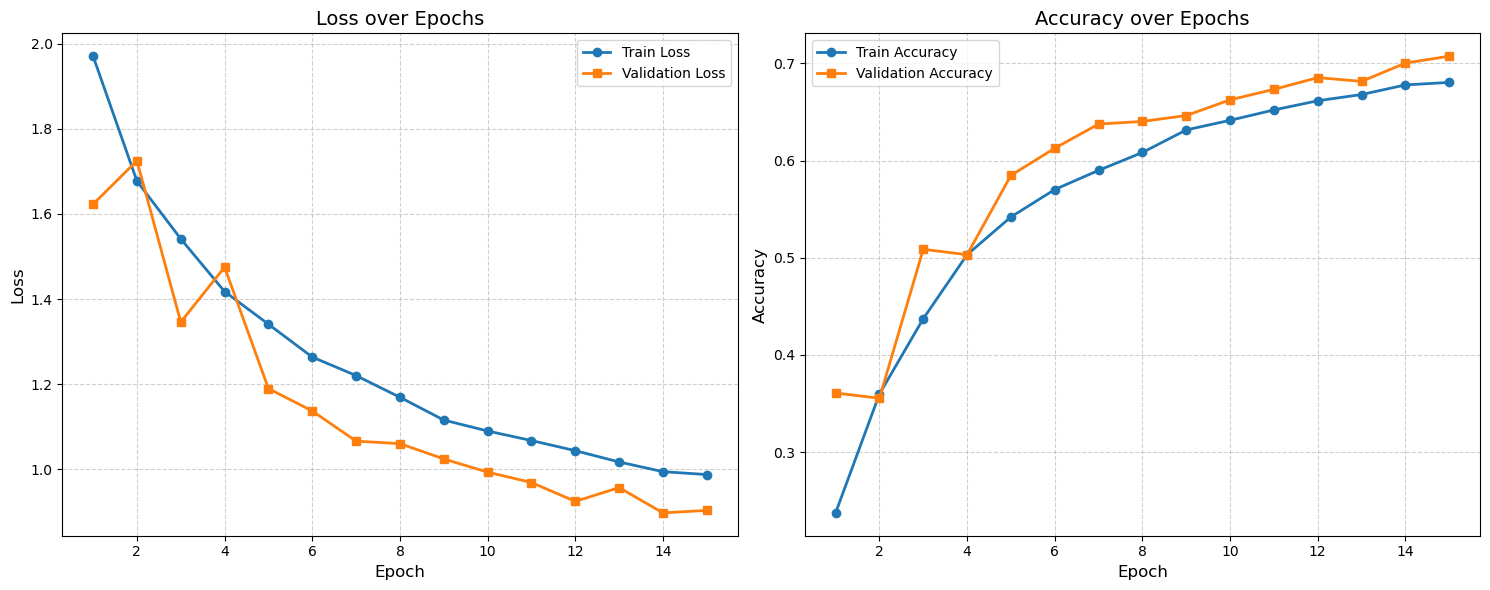

c_f_36_f_36 Acc:  0.72724


In [41]:
c_f_36_f_36.train(epoch=5)
print(f"c_f_36_f_36 Acc: {c_f_36_f_36.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.18291 | Train acc:  0.60984 | Val loss:  1.04431 | Val acc:  0.64806


Epoch:   12 | Train loss:  1.15516 | Train acc:  0.61800 | Val loss:  1.03260 | Val acc:  0.64257


Epoch:   13 | Train loss:  1.12833 | Train acc:  0.62574 | Val loss:  1.02838 | Val acc:  0.64886


Epoch:   14 | Train loss:  1.11770 | Train acc:  0.63084 | Val loss:  1.00160 | Val acc:  0.65545


Epoch:   15 | Train loss:  1.09420 | Train acc:  0.64121 | Val loss:  0.97662 | Val acc:  0.66514


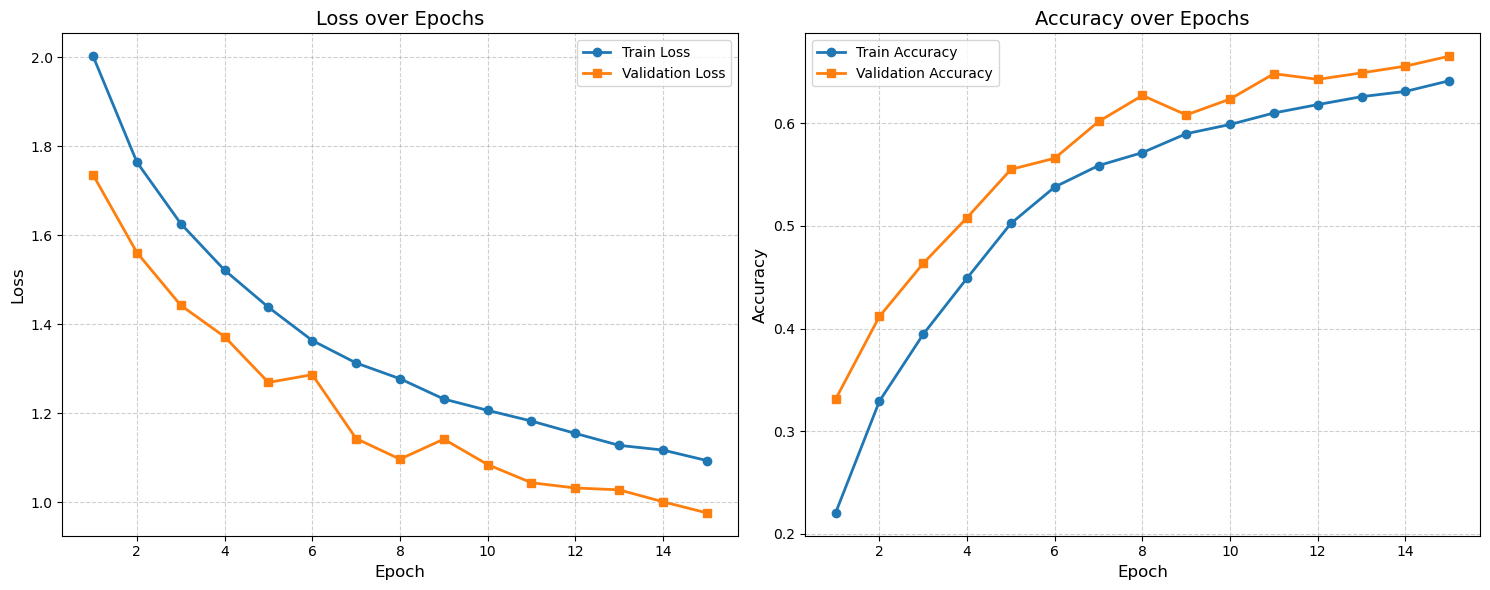

c_f_40_f_40 Acc:  0.69499


In [42]:
c_f_40_f_40.train(epoch=5)
print(f"c_f_40_f_40 Acc: {c_f_40_f_40.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.18288 | Train acc:  0.60397 | Val loss:  1.10281 | Val acc:  0.62420


Epoch:   12 | Train loss:  1.15305 | Train acc:  0.61760 | Val loss:  1.04942 | Val acc:  0.63329


Epoch:   13 | Train loss:  1.13351 | Train acc:  0.62354 | Val loss:  1.01502 | Val acc:  0.65615


Epoch:   14 | Train loss:  1.10643 | Train acc:  0.63566 | Val loss:  0.99457 | Val acc:  0.66014


Epoch:   15 | Train loss:  1.08882 | Train acc:  0.64129 | Val loss:  0.93846 | Val acc:  0.67981


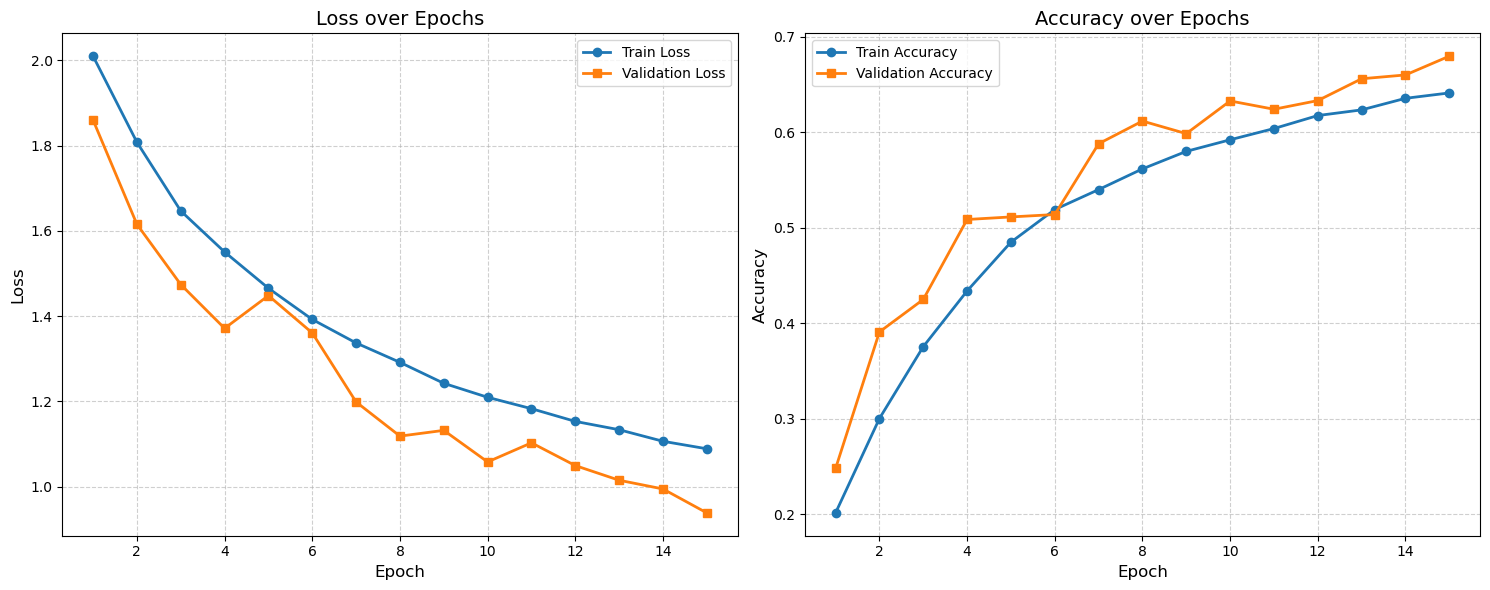

c_m_36_44_f_40 Acc:  0.71226


In [43]:
c_m_36_44_f_40.train(epoch=5)
print(f"c_m_36_44_f_40 Acc: {c_m_36_44_f_40.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.02807 | Train acc:  0.66231 | Val loss:  0.92913 | Val acc:  0.69040


Epoch:   12 | Train loss:  1.00899 | Train acc:  0.67280 | Val loss:  0.93312 | Val acc:  0.69020


Epoch:   13 | Train loss:  0.98419 | Train acc:  0.67948 | Val loss:  1.04859 | Val acc:  0.66174


Epoch:   14 | Train loss:  0.96475 | Train acc:  0.69034 | Val loss:  0.90714 | Val acc:  0.69708


Epoch:   15 | Train loss:  0.94707 | Train acc:  0.69498 | Val loss:  0.83080 | Val acc:  0.71895


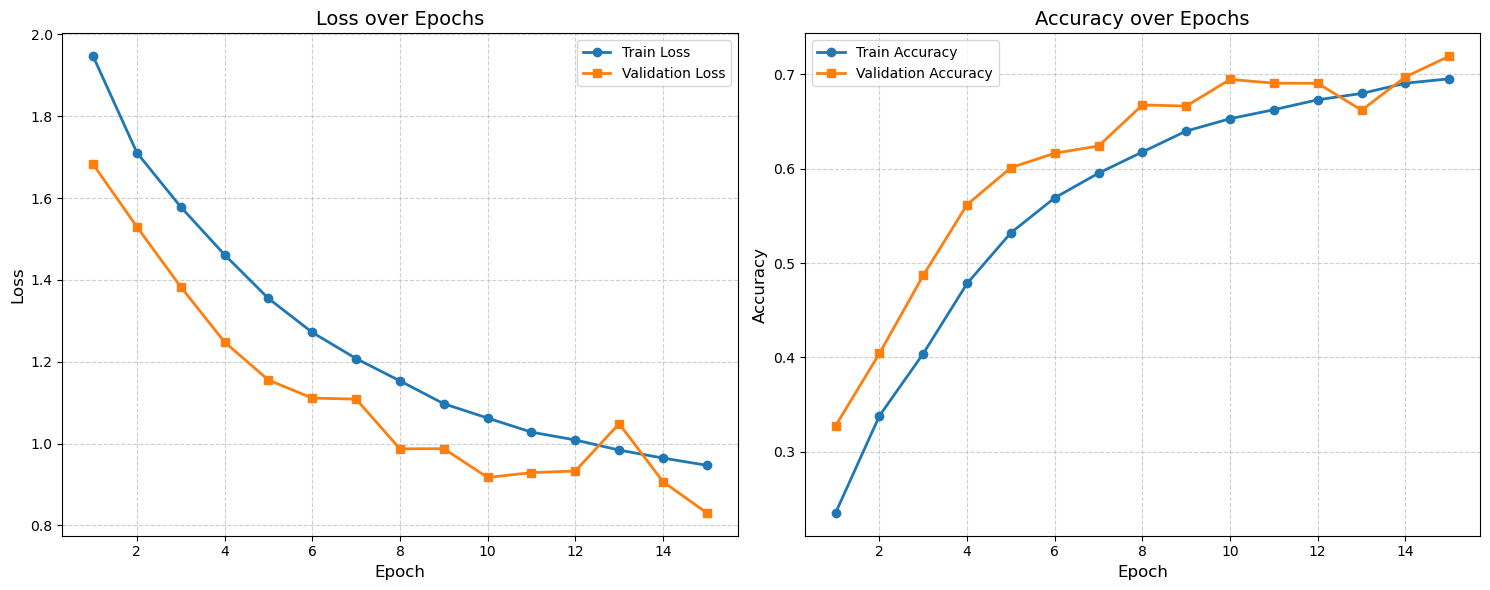

d_f_36_f_36 Acc:  0.73902


In [44]:
d_f_36_f_36.train(epoch=5)
print(f"d_f_36_f_36 Acc: {d_f_36_f_36.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.16819 | Train acc:  0.61006 | Val loss:  1.05252 | Val acc:  0.63858


Epoch:   12 | Train loss:  1.14237 | Train acc:  0.61928 | Val loss:  1.01850 | Val acc:  0.64427


Epoch:   13 | Train loss:  1.10715 | Train acc:  0.63348 | Val loss:  1.02269 | Val acc:  0.65335


Epoch:   14 | Train loss:  1.08816 | Train acc:  0.63946 | Val loss:  0.97811 | Val acc:  0.66793


Epoch:   15 | Train loss:  1.06573 | Train acc:  0.64729 | Val loss:  0.96266 | Val acc:  0.67622


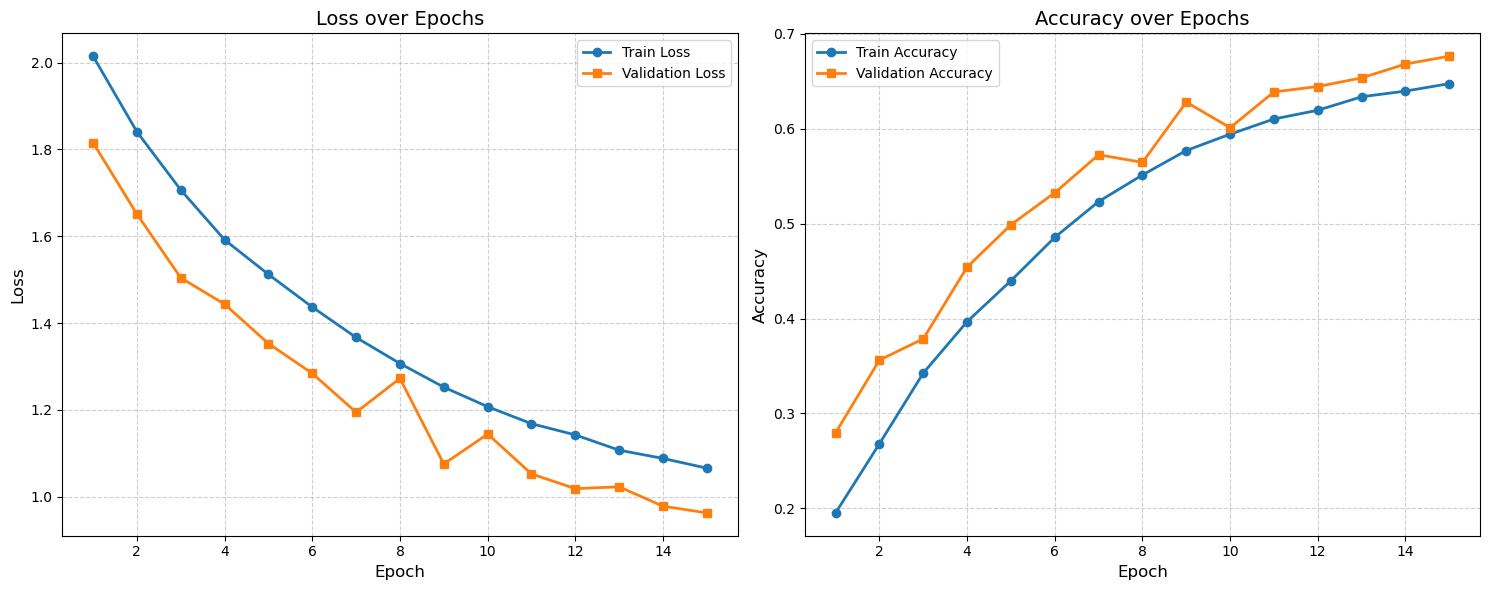

d_f_40_f_40 Acc:  0.70417


In [45]:
d_f_40_f_40.train(epoch=5)
print(f"d_f_40_f_40 Acc: {d_f_40_f_40.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.14230 | Train acc:  0.62566 | Val loss:  1.01010 | Val acc:  0.65355


Epoch:   12 | Train loss:  1.11120 | Train acc:  0.63604 | Val loss:  0.97817 | Val acc:  0.66703


Epoch:   13 | Train loss:  1.09143 | Train acc:  0.64167 | Val loss:  0.95870 | Val acc:  0.67412


Epoch:   14 | Train loss:  1.06642 | Train acc:  0.65249 | Val loss:  0.95238 | Val acc:  0.67871


Epoch:   15 | Train loss:  1.05622 | Train acc:  0.65561 | Val loss:  0.88956 | Val acc:  0.69848


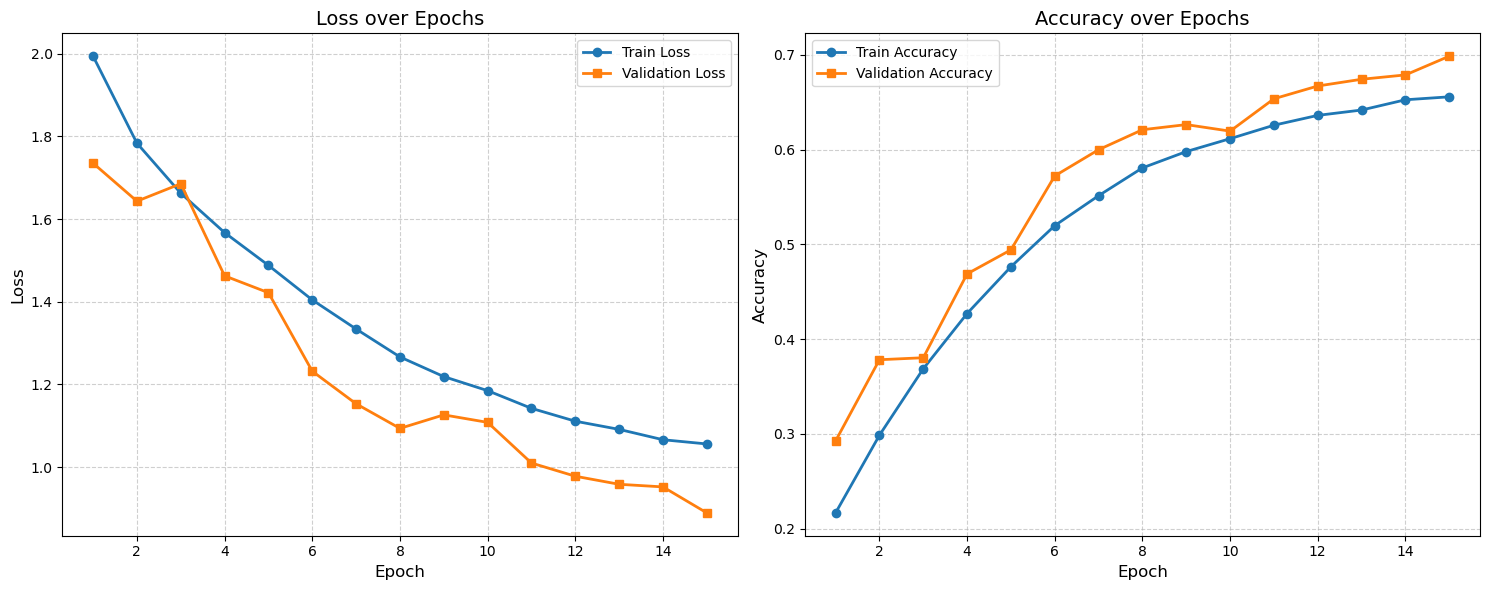

d_m_36_44_f_40 Acc:  0.72194


In [46]:
d_m_36_44_f_40.train(epoch=5)
print(f"d_m_36_44_f_40 Acc: {d_m_36_44_f_40.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.17246 | Train acc:  0.60531 | Val loss:  1.14377 | Val acc:  0.61072


Epoch:   12 | Train loss:  1.14369 | Train acc:  0.61982 | Val loss:  1.00808 | Val acc:  0.66374


Epoch:   13 | Train loss:  1.10091 | Train acc:  0.63440 | Val loss:  0.98299 | Val acc:  0.65375


Epoch:   14 | Train loss:  1.07334 | Train acc:  0.64397 | Val loss:  0.92645 | Val acc:  0.68770


Epoch:   15 | Train loss:  1.05801 | Train acc:  0.65205 | Val loss:  0.95811 | Val acc:  0.67212


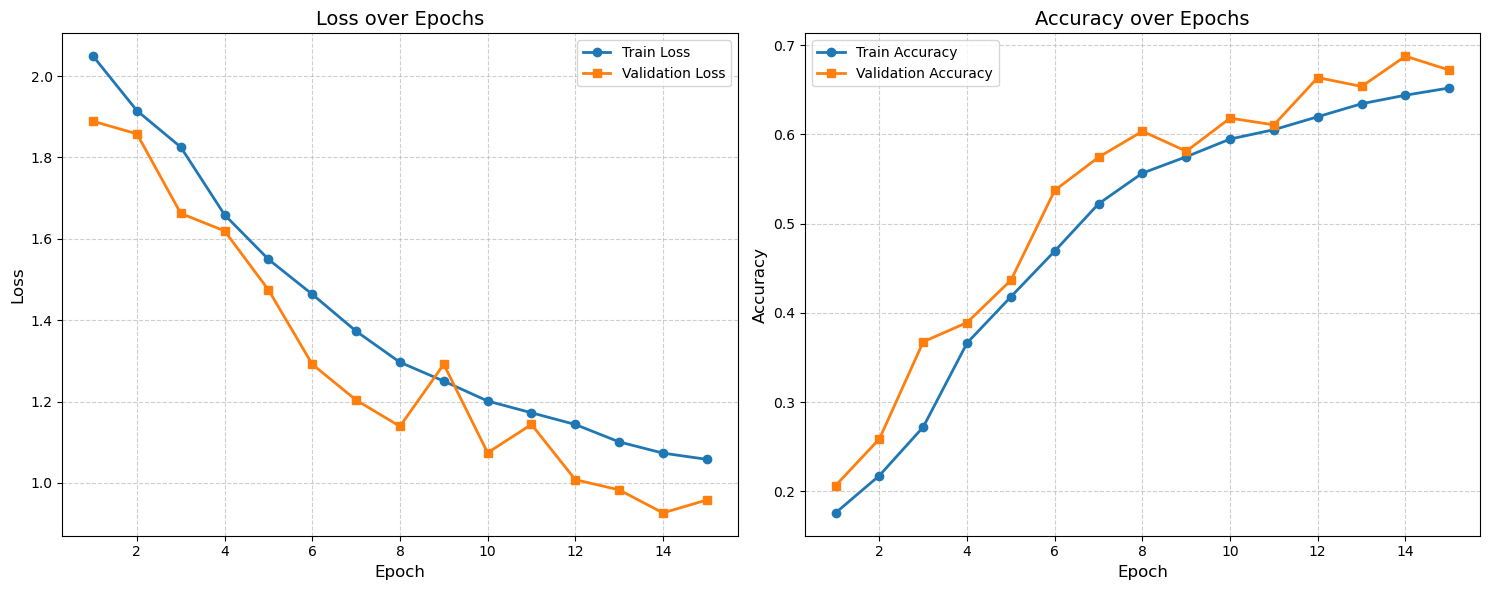

e_f_36_f_36 Acc:  0.69798


In [47]:
e_f_36_f_36.train(epoch=5)
print(f"e_f_36_f_36 Acc: {e_f_36_f_36.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.33539 | Train acc:  0.53933 | Val loss:  1.20100 | Val acc:  0.56779


Epoch:   12 | Train loss:  1.29932 | Train acc:  0.55176 | Val loss:  1.33012 | Val acc:  0.53255


Epoch:   13 | Train loss:  1.27679 | Train acc:  0.56396 | Val loss:  1.19999 | Val acc:  0.59215


Epoch:   14 | Train loss:  1.24134 | Train acc:  0.57798 | Val loss:  1.09722 | Val acc:  0.62939


Epoch:   15 | Train loss:  1.21473 | Train acc:  0.59345 | Val loss:  1.08685 | Val acc:  0.62350


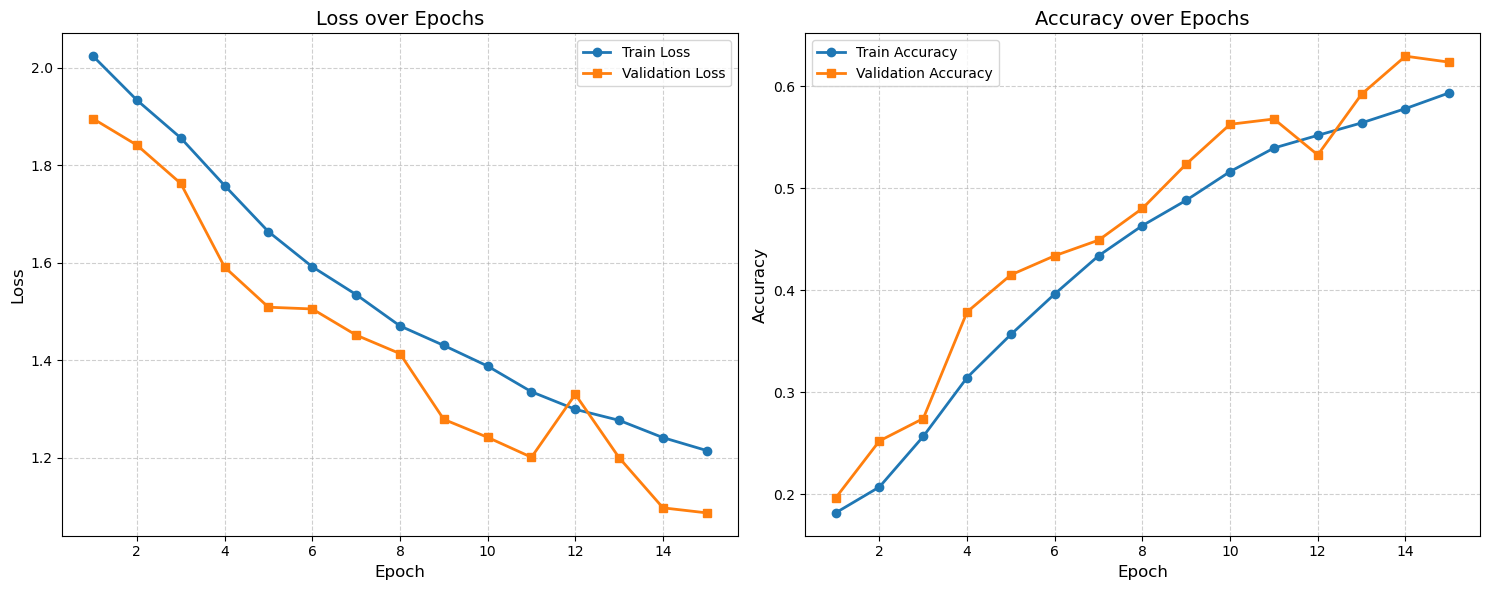

e_f_40_f_40 Acc:  0.64886


In [48]:
e_f_40_f_40.train(epoch=5)
print(f"e_f_40_f_40 Acc: {e_f_40_f_40.evaluate(): .5f}")

Epoch:   11 | Train loss:  1.32298 | Train acc:  0.54685 | Val loss:  1.23865 | Val acc:  0.57438


Epoch:   12 | Train loss:  1.28506 | Train acc:  0.56130 | Val loss:  1.12057 | Val acc:  0.61062


Epoch:   13 | Train loss:  1.25482 | Train acc:  0.57408 | Val loss:  1.12012 | Val acc:  0.61522


Epoch:   14 | Train loss:  1.22819 | Train acc:  0.58715 | Val loss:  1.08802 | Val acc:  0.63379


Epoch:   15 | Train loss:  1.20742 | Train acc:  0.59373 | Val loss:  1.11521 | Val acc:  0.62001


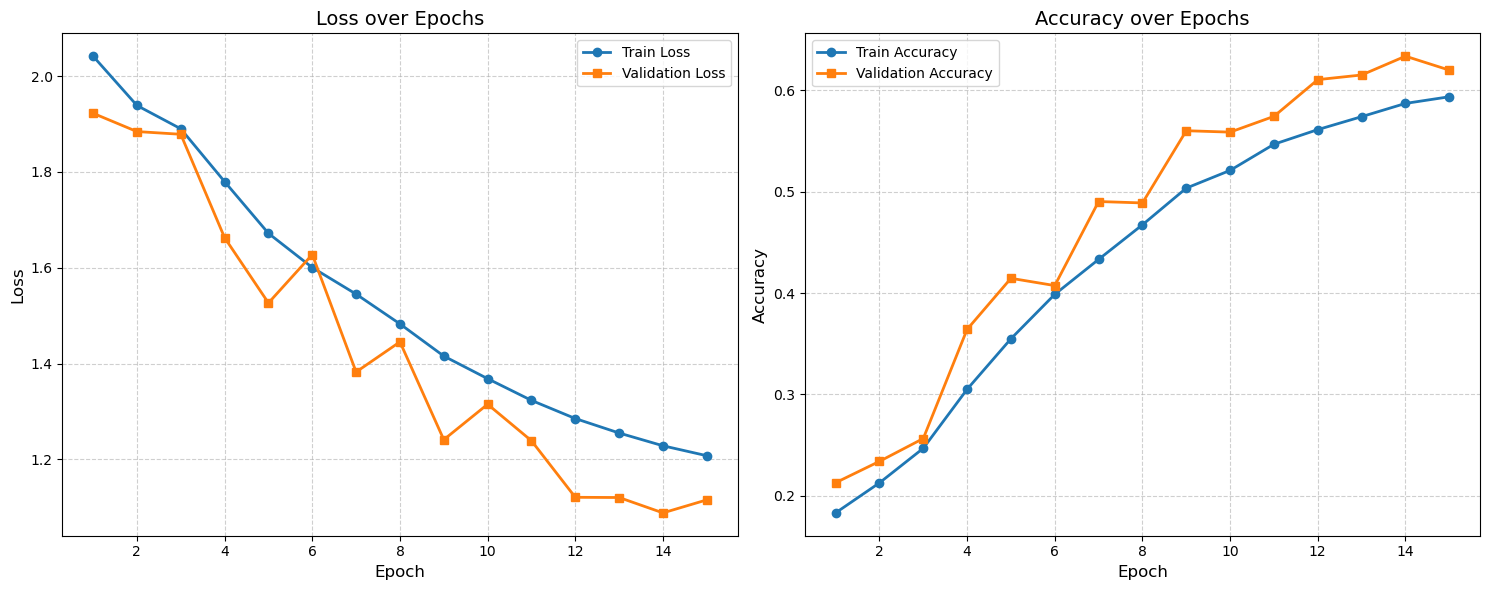

e_m_36_44_f_40 Acc:  0.64716


In [49]:
e_m_36_44_f_40.train(epoch=5)
print(f"e_m_36_44_f_40 Acc: {e_m_36_44_f_40.evaluate(): .5f}")

In [ ]:
trainers = [
  a_f_36_f_36,
  b_f_36_f_36,
  c_f_36_f_36,
  c_f_40_f_40,
  c_m_36_44_f_40,
  d_f_36_f_36,
  d_f_40_f_40,
  d_m_36_44_f_40,
  e_f_36_f_36,
  e_f_40_f_40,
  e_m_36_44_f_40,
]

for trainer in trainers:
  trainer.checkout()

### Additional 5 epochs of train (Total: 20)

Epoch:   16 | Train loss:  0.99351 | Train acc:  0.68206 | Val loss:  0.91861 | Val acc:  0.69209


Epoch:   17 | Train loss:  0.98564 | Train acc:  0.68624 | Val loss:  0.87212 | Val acc:  0.71436


Epoch:   18 | Train loss:  0.97024 | Train acc:  0.68958 | Val loss:  0.90407 | Val acc:  0.69828


Epoch:   19 | Train loss:  0.95461 | Train acc:  0.69604 | Val loss:  0.86664 | Val acc:  0.70527


Epoch:   20 | Train loss:  0.94616 | Train acc:  0.70054 | Val loss:  0.86969 | Val acc:  0.71006


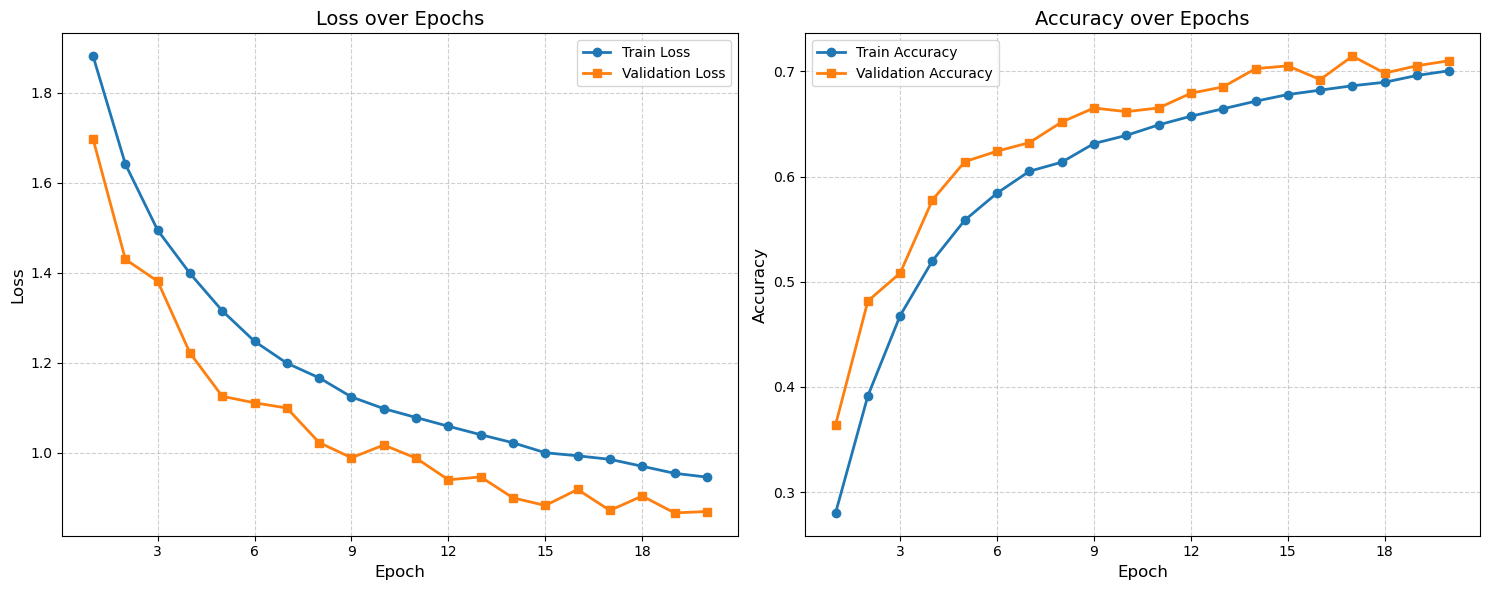

a_f_36_f_36 Acc:  0.74671


In [52]:
a_f_36_f_36.train(epoch=5)
print(f"a_f_36_f_36 Acc: {a_f_36_f_36.evaluate(): .5f}")

Epoch:   16 | Train loss:  0.88297 | Train acc:  0.72225 | Val loss:  0.82157 | Val acc:  0.72943


Epoch:   17 | Train loss:  0.87395 | Train acc:  0.72535 | Val loss:  0.78937 | Val acc:  0.73552


Epoch:   18 | Train loss:  0.86150 | Train acc:  0.72871 | Val loss:  0.76574 | Val acc:  0.74591


Epoch:   19 | Train loss:  0.85072 | Train acc:  0.73173 | Val loss:  0.75413 | Val acc:  0.75260


Epoch:   20 | Train loss:  0.83690 | Train acc:  0.73728 | Val loss:  0.77516 | Val acc:  0.75110


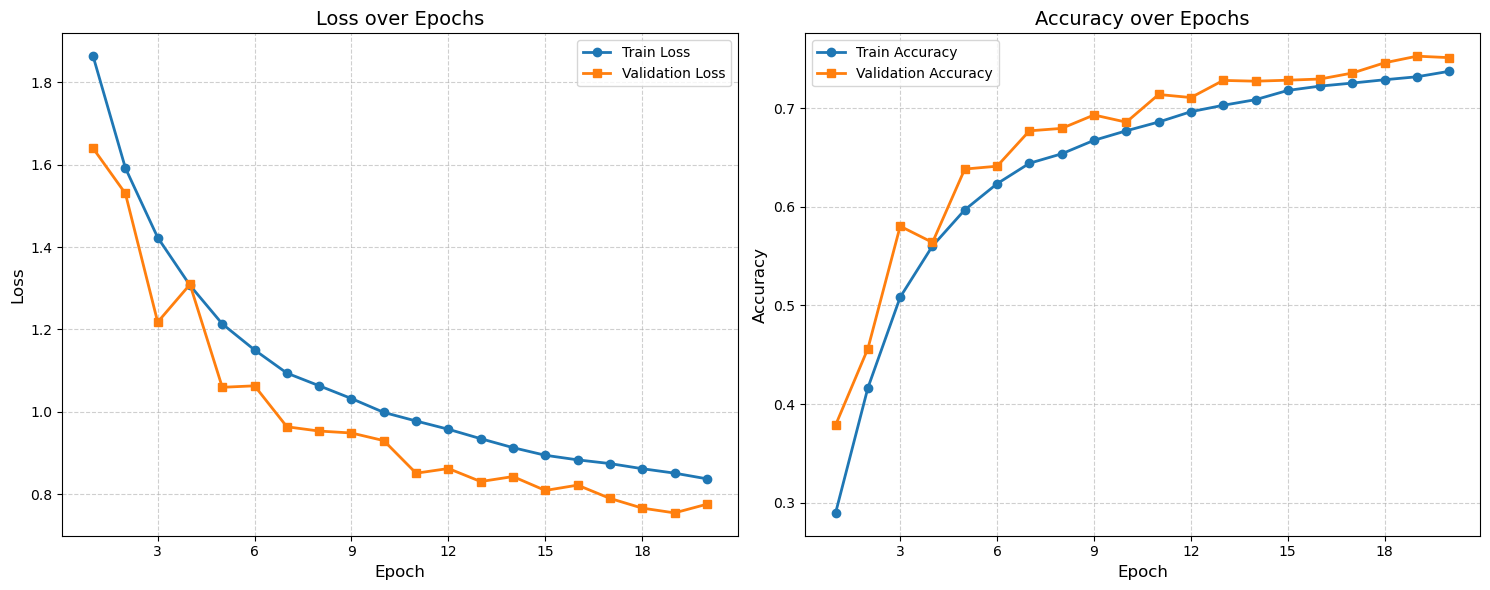

b_f_36_f_36 Acc:  0.77596


In [53]:
b_f_36_f_36.train(epoch=5)
print(f"b_f_36_f_36 Acc: {b_f_36_f_36.evaluate(): .5f}")

Epoch:   16 | Train loss:  0.95826 | Train acc:  0.68952 | Val loss:  0.86561 | Val acc:  0.71715


Epoch:   17 | Train loss:  0.95265 | Train acc:  0.69580 | Val loss:  0.86452 | Val acc:  0.71695


Epoch:   18 | Train loss:  0.93444 | Train acc:  0.69866 | Val loss:  0.83470 | Val acc:  0.72654


Epoch:   19 | Train loss:  0.92682 | Train acc:  0.70381 | Val loss:  0.86214 | Val acc:  0.71146


Epoch:   20 | Train loss:  0.91558 | Train acc:  0.70721 | Val loss:  0.85650 | Val acc:  0.71845


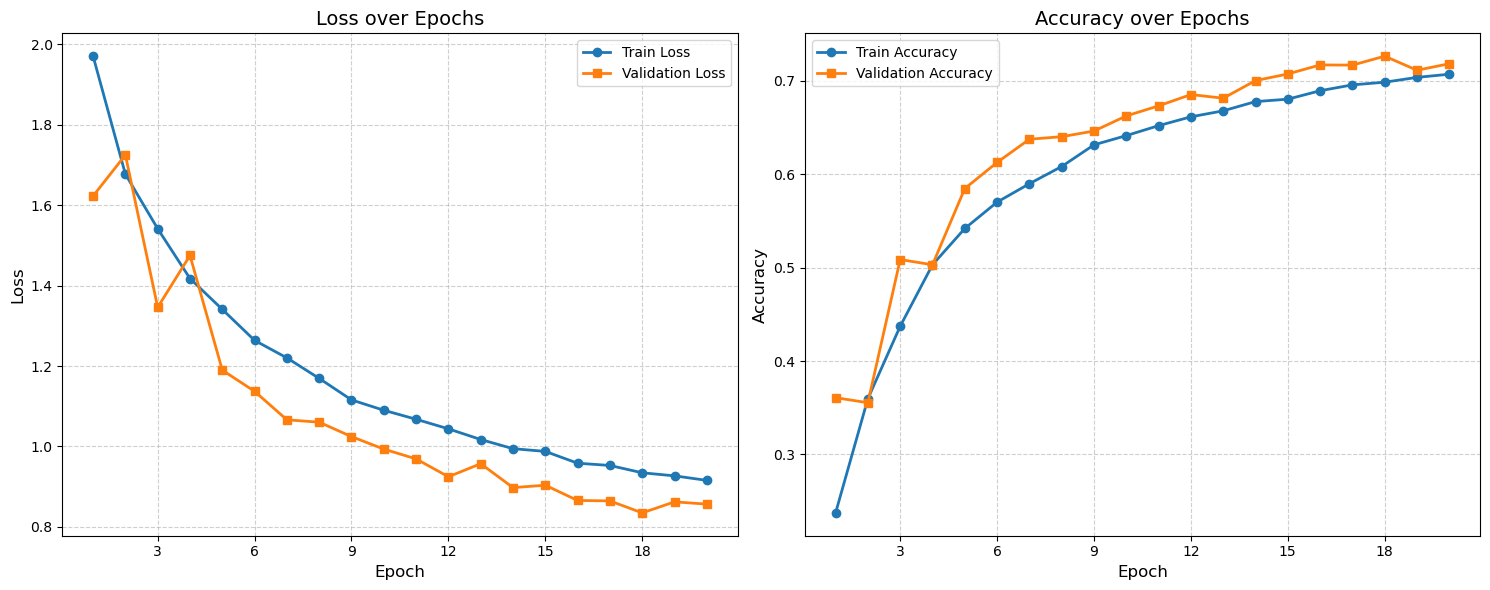

c_f_36_f_36 Acc:  0.73802


In [54]:
c_f_36_f_36.train(epoch=5)
print(f"c_f_36_f_36 Acc: {c_f_36_f_36.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.07211 | Train acc:  0.64723 | Val loss:  0.97093 | Val acc:  0.66853


Epoch:   17 | Train loss:  1.05804 | Train acc:  0.65265 | Val loss:  0.94605 | Val acc:  0.67961


Epoch:   18 | Train loss:  1.04456 | Train acc:  0.65875 | Val loss:  0.95489 | Val acc:  0.67143


Epoch:   19 | Train loss:  1.04136 | Train acc:  0.65825 | Val loss:  0.96846 | Val acc:  0.66444


Epoch:   20 | Train loss:  1.03206 | Train acc:  0.66367 | Val loss:  0.89833 | Val acc:  0.69189


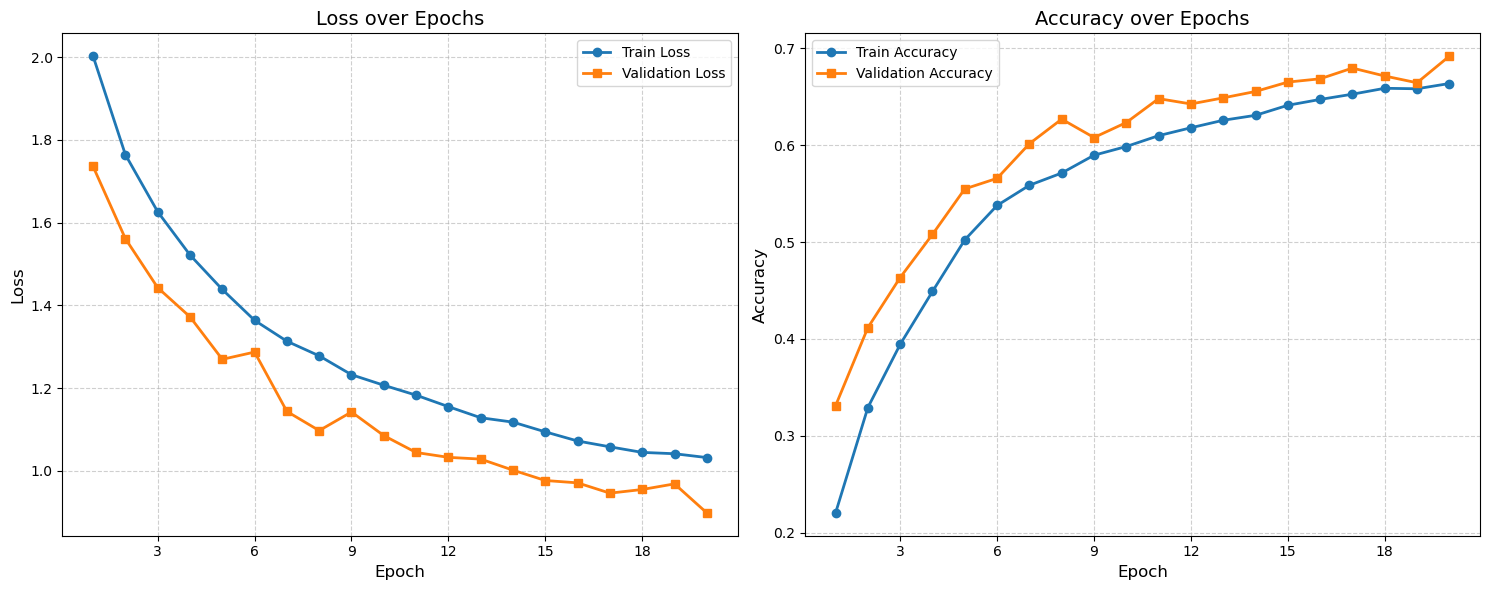

c_f_40_f_40 Acc:  0.72264


In [55]:
c_f_40_f_40.train(epoch=5)
print(f"c_f_40_f_40 Acc: {c_f_40_f_40.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.07857 | Train acc:  0.64423 | Val loss:  1.03899 | Val acc:  0.64427


Epoch:   17 | Train loss:  1.05832 | Train acc:  0.65207 | Val loss:  0.92247 | Val acc:  0.68760


Epoch:   18 | Train loss:  1.04489 | Train acc:  0.65695 | Val loss:  0.99049 | Val acc:  0.67442


Epoch:   19 | Train loss:  1.02432 | Train acc:  0.66193 | Val loss:  0.92182 | Val acc:  0.68291


Epoch:   20 | Train loss:  1.02585 | Train acc:  0.66949 | Val loss:  0.90048 | Val acc:  0.69778


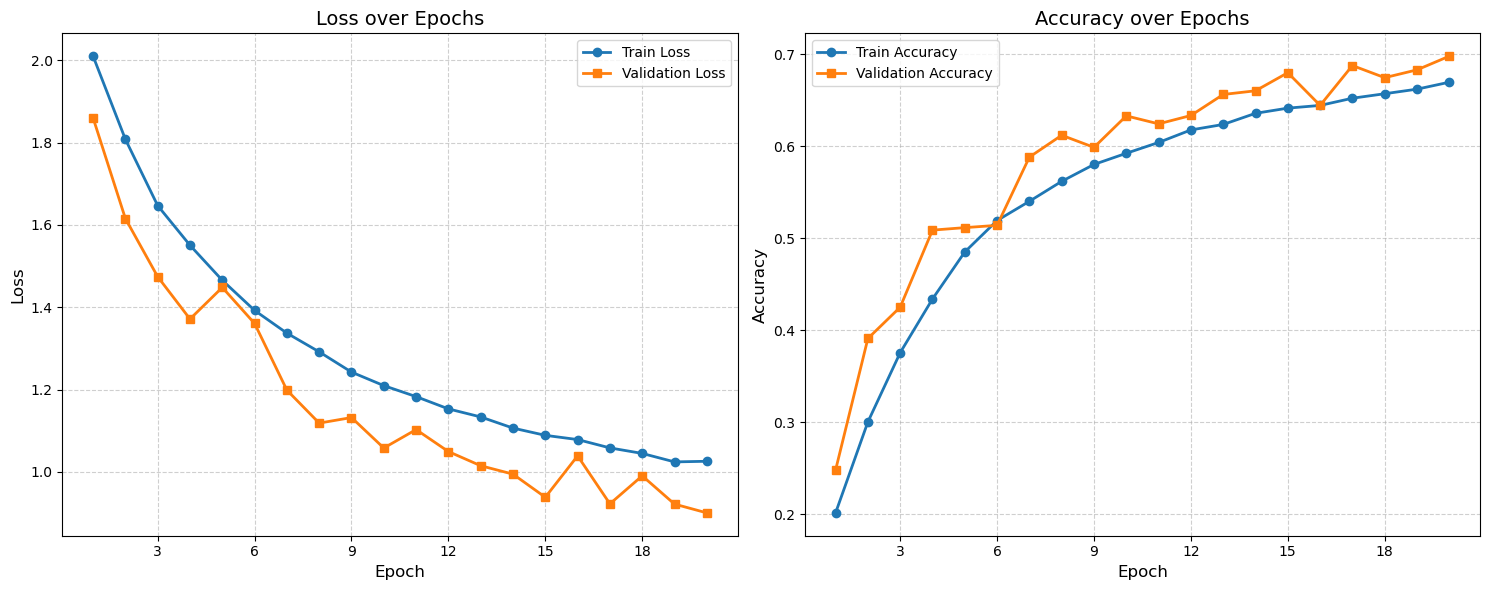

c_m_36_44_f_40 Acc:  0.72534


In [56]:
c_m_36_44_f_40.train(epoch=5)
print(f"c_m_36_44_f_40 Acc: {c_m_36_44_f_40.evaluate(): .5f}")

Epoch:   16 | Train loss:  0.92664 | Train acc:  0.70006 | Val loss:  0.84261 | Val acc:  0.72604


Epoch:   17 | Train loss:  0.91377 | Train acc:  0.70679 | Val loss:  0.83529 | Val acc:  0.72993


Epoch:   18 | Train loss:  0.89246 | Train acc:  0.71527 | Val loss:  0.85007 | Val acc:  0.72584


Epoch:   19 | Train loss:  0.89126 | Train acc:  0.71685 | Val loss:  0.79375 | Val acc:  0.73892


Epoch:   20 | Train loss:  0.86975 | Train acc:  0.72105 | Val loss:  0.79984 | Val acc:  0.74181


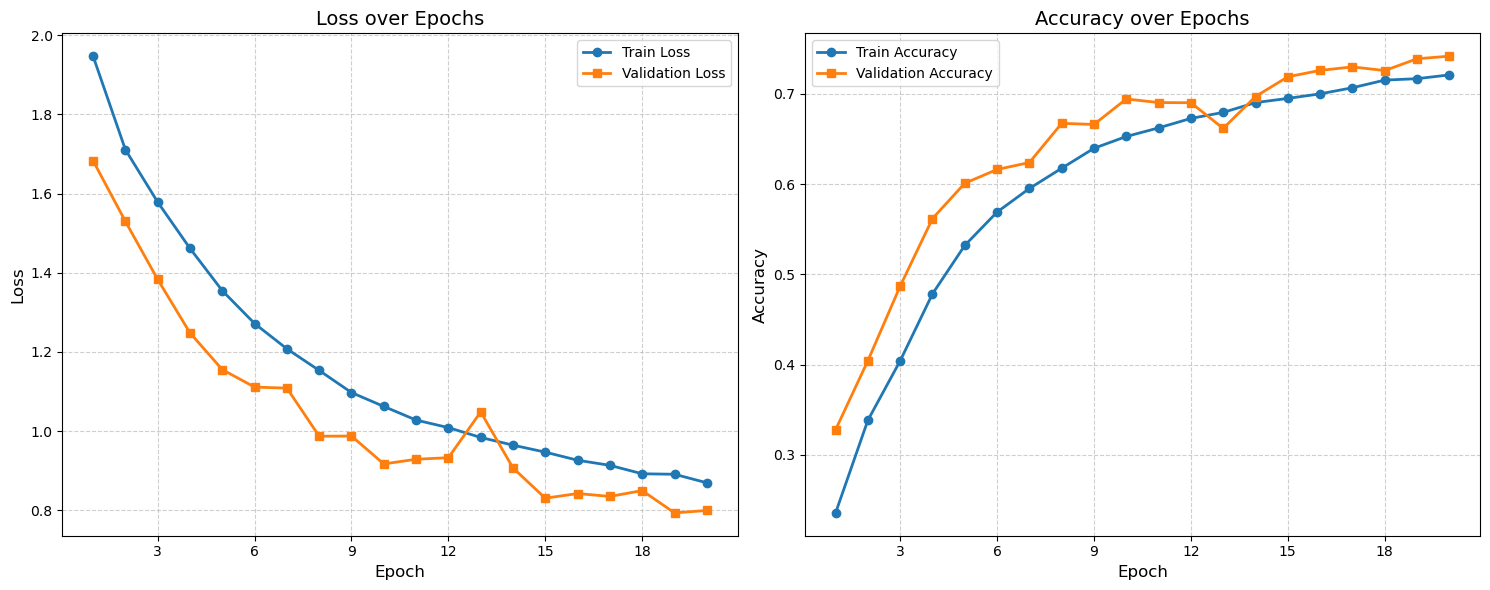

d_f_36_f_36 Acc:  0.75529


In [57]:
d_f_36_f_36.train(epoch=5)
print(f"d_f_36_f_36 Acc: {d_f_36_f_36.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.04745 | Train acc:  0.65627 | Val loss:  0.95123 | Val acc:  0.67562


Epoch:   17 | Train loss:  1.03447 | Train acc:  0.66299 | Val loss:  0.95955 | Val acc:  0.67512


Epoch:   18 | Train loss:  1.02229 | Train acc:  0.66767 | Val loss:  0.89920 | Val acc:  0.69000


Epoch:   19 | Train loss:  1.00301 | Train acc:  0.67304 | Val loss:  0.88477 | Val acc:  0.70427


Epoch:   20 | Train loss:  0.99042 | Train acc:  0.67938 | Val loss:  0.89346 | Val acc:  0.70128


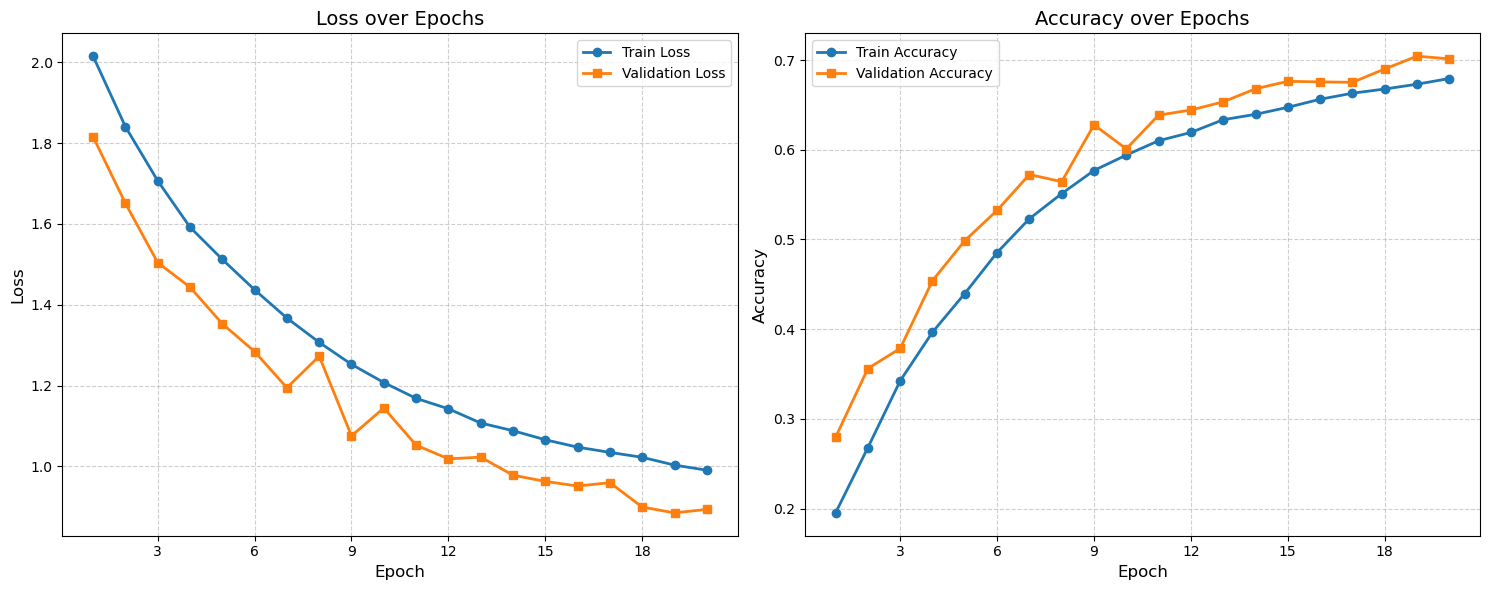

d_f_40_f_40 Acc:  0.73073


In [58]:
d_f_40_f_40.train(epoch=5)
print(f"d_f_40_f_40 Acc: {d_f_40_f_40.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.03759 | Train acc:  0.66535 | Val loss:  0.92753 | Val acc:  0.68940


Epoch:   17 | Train loss:  1.01418 | Train acc:  0.67097 | Val loss:  0.90686 | Val acc:  0.69279


Epoch:   18 | Train loss:  1.01279 | Train acc:  0.67027 | Val loss:  0.88779 | Val acc:  0.70128


Epoch:   19 | Train loss:  0.99351 | Train acc:  0.68094 | Val loss:  0.86116 | Val acc:  0.71246


Epoch:   20 | Train loss:  0.97598 | Train acc:  0.68496 | Val loss:  0.95174 | Val acc:  0.68960


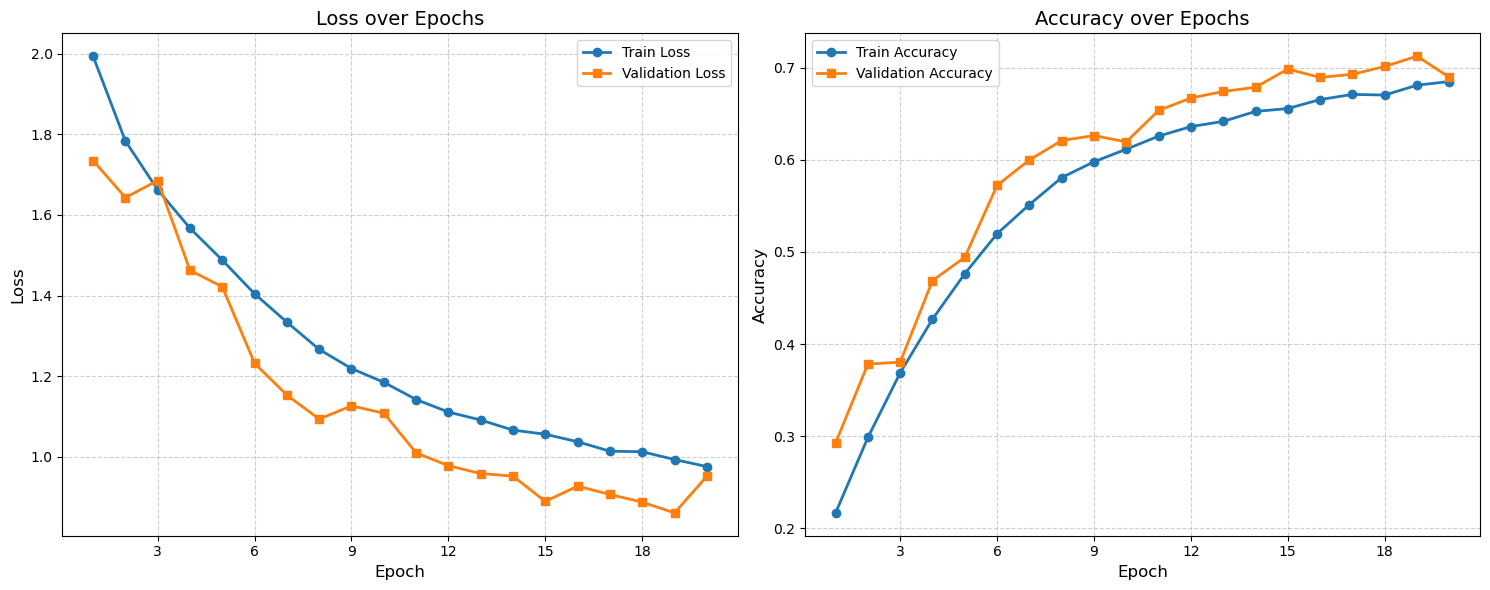

d_m_36_44_f_40 Acc:  0.71066


In [59]:
d_m_36_44_f_40.train(epoch=5)
print(f"d_m_36_44_f_40 Acc: {d_m_36_44_f_40.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.04119 | Train acc:  0.65965 | Val loss:  0.94296 | Val acc:  0.68041


Epoch:   17 | Train loss:  1.02126 | Train acc:  0.66377 | Val loss:  0.92020 | Val acc:  0.69000


Epoch:   18 | Train loss:  0.99934 | Train acc:  0.67320 | Val loss:  0.92258 | Val acc:  0.69319


Epoch:   19 | Train loss:  0.98551 | Train acc:  0.68128 | Val loss:  0.87571 | Val acc:  0.70308


Epoch:   20 | Train loss:  0.96704 | Train acc:  0.68284 | Val loss:  0.86611 | Val acc:  0.70907


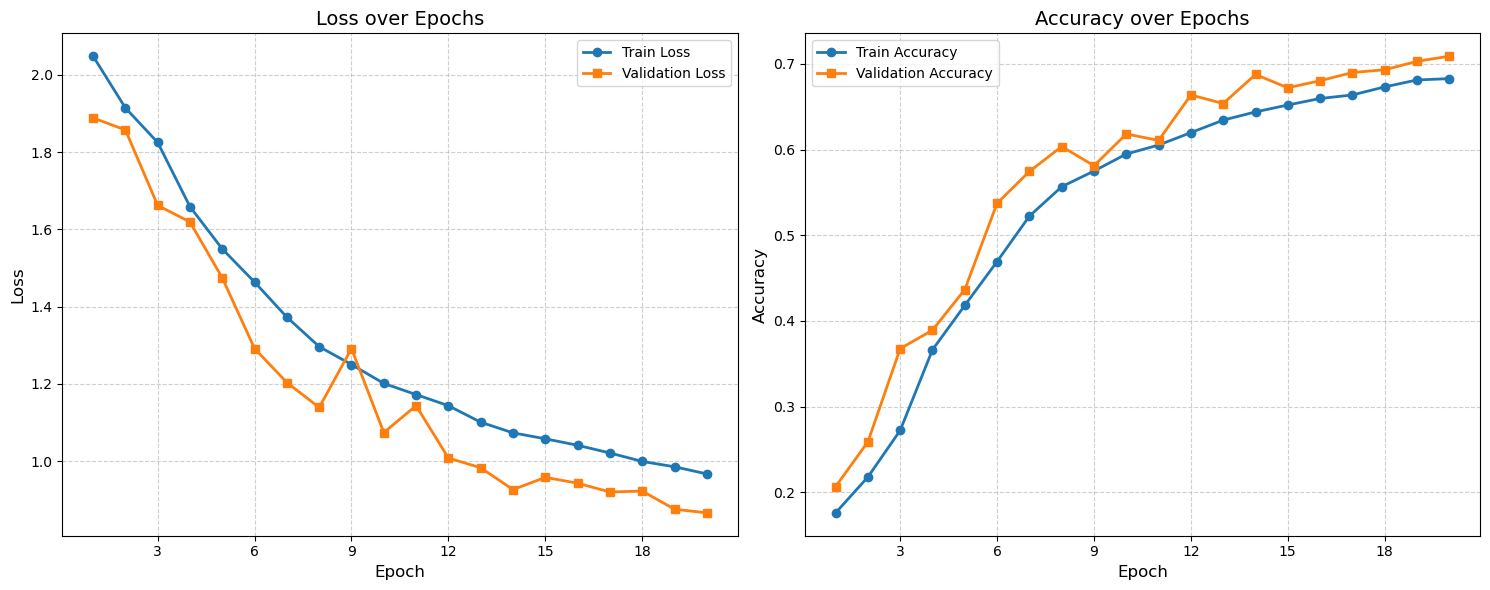

e_f_36_f_36 Acc:  0.73133


In [60]:
e_f_36_f_36.train(epoch=5)
print(f"e_f_36_f_36 Acc: {e_f_36_f_36.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.18378 | Train acc:  0.60281 | Val loss:  1.07034 | Val acc:  0.63758


Epoch:   17 | Train loss:  1.16493 | Train acc:  0.60917 | Val loss:  1.05386 | Val acc:  0.64177


Epoch:   18 | Train loss:  1.15832 | Train acc:  0.61632 | Val loss:  1.05432 | Val acc:  0.64058


Epoch:   19 | Train loss:  1.12364 | Train acc:  0.62796 | Val loss:  1.03206 | Val acc:  0.64177


Epoch:   20 | Train loss:  1.10750 | Train acc:  0.63316 | Val loss:  1.03177 | Val acc:  0.65056


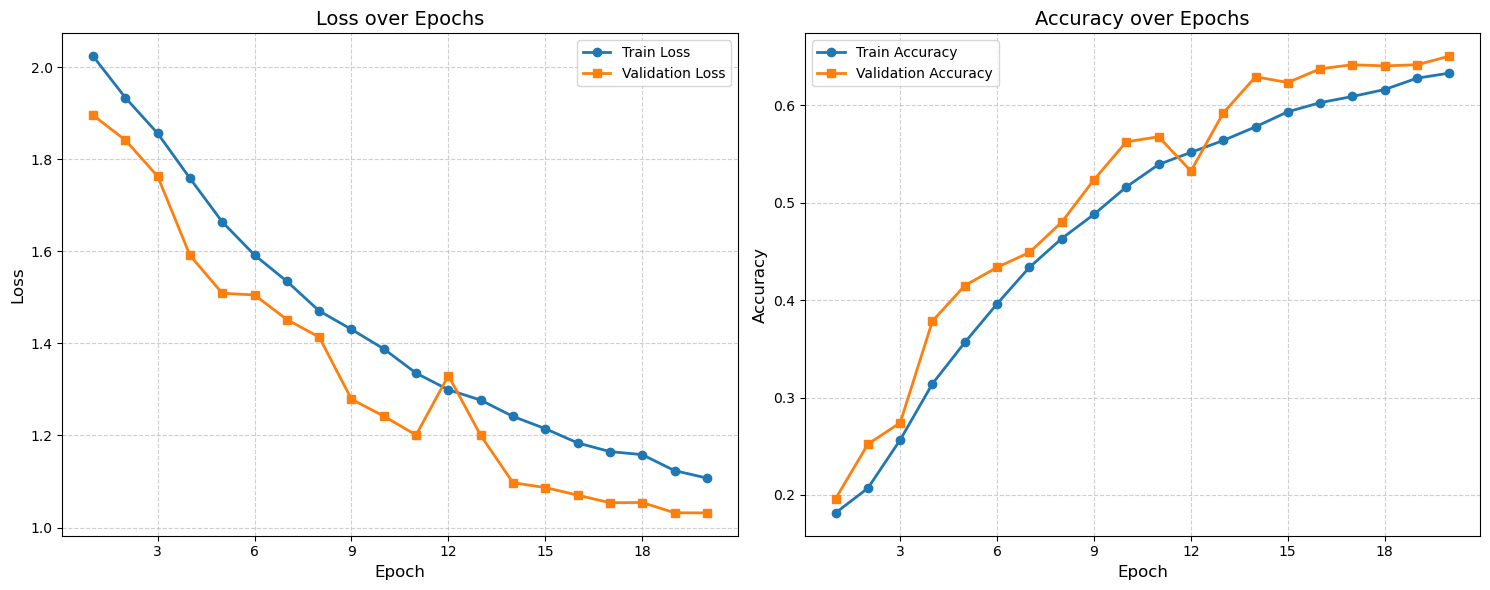

e_f_40_f_40 Acc:  0.68151


In [61]:
e_f_40_f_40.train(epoch=5)
print(f"e_f_40_f_40 Acc: {e_f_40_f_40.evaluate(): .5f}")

Epoch:   16 | Train loss:  1.17760 | Train acc:  0.60851 | Val loss:  1.06150 | Val acc:  0.64067


Epoch:   17 | Train loss:  1.16227 | Train acc:  0.61718 | Val loss:  1.01864 | Val acc:  0.64367


Epoch:   18 | Train loss:  1.13164 | Train acc:  0.62464 | Val loss:  0.98622 | Val acc:  0.66703


Epoch:   19 | Train loss:  1.11240 | Train acc:  0.63144 | Val loss:  0.99137 | Val acc:  0.66104


Epoch:   20 | Train loss:  1.10947 | Train acc:  0.63418 | Val loss:  0.95561 | Val acc:  0.68071


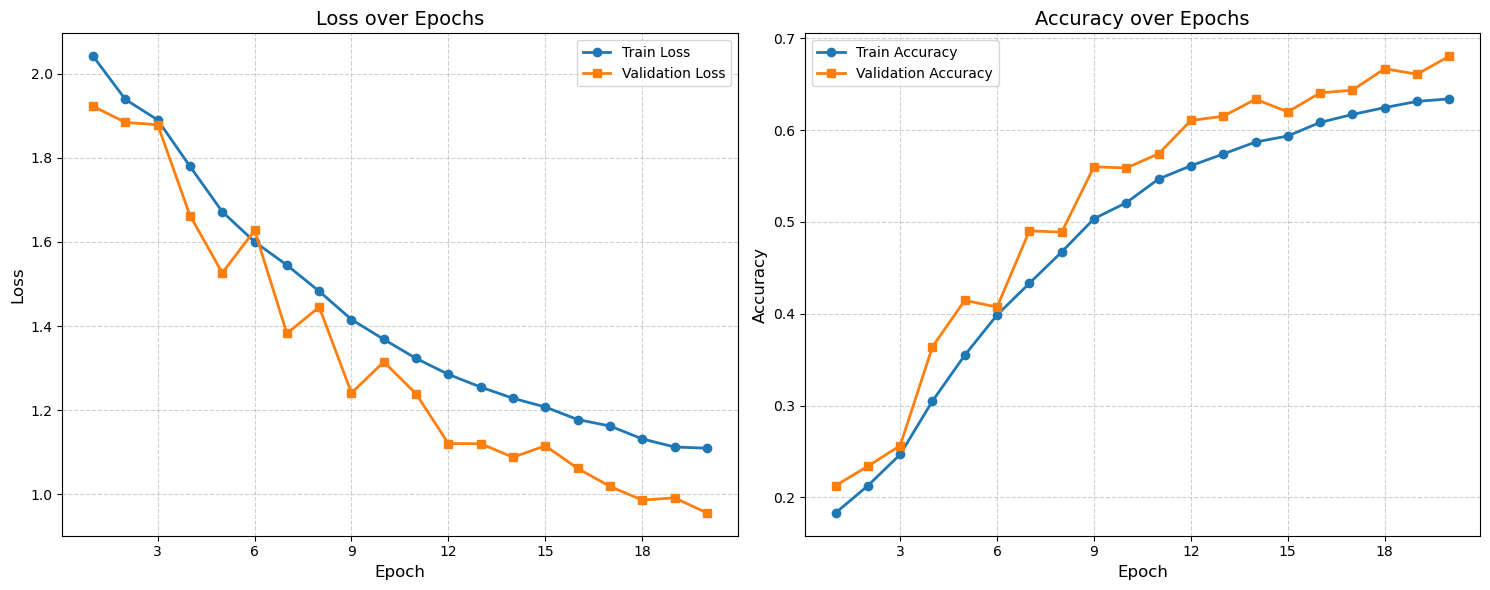

e_m_36_44_f_40 Acc:  0.70647


In [62]:
e_m_36_44_f_40.train(epoch=5)
print(f"e_m_36_44_f_40 Acc: {e_m_36_44_f_40.evaluate(): .5f}")

In [63]:
for trainer in trainers:
  trainer.checkout()

### Additional 5 epochs of train (Total: 25)

Epoch:   21 | Train loss:  0.93895 | Train acc:  0.70355 | Val loss:  0.87025 | Val acc:  0.71685


Epoch:   22 | Train loss:  0.92507 | Train acc:  0.70765 | Val loss:  0.92920 | Val acc:  0.70048


Epoch:   23 | Train loss:  0.91458 | Train acc:  0.70691 | Val loss:  0.83393 | Val acc:  0.72194


Epoch:   24 | Train loss:  0.90614 | Train acc:  0.71233 | Val loss:  0.82522 | Val acc:  0.72714


Epoch:   25 | Train loss:  0.90357 | Train acc:  0.71451 | Val loss:  0.82958 | Val acc:  0.72474


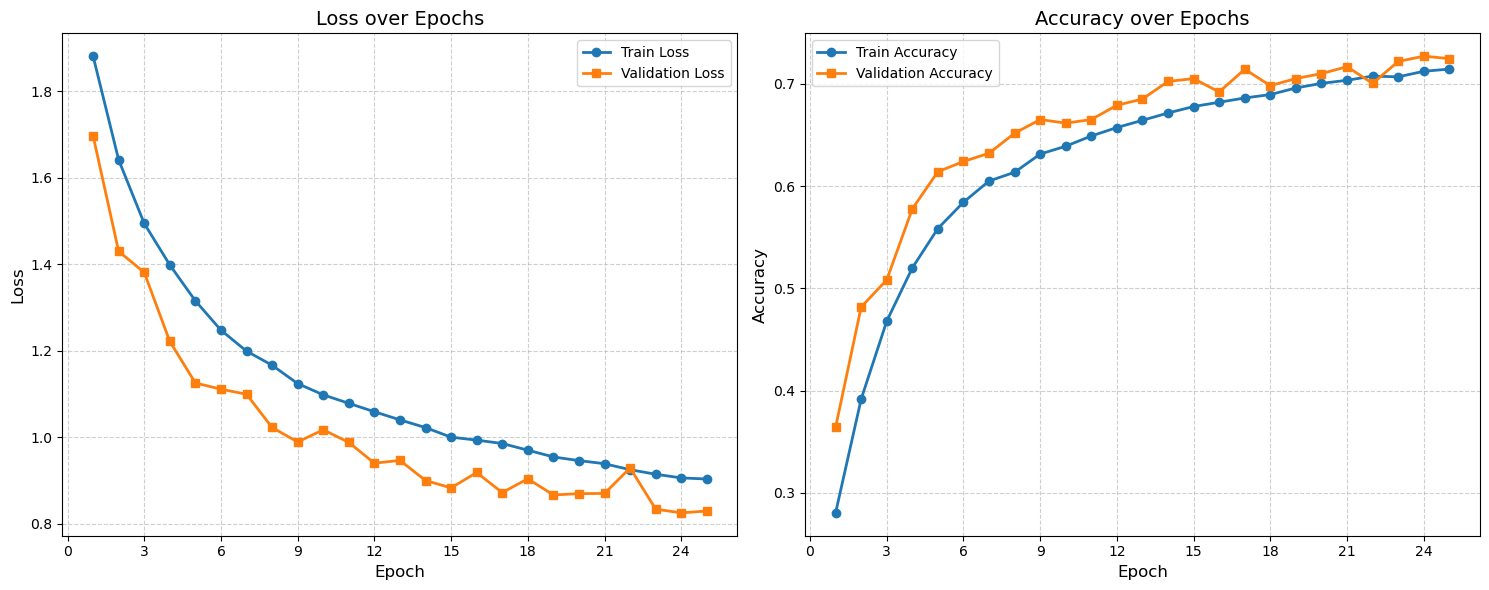

a_f_36_f_36 Acc:  0.75070


In [64]:
a_f_36_f_36.train(epoch=5)
print(f"a_f_36_f_36 Acc: {a_f_36_f_36.evaluate(): .5f}")

Epoch:   21 | Train loss:  0.82649 | Train acc:  0.74202 | Val loss:  0.77914 | Val acc:  0.73992


Epoch:   22 | Train loss:  0.81796 | Train acc:  0.74364 | Val loss:  0.76799 | Val acc:  0.74631


Epoch:   23 | Train loss:  0.81210 | Train acc:  0.74664 | Val loss:  0.77691 | Val acc:  0.74760


Epoch:   24 | Train loss:  0.73670 | Train acc:  0.77045 | Val loss:  0.66503 | Val acc:  0.78225


Epoch:   25 | Train loss:  0.70989 | Train acc:  0.77787 | Val loss:  0.66850 | Val acc:  0.77915


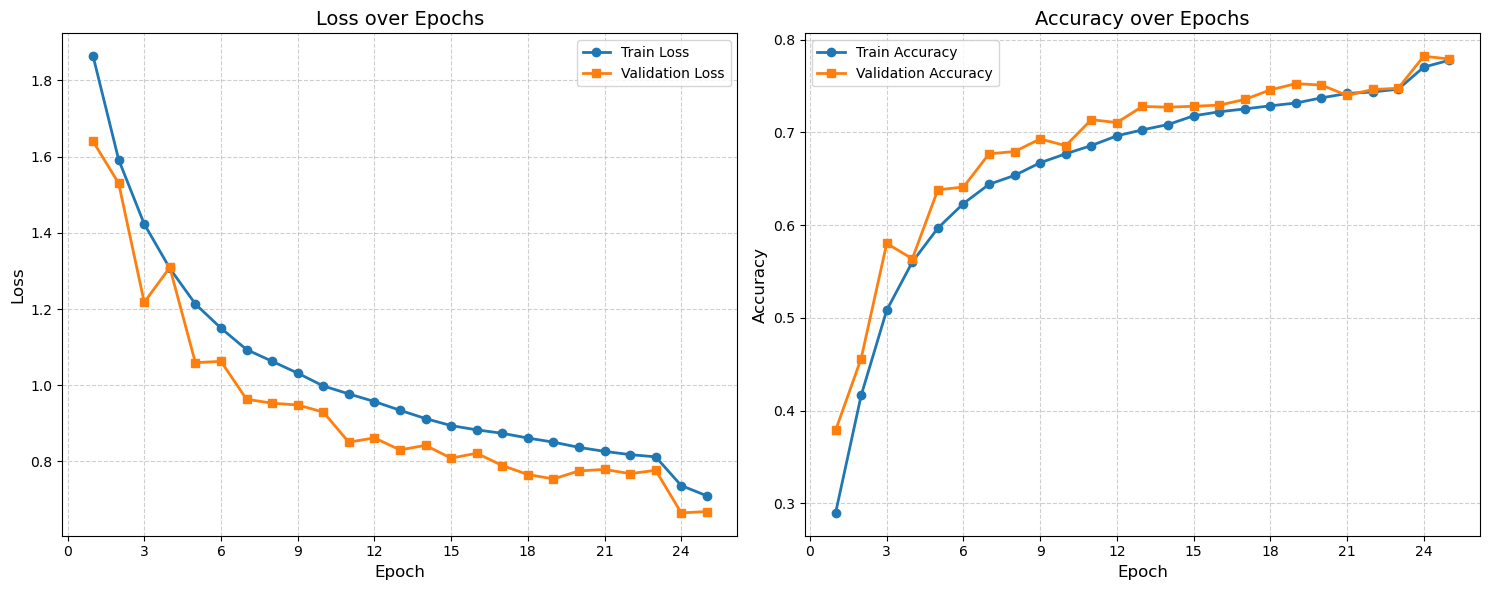

b_f_36_f_36 Acc:  0.79892


In [65]:
b_f_36_f_36.train(epoch=5)
print(f"b_f_36_f_36 Acc: {b_f_36_f_36.evaluate(): .5f}")

Epoch:   21 | Train loss:  0.90451 | Train acc:  0.70979 | Val loss:  0.88111 | Val acc:  0.71166


Epoch:   22 | Train loss:  0.89517 | Train acc:  0.71455 | Val loss:  0.82265 | Val acc:  0.73273


Epoch:   23 | Train loss:  0.88875 | Train acc:  0.71607 | Val loss:  0.78909 | Val acc:  0.74042


Epoch:   24 | Train loss:  0.87756 | Train acc:  0.72305 | Val loss:  0.80837 | Val acc:  0.73023


Epoch:   25 | Train loss:  0.86746 | Train acc:  0.72467 | Val loss:  0.80491 | Val acc:  0.73283


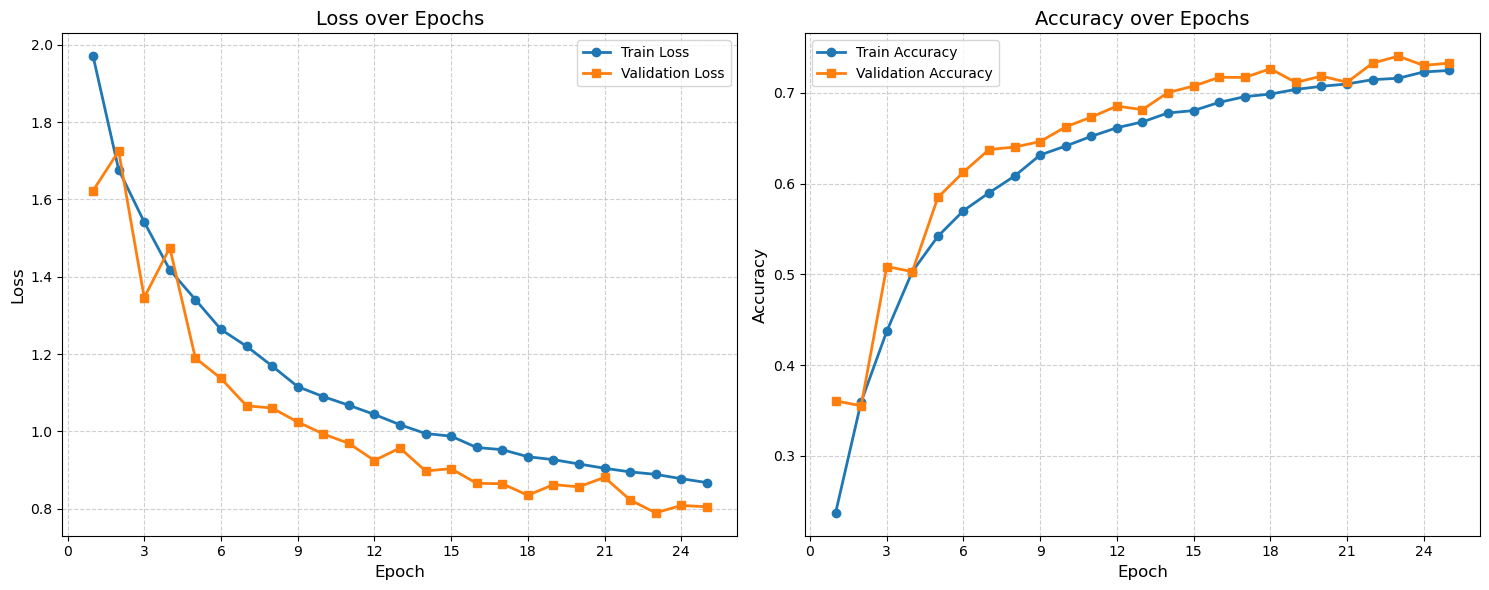

c_f_36_f_36 Acc:  0.75389


In [66]:
c_f_36_f_36.train(epoch=5)
print(f"c_f_36_f_36 Acc: {c_f_36_f_36.evaluate(): .5f}")

Epoch:   21 | Train loss:  1.02151 | Train acc:  0.67009 | Val loss:  0.91704 | Val acc:  0.69389


Epoch:   22 | Train loss:  1.00766 | Train acc:  0.67196 | Val loss:  0.93004 | Val acc:  0.68880


Epoch:   23 | Train loss:  0.99979 | Train acc:  0.67606 | Val loss:  0.89023 | Val acc:  0.69479


Epoch:   24 | Train loss:  0.98837 | Train acc:  0.68306 | Val loss:  0.89148 | Val acc:  0.69708


Epoch:   25 | Train loss:  0.98737 | Train acc:  0.68216 | Val loss:  0.91497 | Val acc:  0.69319


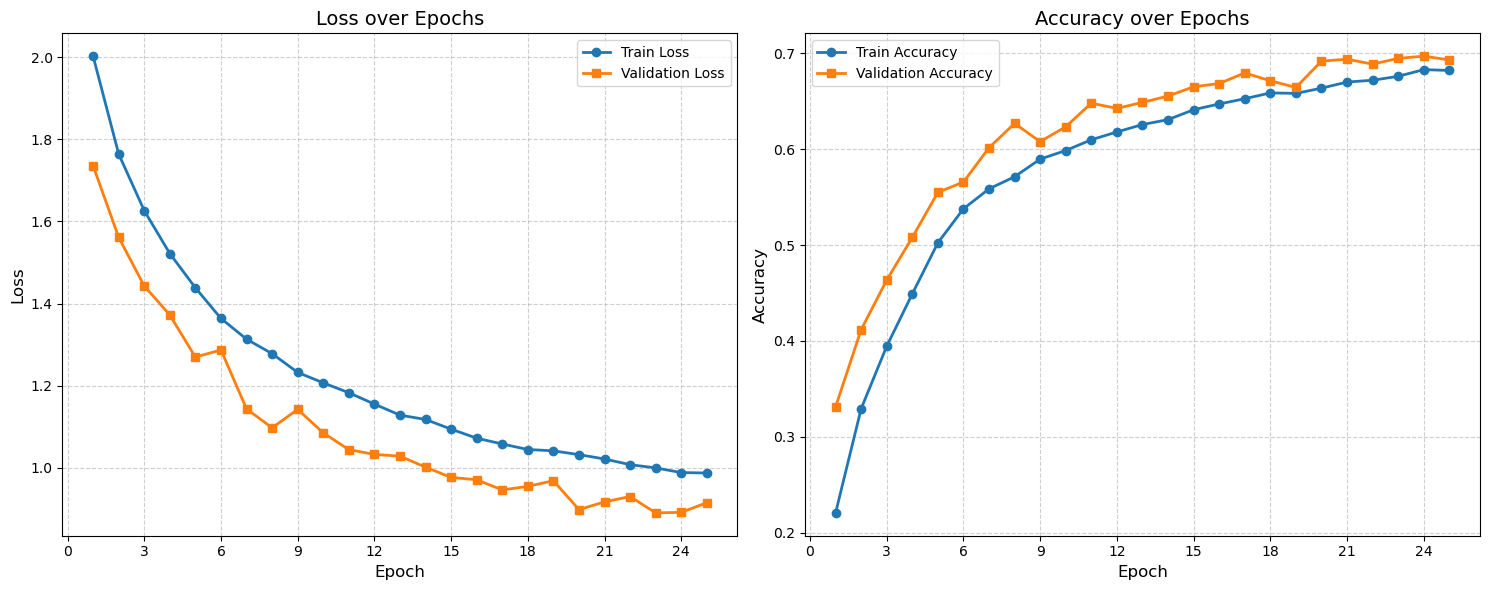

c_f_40_f_40 Acc:  0.72544


In [67]:
c_f_40_f_40.train(epoch=5)
print(f"c_f_40_f_40 Acc: {c_f_40_f_40.evaluate(): .5f}")

Epoch:   21 | Train loss:  1.02034 | Train acc:  0.67053 | Val loss:  0.91788 | Val acc:  0.69299


Epoch:   22 | Train loss:  1.00759 | Train acc:  0.67438 | Val loss:  0.92613 | Val acc:  0.68650


Epoch:   23 | Train loss:  0.99529 | Train acc:  0.67594 | Val loss:  0.90026 | Val acc:  0.70607


Epoch:   24 | Train loss:  0.98328 | Train acc:  0.67942 | Val loss:  0.89850 | Val acc:  0.69679


Epoch:   25 | Train loss:  0.97272 | Train acc:  0.68446 | Val loss:  0.84864 | Val acc:  0.71076


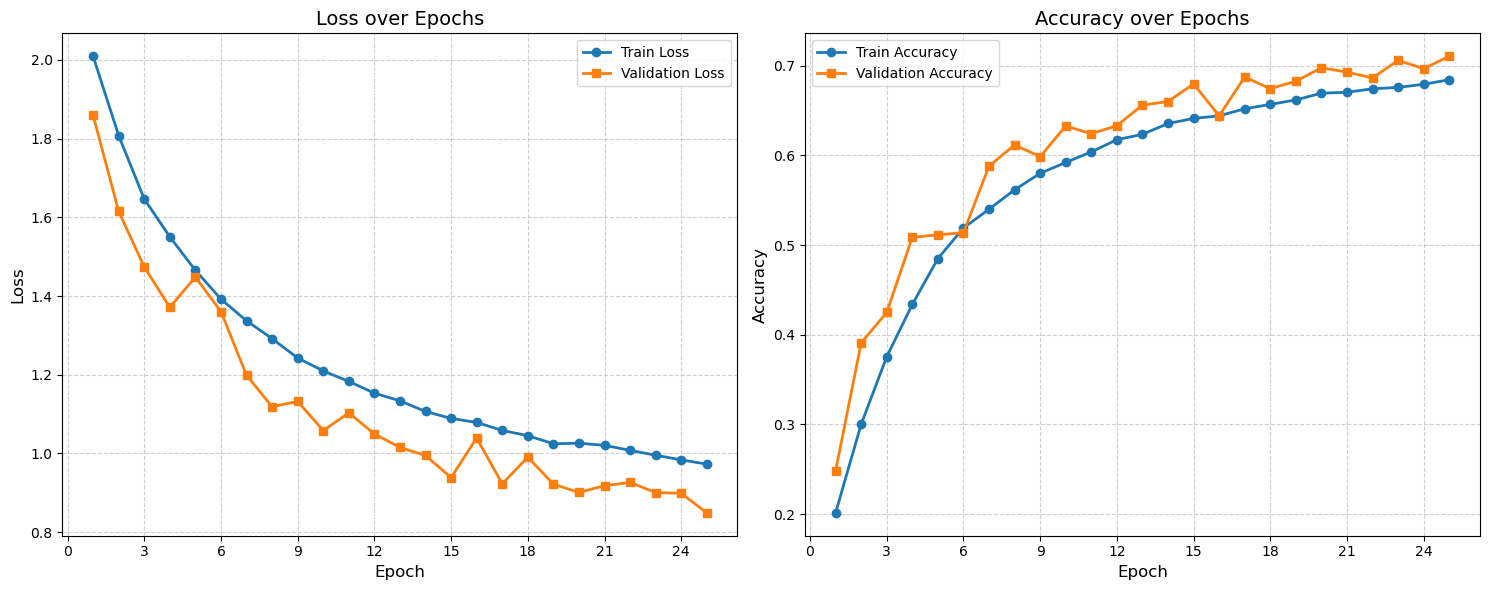

c_m_36_44_f_40 Acc:  0.74211


In [68]:
c_m_36_44_f_40.train(epoch=5)
print(f"c_m_36_44_f_40 Acc: {c_m_36_44_f_40.evaluate(): .5f}")

Epoch:   21 | Train loss:  0.85927 | Train acc:  0.72675 | Val loss:  0.76700 | Val acc:  0.74571


Epoch:   22 | Train loss:  0.85461 | Train acc:  0.73003 | Val loss:  0.77711 | Val acc:  0.74491


Epoch:   23 | Train loss:  0.84123 | Train acc:  0.73586 | Val loss:  0.76732 | Val acc:  0.74421


Epoch:   24 | Train loss:  0.82994 | Train acc:  0.73916 | Val loss:  0.76124 | Val acc:  0.74581


Epoch:   25 | Train loss:  0.81908 | Train acc:  0.74252 | Val loss:  0.77501 | Val acc:  0.74820


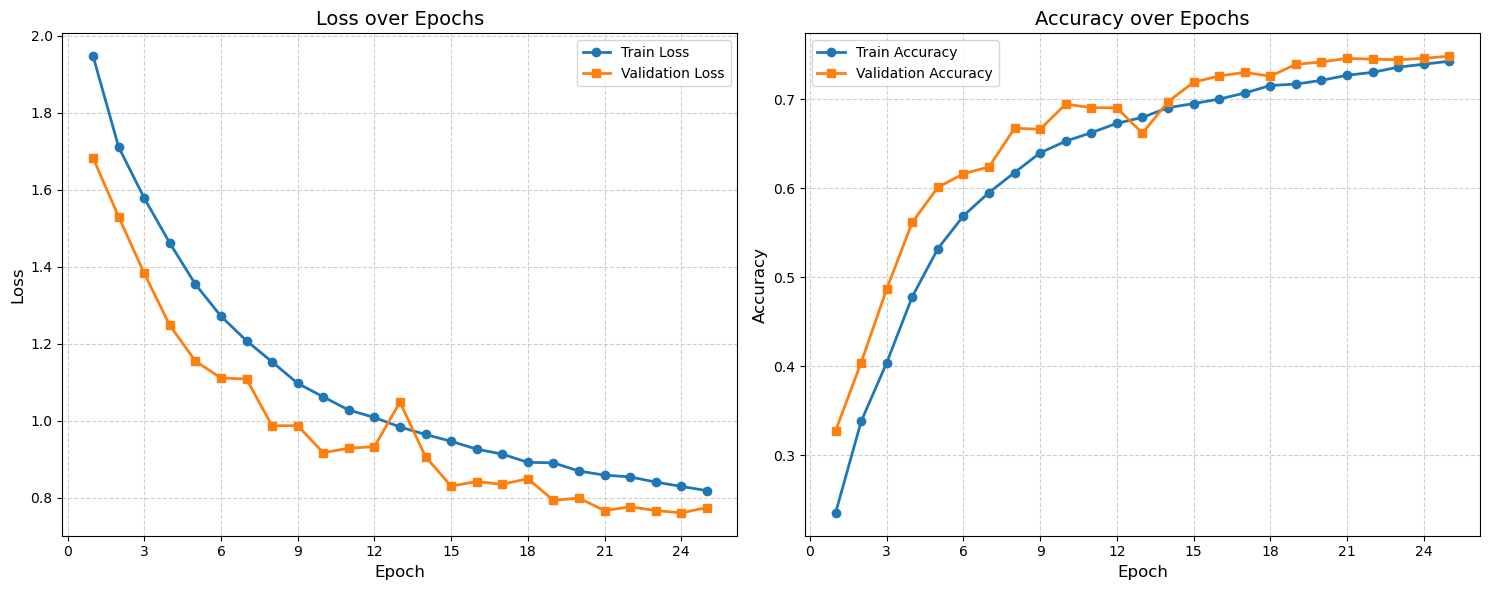

d_f_36_f_36 Acc:  0.77516


In [69]:
d_f_36_f_36.train(epoch=5)
print(f"d_f_36_f_36 Acc: {d_f_36_f_36.evaluate(): .5f}")

Epoch:   21 | Train loss:  0.97757 | Train acc:  0.68226 | Val loss:  0.89201 | Val acc:  0.70357


Epoch:   22 | Train loss:  0.96595 | Train acc:  0.68542 | Val loss:  0.89767 | Val acc:  0.70148


Epoch:   23 | Train loss:  0.94948 | Train acc:  0.69208 | Val loss:  0.86026 | Val acc:  0.71595


Epoch:   24 | Train loss:  0.94184 | Train acc:  0.69666 | Val loss:  0.84103 | Val acc:  0.72005


Epoch:   25 | Train loss:  0.92769 | Train acc:  0.70000 | Val loss:  0.83119 | Val acc:  0.71615


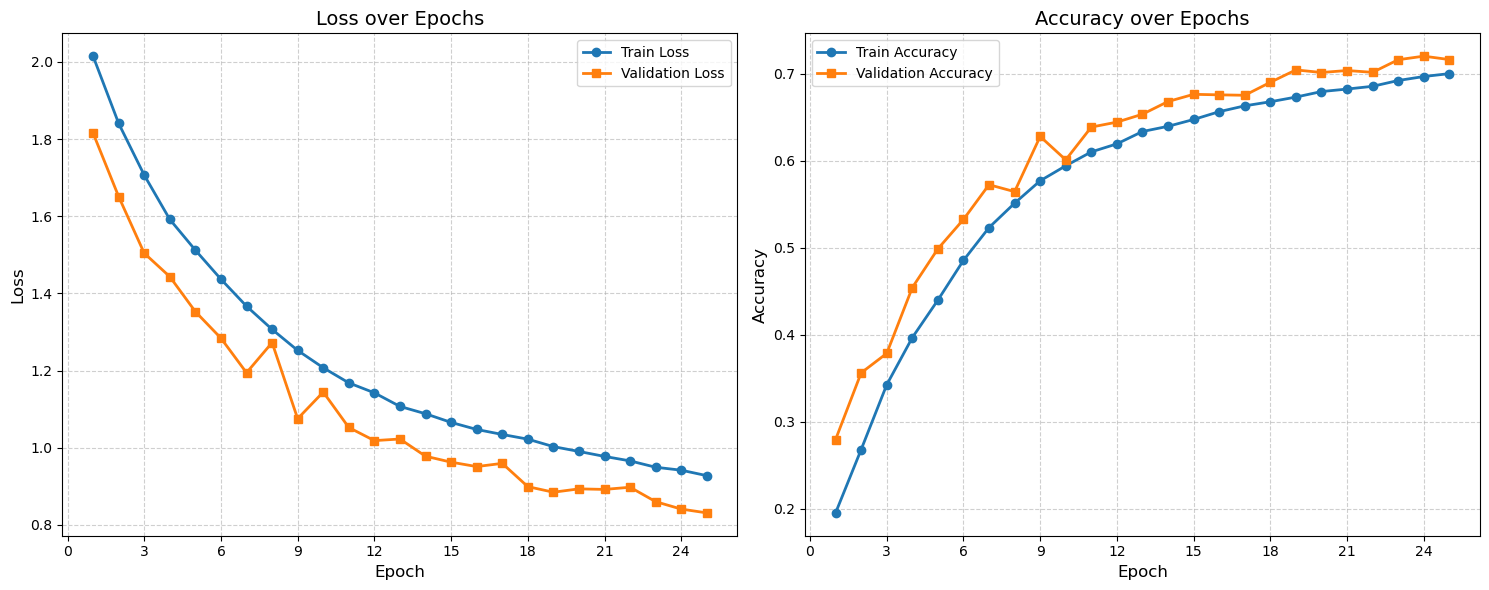

d_f_40_f_40 Acc:  0.74860


In [70]:
d_f_40_f_40.train(epoch=5)
print(f"d_f_40_f_40 Acc: {d_f_40_f_40.evaluate(): .5f}")

Epoch:   21 | Train loss:  0.96955 | Train acc:  0.68880 | Val loss:  0.86648 | Val acc:  0.71176


Epoch:   22 | Train loss:  0.96134 | Train acc:  0.69096 | Val loss:  0.87261 | Val acc:  0.71016


Epoch:   23 | Train loss:  0.95079 | Train acc:  0.69500 | Val loss:  0.87313 | Val acc:  0.70797


Epoch:   24 | Train loss:  0.87016 | Train acc:  0.71847 | Val loss:  0.76511 | Val acc:  0.74121


Epoch:   25 | Train loss:  0.85037 | Train acc:  0.72605 | Val loss:  0.74812 | Val acc:  0.75060


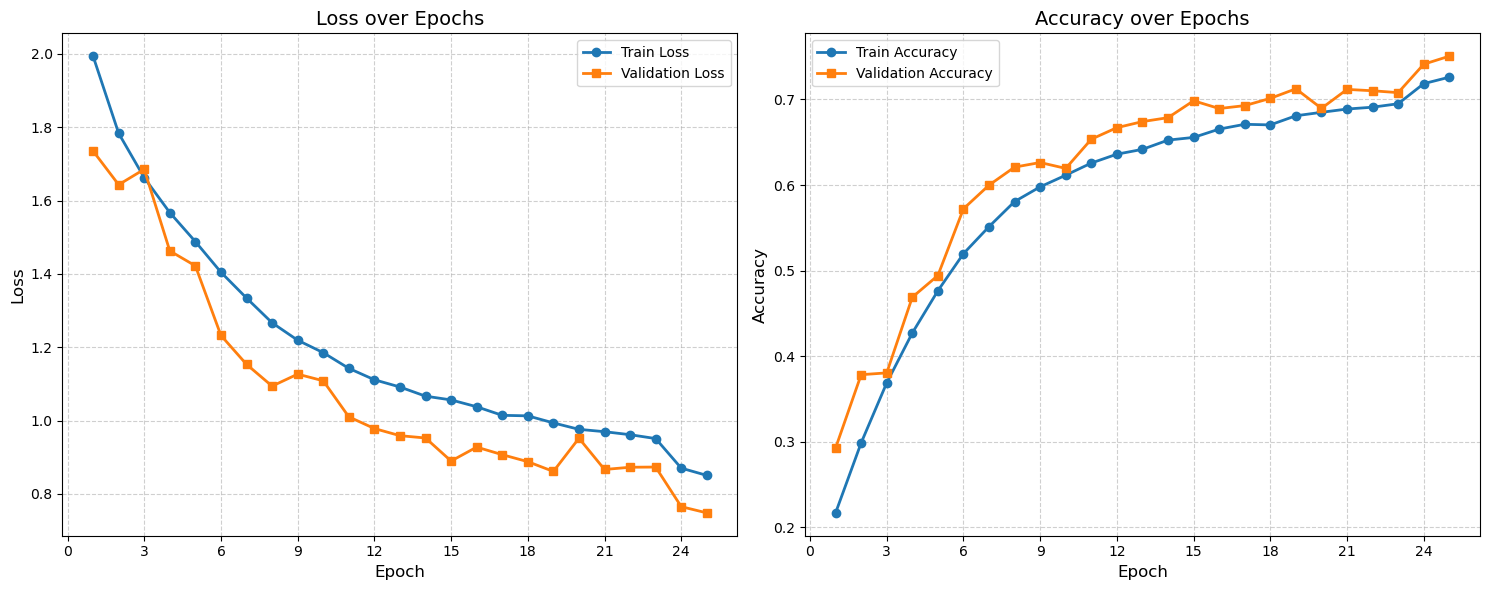

d_m_36_44_f_40 Acc:  0.77446


In [71]:
d_m_36_44_f_40.train(epoch=5)
print(f"d_m_36_44_f_40 Acc: {d_m_36_44_f_40.evaluate(): .5f}")

Epoch:   21 | Train loss:  0.96589 | Train acc:  0.68786 | Val loss:  0.89761 | Val acc:  0.69848


Epoch:   22 | Train loss:  0.95320 | Train acc:  0.68798 | Val loss:  0.87035 | Val acc:  0.71126


Epoch:   23 | Train loss:  0.93370 | Train acc:  0.69698 | Val loss:  0.84530 | Val acc:  0.72105


Epoch:   24 | Train loss:  0.93077 | Train acc:  0.69808 | Val loss:  0.89038 | Val acc:  0.70377


Epoch:   25 | Train loss:  0.91457 | Train acc:  0.70495 | Val loss:  0.99787 | Val acc:  0.66094


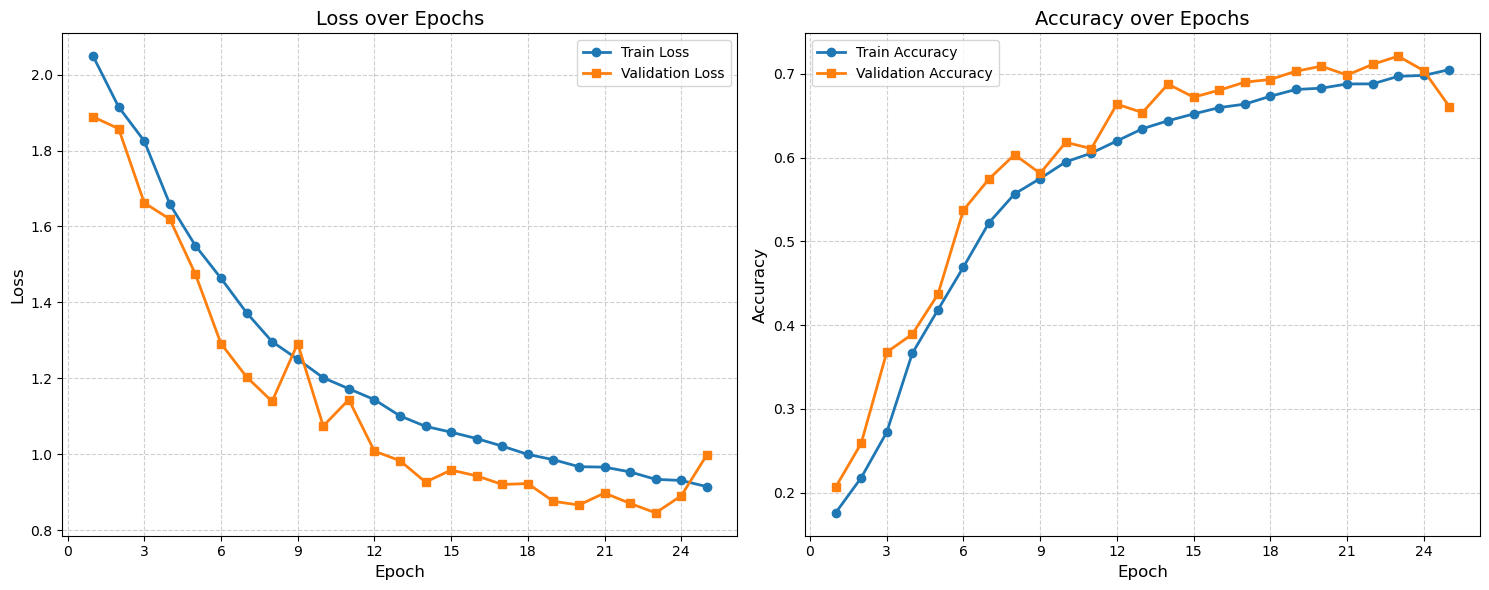

e_f_36_f_36 Acc:  0.68540


In [72]:
e_f_36_f_36.train(epoch=5)
print(f"e_f_36_f_36 Acc: {e_f_36_f_36.evaluate(): .5f}")

Epoch:   21 | Train loss:  1.09594 | Train acc:  0.63908 | Val loss:  1.06756 | Val acc:  0.64856


Epoch:   22 | Train loss:  1.08476 | Train acc:  0.64127 | Val loss:  1.04239 | Val acc:  0.65166


Epoch:   23 | Train loss:  1.06468 | Train acc:  0.65187 | Val loss:  0.93181 | Val acc:  0.68221


Epoch:   24 | Train loss:  1.04790 | Train acc:  0.65697 | Val loss:  0.97163 | Val acc:  0.68051


Epoch:   25 | Train loss:  1.03666 | Train acc:  0.66427 | Val loss:  0.96022 | Val acc:  0.67572


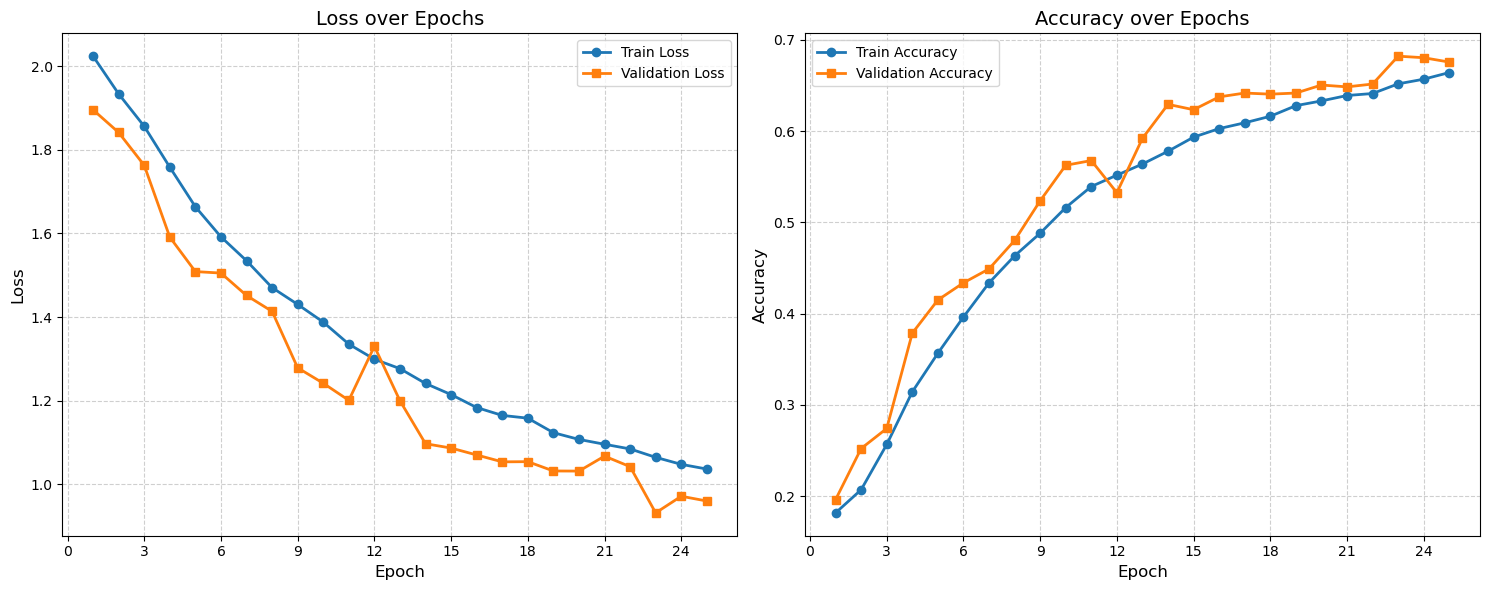

e_f_40_f_40 Acc:  0.70637


In [73]:
e_f_40_f_40.train(epoch=5)
print(f"e_f_40_f_40 Acc: {e_f_40_f_40.evaluate(): .5f}")

Epoch:   21 | Train loss:  1.08614 | Train acc:  0.64305 | Val loss:  0.97807 | Val acc:  0.66404


Epoch:   22 | Train loss:  1.06879 | Train acc:  0.64947 | Val loss:  0.97109 | Val acc:  0.66873


Epoch:   23 | Train loss:  1.06489 | Train acc:  0.64773 | Val loss:  0.95216 | Val acc:  0.68241


Epoch:   24 | Train loss:  1.05014 | Train acc:  0.65555 | Val loss:  0.96103 | Val acc:  0.67492


Epoch:   25 | Train loss:  1.02983 | Train acc:  0.66307 | Val loss:  0.93100 | Val acc:  0.69030


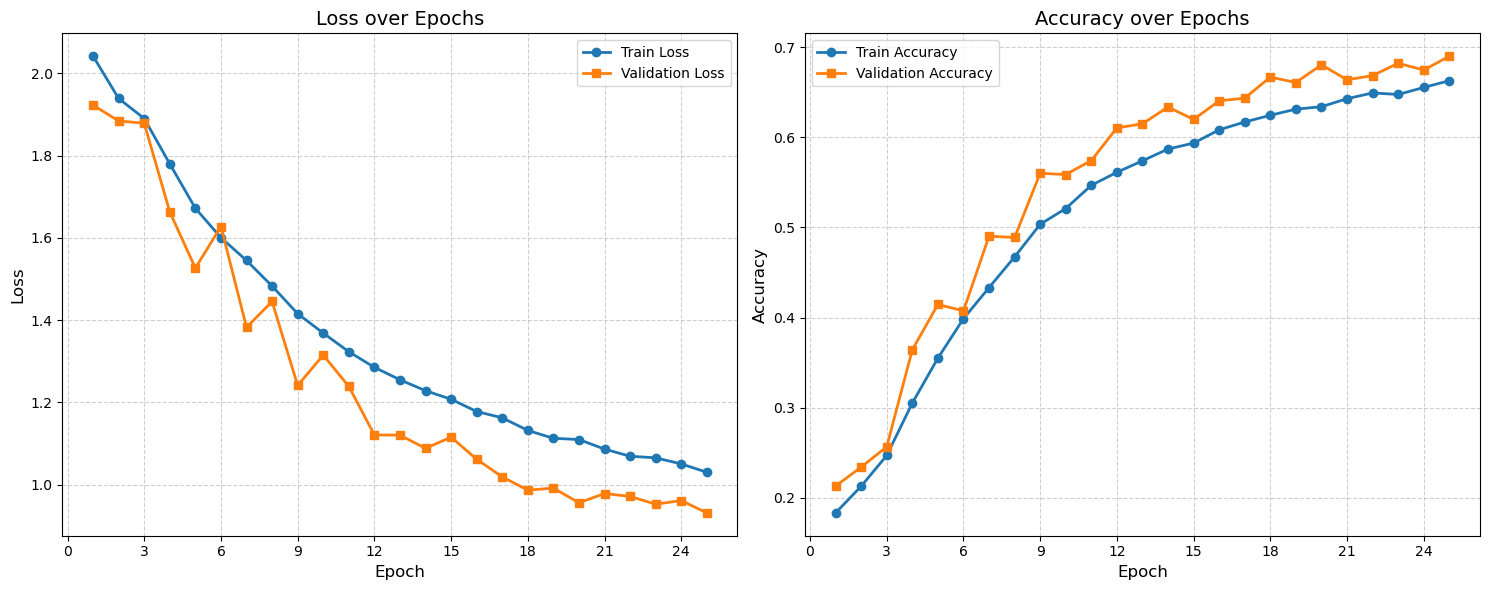

e_m_36_44_f_40 Acc:  0.71715


In [74]:
e_m_36_44_f_40.train(epoch=5)
print(f"e_m_36_44_f_40 Acc: {e_m_36_44_f_40.evaluate(): .5f}")

In [75]:
for trainer in trainers:
  trainer.checkout()

### Additional 5 epochs of train (Total: 30)

Epoch:   26 | Train loss:  0.89040 | Train acc:  0.72031 | Val loss:  0.85666 | Val acc:  0.71675


Epoch:   27 | Train loss:  0.88020 | Train acc:  0.72169 | Val loss:  0.84440 | Val acc:  0.72654


Epoch:   28 | Train loss:  0.86196 | Train acc:  0.72817 | Val loss:  0.84808 | Val acc:  0.72534


Epoch:   29 | Train loss:  0.80445 | Train acc:  0.74736 | Val loss:  0.74576 | Val acc:  0.75230


Epoch:   30 | Train loss:  0.77255 | Train acc:  0.75486 | Val loss:  0.72821 | Val acc:  0.75639


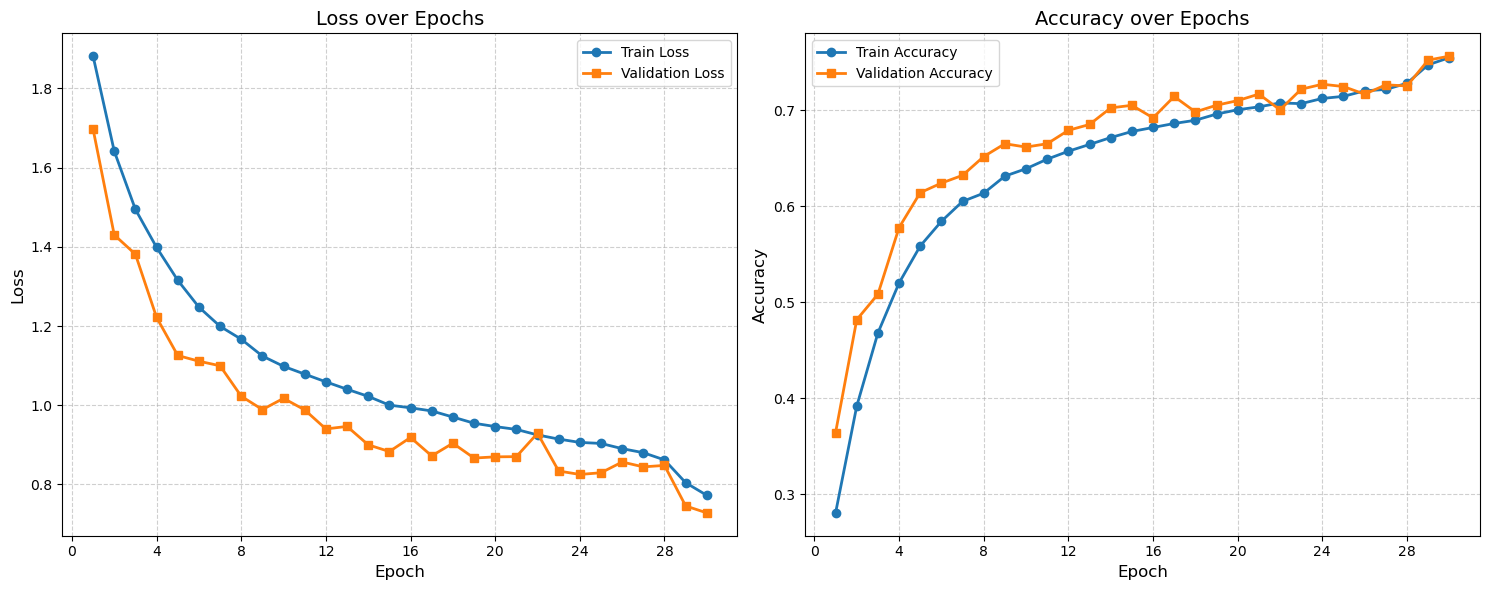

a_f_36_f_36 Acc:  0.78115


In [77]:
a_f_36_f_36.train(epoch=5)
print(f"a_f_36_f_36 Acc: {a_f_36_f_36.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.70170 | Train acc:  0.77899 | Val loss:  0.66962 | Val acc:  0.77835


Epoch:   27 | Train loss:  0.69920 | Train acc:  0.78059 | Val loss:  0.65548 | Val acc:  0.78315


Epoch:   28 | Train loss:  0.68627 | Train acc:  0.78343 | Val loss:  0.64260 | Val acc:  0.78574


Epoch:   29 | Train loss:  0.68526 | Train acc:  0.78669 | Val loss:  0.65164 | Val acc:  0.78564


Epoch:   30 | Train loss:  0.67795 | Train acc:  0.78671 | Val loss:  0.64676 | Val acc:  0.78534


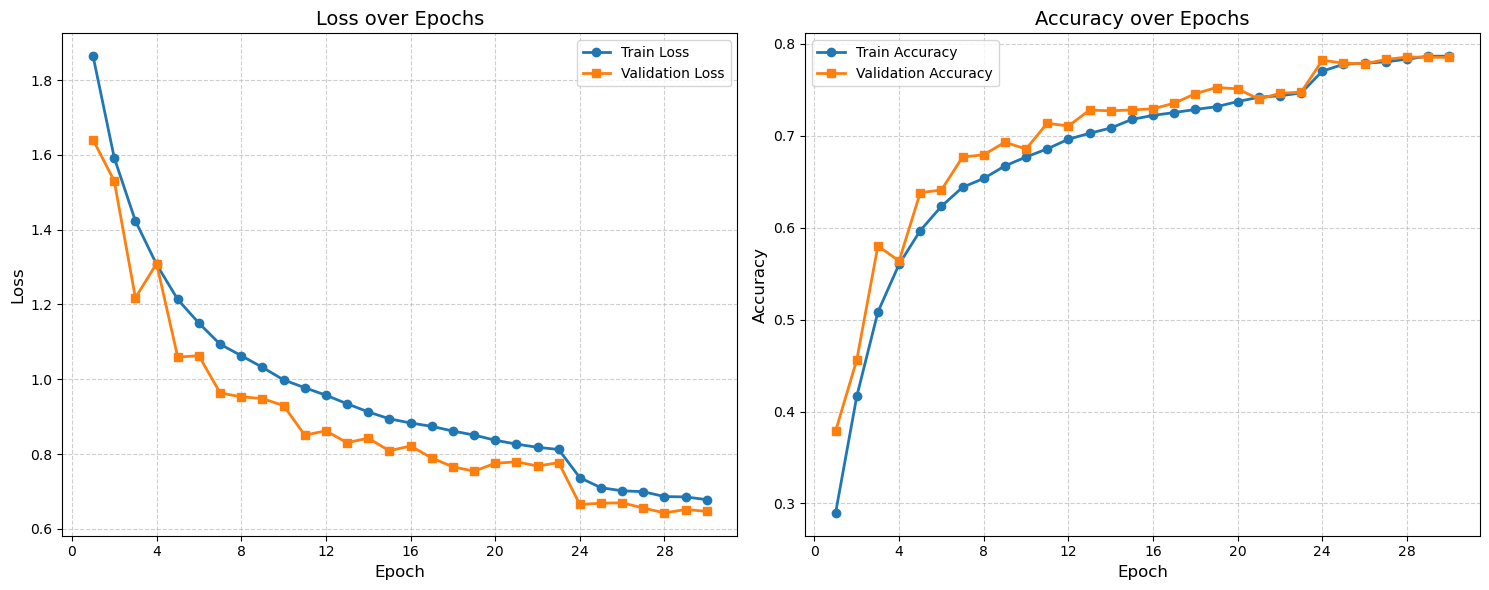

b_f_36_f_36 Acc:  0.80192


In [78]:
b_f_36_f_36.train(epoch=5)
print(f"b_f_36_f_36 Acc: {b_f_36_f_36.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.85695 | Train acc:  0.72771 | Val loss:  0.79599 | Val acc:  0.73373


Epoch:   27 | Train loss:  0.84824 | Train acc:  0.72961 | Val loss:  0.80616 | Val acc:  0.74231


Epoch:   28 | Train loss:  0.83972 | Train acc:  0.73486 | Val loss:  0.78404 | Val acc:  0.74571


Epoch:   29 | Train loss:  0.83319 | Train acc:  0.73640 | Val loss:  0.76601 | Val acc:  0.74700


Epoch:   30 | Train loss:  0.82684 | Train acc:  0.74040 | Val loss:  0.77395 | Val acc:  0.74611


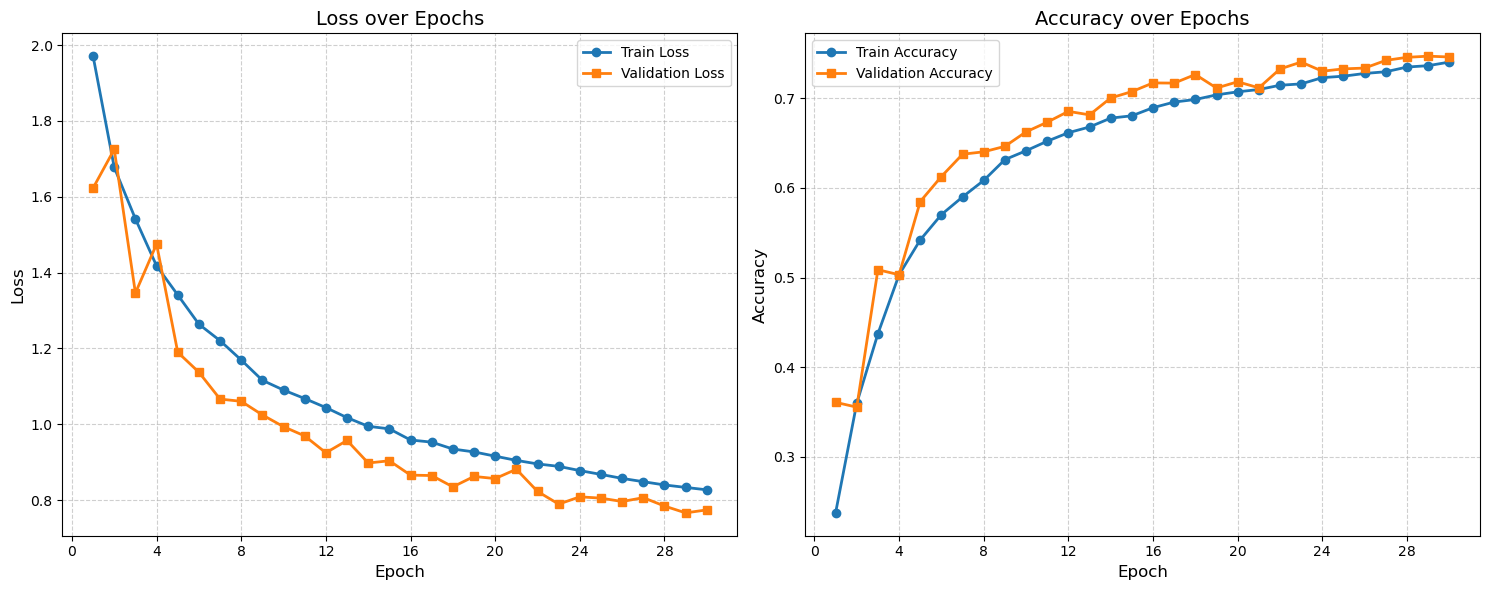

c_f_36_f_36 Acc:  0.76997


In [79]:
c_f_36_f_36.train(epoch=5)
print(f"c_f_36_f_36 Acc: {c_f_36_f_36.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.97109 | Train acc:  0.68454 | Val loss:  0.92789 | Val acc:  0.69818


Epoch:   27 | Train loss:  0.95843 | Train acc:  0.69196 | Val loss:  0.84685 | Val acc:  0.71625


Epoch:   28 | Train loss:  0.95126 | Train acc:  0.69188 | Val loss:  0.88246 | Val acc:  0.70337


Epoch:   29 | Train loss:  0.95349 | Train acc:  0.69816 | Val loss:  0.87131 | Val acc:  0.71136


Epoch:   30 | Train loss:  0.93839 | Train acc:  0.70066 | Val loss:  0.83098 | Val acc:  0.71905


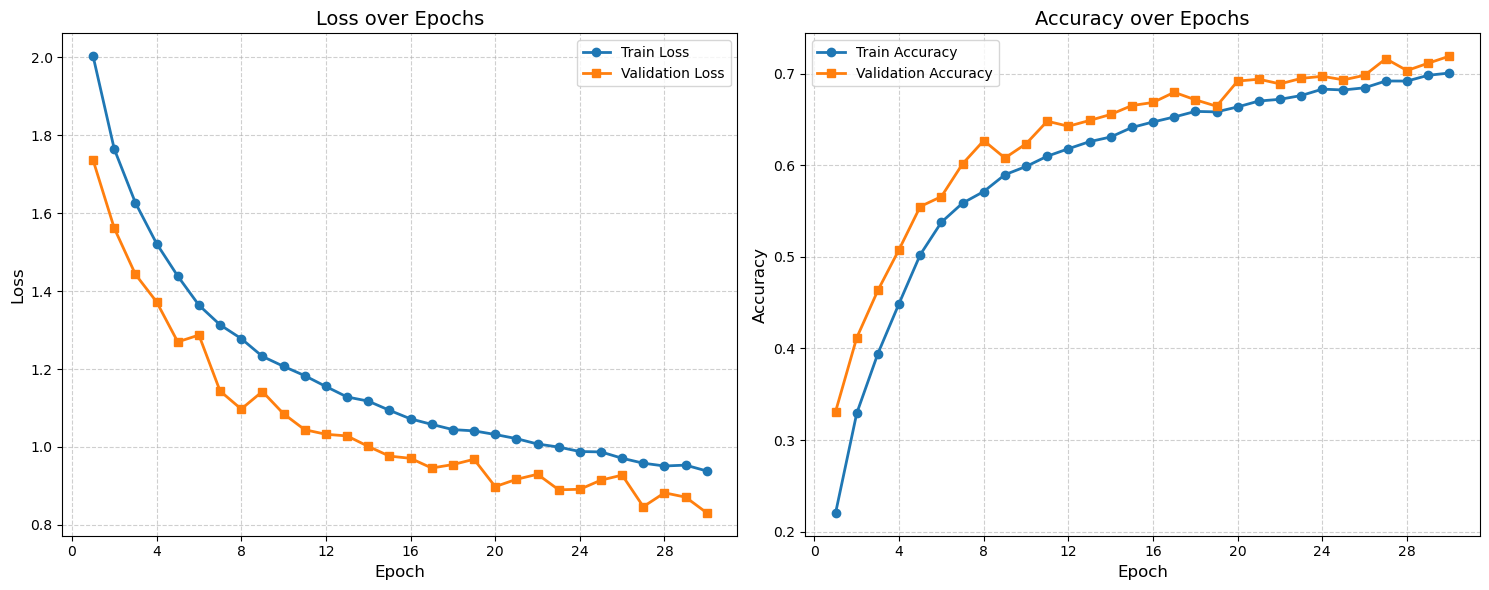

c_f_40_f_40 Acc:  0.75170


In [80]:
c_f_40_f_40.train(epoch=5)
print(f"c_f_40_f_40 Acc: {c_f_40_f_40.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.96455 | Train acc:  0.68860 | Val loss:  0.89224 | Val acc:  0.69858


Epoch:   27 | Train loss:  0.96356 | Train acc:  0.69124 | Val loss:  0.84167 | Val acc:  0.72204


Epoch:   28 | Train loss:  0.94582 | Train acc:  0.69576 | Val loss:  0.84325 | Val acc:  0.72005


Epoch:   29 | Train loss:  0.94046 | Train acc:  0.70046 | Val loss:  0.86564 | Val acc:  0.71026


Epoch:   30 | Train loss:  0.93803 | Train acc:  0.69878 | Val loss:  0.83031 | Val acc:  0.72414


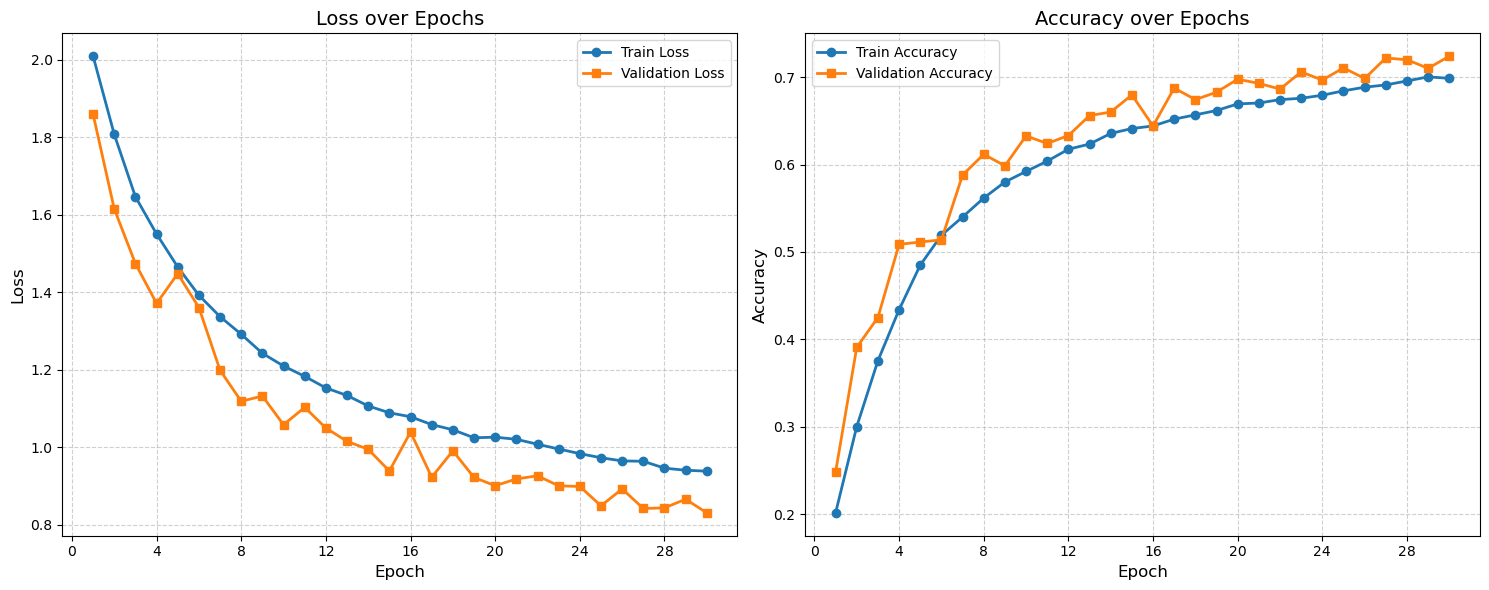

c_m_36_44_f_40 Acc:  0.74621


In [81]:
c_m_36_44_f_40.train(epoch=5)
print(f"c_m_36_44_f_40 Acc: {c_m_36_44_f_40.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.80998 | Train acc:  0.74616 | Val loss:  0.73346 | Val acc:  0.75968


Epoch:   27 | Train loss:  0.79556 | Train acc:  0.75118 | Val loss:  0.72895 | Val acc:  0.76288


Epoch:   28 | Train loss:  0.78946 | Train acc:  0.75506 | Val loss:  0.73997 | Val acc:  0.76008


Epoch:   29 | Train loss:  0.77913 | Train acc:  0.75556 | Val loss:  0.72562 | Val acc:  0.76228


Epoch:   30 | Train loss:  0.77170 | Train acc:  0.76054 | Val loss:  0.74765 | Val acc:  0.75719


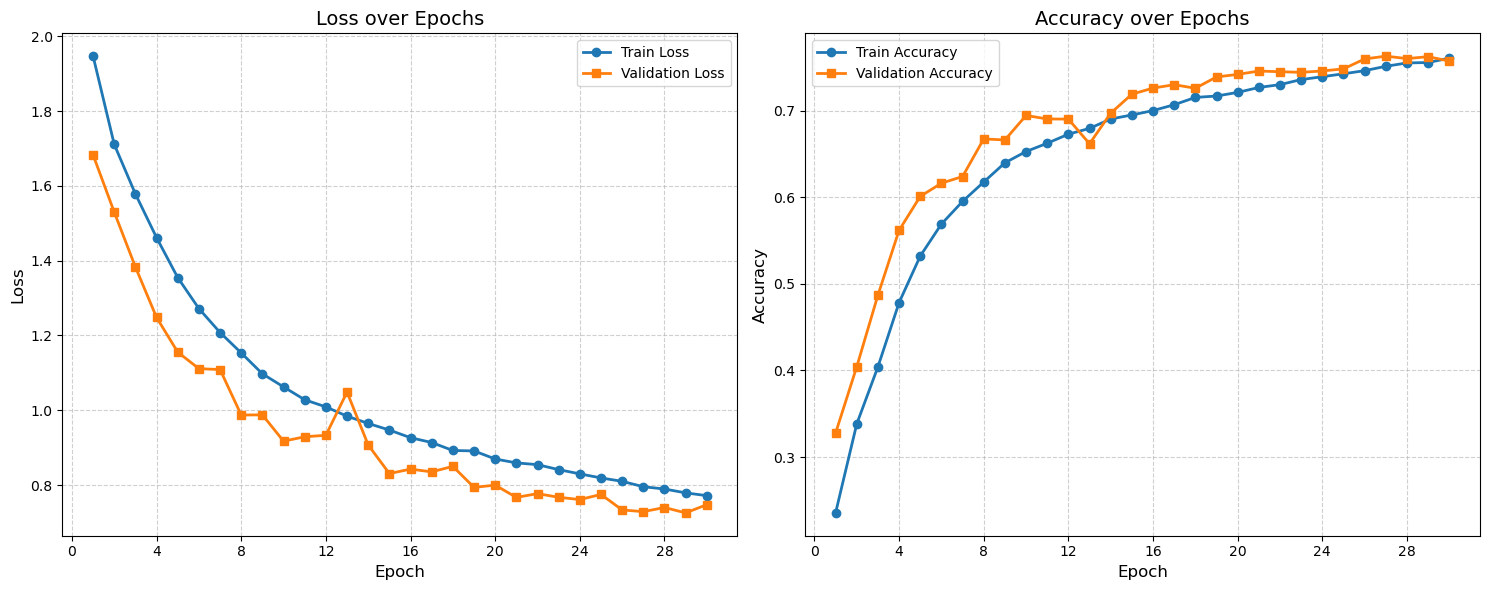

d_f_36_f_36 Acc:  0.77726


In [82]:
d_f_36_f_36.train(epoch=5)
print(f"d_f_36_f_36 Acc: {d_f_36_f_36.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.92193 | Train acc:  0.70461 | Val loss:  0.84080 | Val acc:  0.72035


Epoch:   27 | Train loss:  0.91877 | Train acc:  0.70413 | Val loss:  0.83068 | Val acc:  0.72404


Epoch:   28 | Train loss:  0.91377 | Train acc:  0.70789 | Val loss:  0.84433 | Val acc:  0.71715


Epoch:   29 | Train loss:  0.89922 | Train acc:  0.71271 | Val loss:  0.80969 | Val acc:  0.73632


Epoch:   30 | Train loss:  0.89165 | Train acc:  0.71553 | Val loss:  0.81277 | Val acc:  0.72813


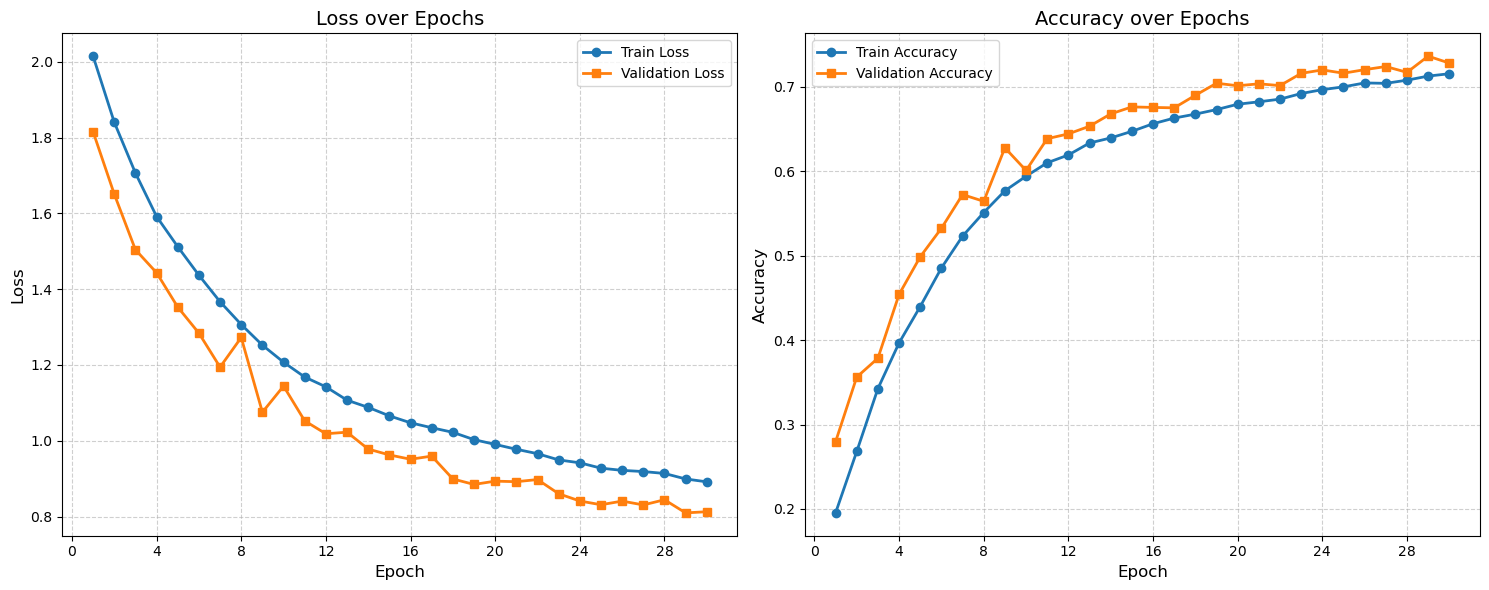

d_f_40_f_40 Acc:  0.76198


In [83]:
d_f_40_f_40.train(epoch=5)
print(f"d_f_40_f_40 Acc: {d_f_40_f_40.evaluate(): .5f}")

Epoch:   26 | Train loss:  0.83718 | Train acc:  0.73187 | Val loss:  0.74850 | Val acc:  0.74900


Epoch:   27 | Train loss:  0.83467 | Train acc:  0.73163 | Val loss:  0.76483 | Val acc:  0.74451


Epoch:   28 | Train loss:  0.82198 | Train acc:  0.73379 | Val loss:  0.73863 | Val acc:  0.75319


Epoch:   29 | Train loss:  0.82007 | Train acc:  0.73990 | Val loss:  0.72841 | Val acc:  0.75549


Epoch:   30 | Train loss:  0.81552 | Train acc:  0.73826 | Val loss:  0.73762 | Val acc:  0.75270


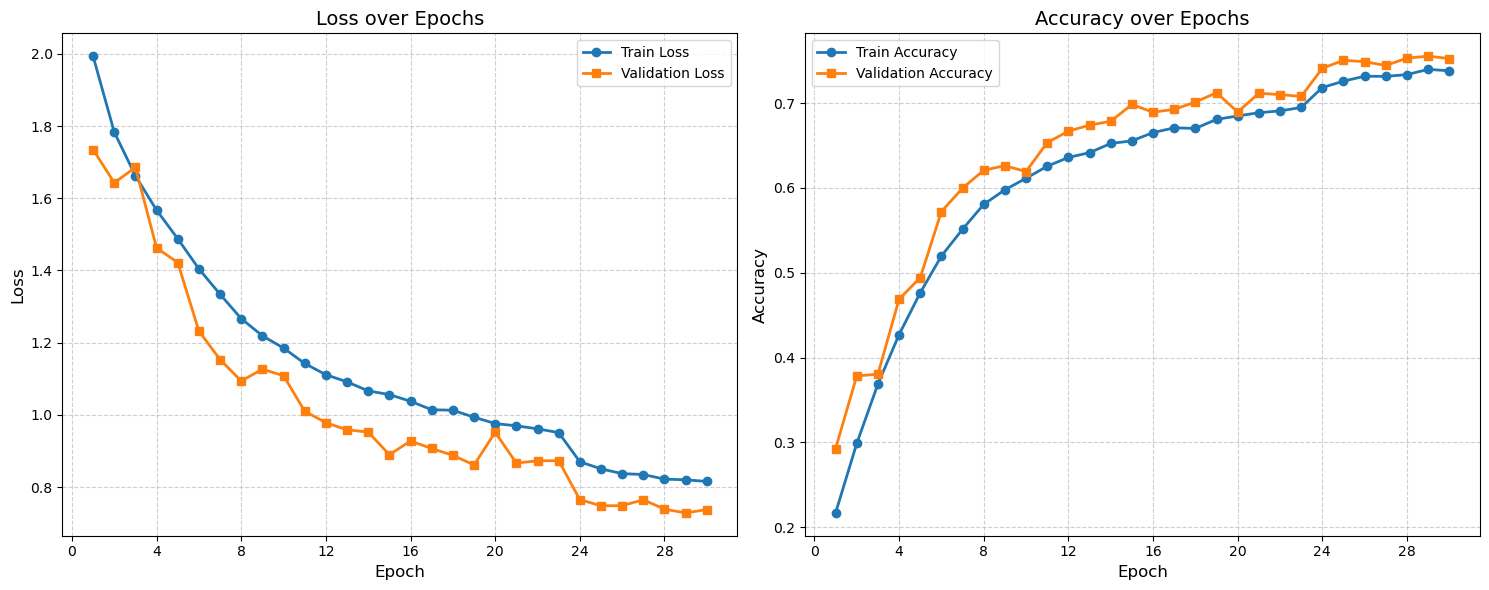

d_m_36_44_f_40 Acc:  0.78295


In [84]:
d_m_36_44_f_40.train(epoch=5)
print(f"d_m_36_44_f_40 Acc: {d_m_36_44_f_40.evaluate(): .5f}")

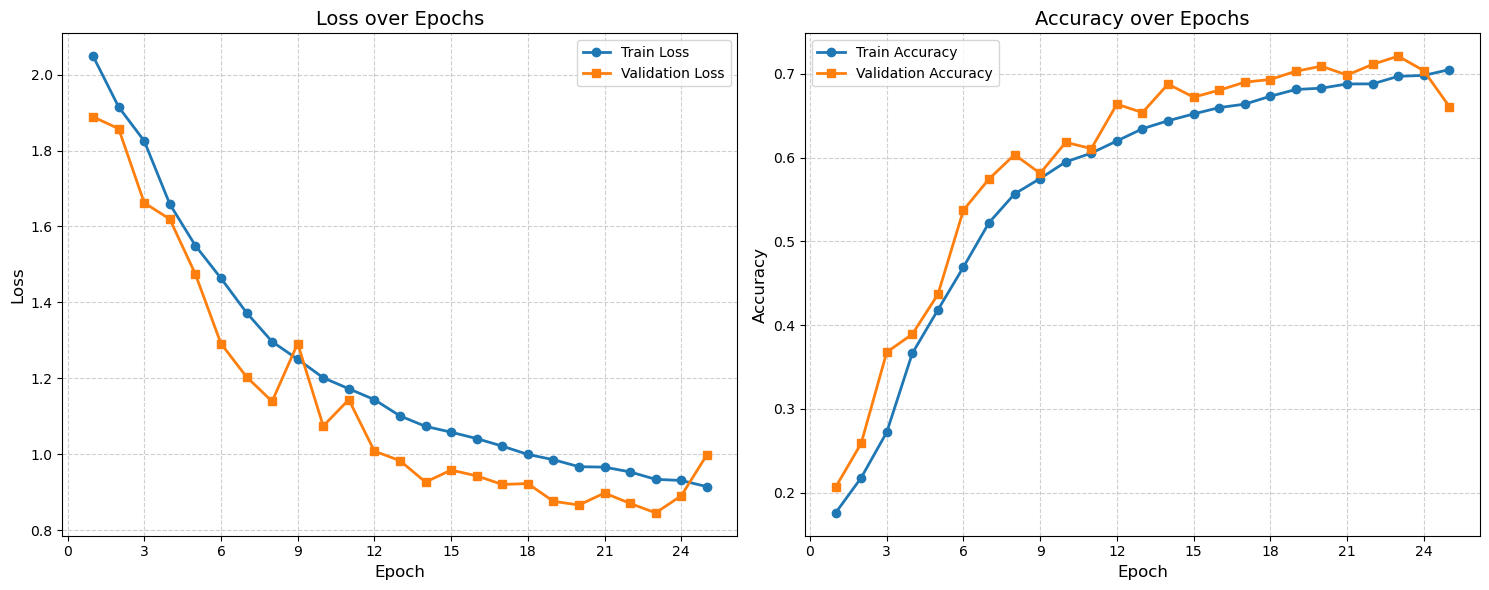

In [92]:
# e_f_36_f_36.train(epoch=5)
# print(f"e_f_36_f_36 Acc: {e_f_36_f_36.evaluate(): .5f}")
e_f_36_f_36._plot_train_log()

Epoch:   26 | Train loss:  1.02686 | Train acc:  0.66667 | Val loss:  0.94030 | Val acc:  0.69099


Epoch:   27 | Train loss:  1.02236 | Train acc:  0.66695 | Val loss:  0.92497 | Val acc:  0.69619


Epoch:   28 | Train loss:  1.00179 | Train acc:  0.67302 | Val loss:  0.90135 | Val acc:  0.70557


Epoch:   29 | Train loss:  1.00011 | Train acc:  0.67612 | Val loss:  0.91163 | Val acc:  0.69459


Epoch:   30 | Train loss:  0.99093 | Train acc:  0.68030 | Val loss:  0.89040 | Val acc:  0.70687


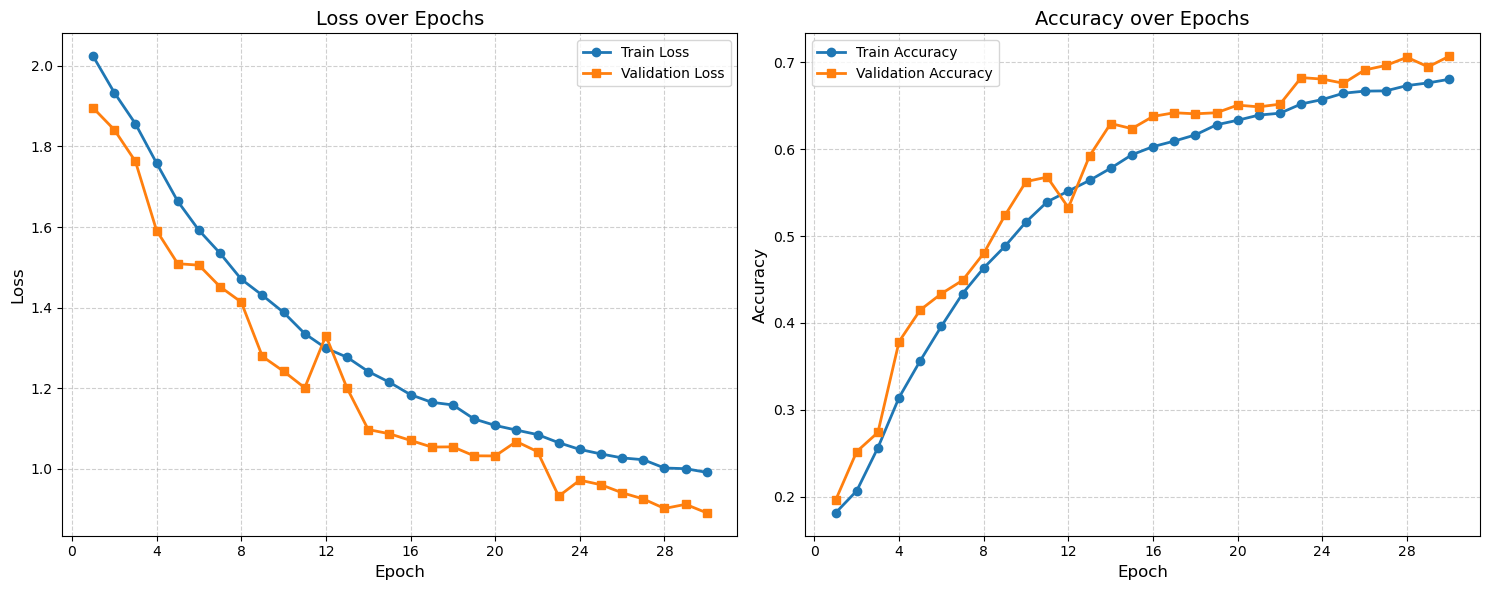

e_f_40_f_40 Acc:  0.73283


In [86]:
e_f_40_f_40.train(epoch=5)
print(f"e_f_40_f_40 Acc: {e_f_40_f_40.evaluate(): .5f}")

Epoch:   26 | Train loss:  1.02374 | Train acc:  0.66573 | Val loss:  0.93881 | Val acc:  0.69129


Epoch:   27 | Train loss:  1.01571 | Train acc:  0.67294 | Val loss:  0.89899 | Val acc:  0.69888


Epoch:   28 | Train loss:  1.00932 | Train acc:  0.67342 | Val loss:  0.91299 | Val acc:  0.69419


Epoch:   29 | Train loss:  0.99712 | Train acc:  0.67666 | Val loss:  0.90012 | Val acc:  0.70148


Epoch:   30 | Train loss:  0.98238 | Train acc:  0.67962 | Val loss:  0.87722 | Val acc:  0.71176


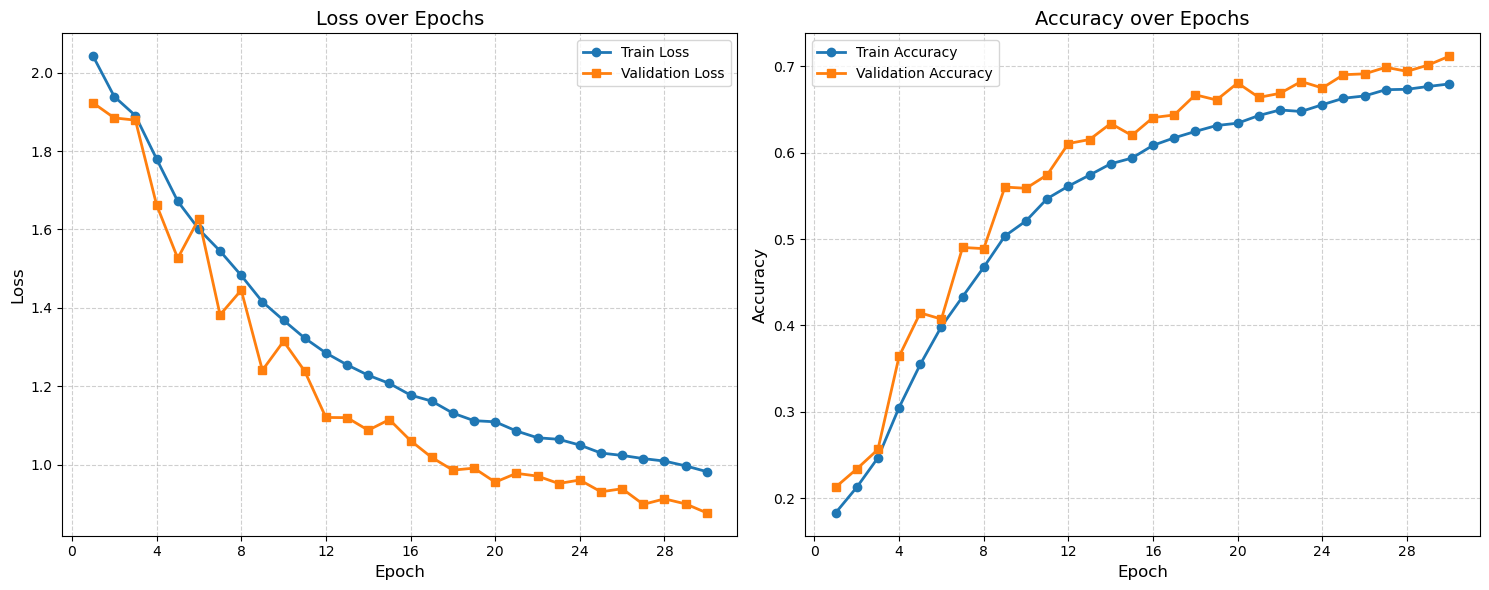

e_m_36_44_f_40 Acc:  0.73642


In [87]:
e_m_36_44_f_40.train(epoch=5)
print(f"e_m_36_44_f_40 Acc: {e_m_36_44_f_40.evaluate(): .5f}")

In [88]:
for trainer in trainers:
  trainer.checkout()

## Evaluation

In [91]:
for trainer in trainers:
  print(f"Train name: {trainer.train_name} | Epoch: {trainer.epoch} | Val acc: {trainer.evaluate(): .5f}")

Train name: a_f_36_f_36 | Epoch: 30 | Val acc:  0.78275


Train name: b_f_36_f_36 | Epoch: 30 | Val acc:  0.79812


Train name: c_f_36_f_36 | Epoch: 30 | Val acc:  0.77067


Train name: c_f_40_f_40 | Epoch: 30 | Val acc:  0.75629


Train name: c_m_36_44_f_40 | Epoch: 30 | Val acc:  0.75300


Train name: d_f_36_f_36 | Epoch: 30 | Val acc:  0.77426


Train name: d_f_40_f_40 | Epoch: 30 | Val acc:  0.76118


Train name: d_m_36_44_f_40 | Epoch: 30 | Val acc:  0.78494


Train name: e_f_36_f_36 | Epoch: 25 | Val acc:  0.67911


Train name: e_f_40_f_40 | Epoch: 30 | Val acc:  0.72883


Train name: e_m_36_44_f_40 | Epoch: 30 | Val acc:  0.73153
